<a href="https://colab.research.google.com/github/0xpix/CERI-Project/blob/main/notebooks/Geemap_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Earth Engine

In [1]:
# @title Connect to my private Repo
from google.colab import userdata

!git clone https://{userdata.get('GITHUB_KEY')}@github.com/0xpix/CERI-Project.git CERI # clone the repo inside the directory CERI

# Cd to the directory CERI
%cd CERI
!ls -a # list the directories

Cloning into 'CERI'...
remote: Enumerating objects: 1442, done.
remote: Counting objects: 100% (325/325), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 1442 (delta 221), reused 282 (delta 193), pack-reused 1117
Receiving objects: 100% (1442/1442), 575.35 MiB | 13.94 MiB/s, done.
Resolving deltas: 100% (577/577), done.
Updating files: 100% (913/913), done.
/content/CERI
.   data  .git		  .gitignore  models	 README.md   report	       results	test
..  docs  github_push.py  LICENSE     notebooks  references  requirements.txt  src


In [2]:
# @title Install Packages
%%capture
!pip install -U geemap # Upgrade geemap to the latest version
!pip install -q earthpy rioxarray cftime h5pyd Bottleneck # install in colab
!pip install rasterio localtileserver # for read HDF files

In [5]:
# @title Import Libraries
import warnings
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import random
import time
from tqdm import tqdm
import numpy as np
import pandas as pd

# Earth Engine API
import ee
import geemap

# GEE authentication
try:
    ee.Initialize(project='aims-ai2324-std-aness-9fl')
except:
    ee.Authenticate()
    ee.Initialize(project='aims-ai2324-std-aness-9fl')

warnings.simplefilter('ignore')

# My functions
from github_push import git_operations
from src.visualization.visualizing import *
from src.utils import *

# ================
#   Data Related
# ================
# Define the path to the shapefile asset
shapefile_PATH = 'data/shapefile/Africa_Shapefile/afr_g2014_2013_0.shp'
asset_PATH = 'projects/aims-ai2324-std-aness-9fl/assets/Africa_shapefile'

# Define the Disasters data path
Disasters_in_africa_2000_2018_processed_PATH = "data/processed/Disasters_in_africa_2000_2018_processed.csv"

# Specify a list of country names for which the data is to be filtered
country_names = [
    "Burundi", "Kenya", "Rwanda", "South Sudan",
    "United Republic of Tanzania", "Uganda", "Djibouti", "Eritrea",
    "Ethiopia", "Somalia"
]

# ================
# Configs related
# ================
africa_map_config = {
    "center": [0, 17],
    "width": "80%",
    "height": 900,
    "zoom": 3.5,
    "data_ctrl": False,
    "toolbar_ctrl": False,
    "draw_ctrl": False
}

eastern_sub_saharan_map_config = {
    'zoom': 6,
    'width': '60%',
    'height': 800
}

In [4]:
geemap.__version__ # geemap version

'0.32.1'

In [6]:
# DON'T RUN EVERY TIME
# Commit the changes
# git_operations("Updated script")

# Become one with the Data

<Axes: >

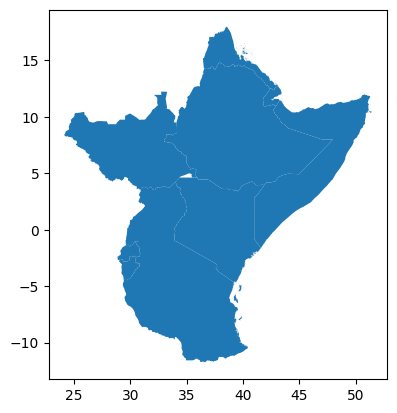

In [ ]:
# Read and plot the area of study using GeoPandas
africa_df = gpd.read_file(shapefile_PATH) # Read the shape file
eastern_sub_saharan_africa_df = africa_df[africa_df['ADM0_NAME'].isin(country_names)] # Get the shape file of the area of study
eastern_sub_saharan_africa_df.geometry.plot() # plot the shape file

In [ ]:
# Create an interactive map
Map_study_area = geemap.Map(**eastern_sub_saharan_map_config)

# Specify the Area of study and plot it in EE map
African_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
filtered_african_countries = African_countries.filter(ee.Filter.inList("ADM0_NAME", country_names)) # Filter the countries and include only the the study Area Eastern Sub Saharan Africa

# Add the filtered feature collection to the map for visualization and visualize it
Map_study_area.centerObject(filtered_african_countries)  # Center the map on the study area
Map_study_area.addLayer(filtered_african_countries, {}, "Eastern Sub Saharan Africa")
Map_study_area

In [ ]:
Map_study_area = geemap.Map(**eastern_sub_saharan_map_config)

dataset = (
    ee.ImageCollection('NOAA/VIIRS/001/VNP46A1')
    .filter(ee.Filter.date('2022-02-01', '2022-03-01'))
        )

# At-sensor Day/night Band radiance (DNB).
dnb = dataset.select('DNB_At_Sensor_Radiance_500m')
dnbVis = {
  'min': 0,
  'max': 50,
}

# Clip each image in the collection to the filtered African countries
clipped_collections_infrared = dnb.map(lambda image: image.clip(filtered_african_countries))

Map_study_area.centerObject(filtered_african_countries)  # Center the map on the study area
# Map_study_area.addLayer(clipped_collections_infrared, dnbVis, "Day-Night Band (DNB) at sensor radiance 500m")
Map_study_area.add_time_slider(clipped_collections_infrared, dnbVis, time_interval=2)

Map_study_area

In [ ]:
# Specify the video arguments
video_args = {
    'dimensions': 800,
    'region': filtered_african_countries.geometry(),
    'framesPerSecond': 2,
    'min': 0,
    'max': 50,
    'crs': 'EPSG:3857',
    'format': 'gif'
}

# Set output path for the GIF
output_gif = 'test/gif/nighttime_radiance_2017_02_to_03.gif'

# Export the ImageCollection as a GIF
geemap.download_ee_video(clipped_collections_infrared, video_args, output_gif)

## Climate Disasters Data (extraction)

In [ ]:
# Initialize the map
m = geemap.Map(**africa_map_config)

collections = ee.FeatureCollection("projects/sat-io/open-datasets/gdis_1960-2018")

# Add the clipped features to the map
m.addLayer(collections, {}, 'Clipped Features')
m

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
# Check the column for the first entry in collections
img = collections.first()
img.toDictionary()

In [ ]:
# Convert each feature to a dictionary
features_as_dicts = collections.toList(collections.size()).map(lambda feature: ee.Feature(feature).toDictionary())

# Get the list of dictionaries
dict_list = features_as_dicts.getInfo()

In [ ]:
raw_df = pd.DataFrame.from_dict(dict_list) # Convert a list of dictionary to a Pandasframe
raw_df.head(3) # Show the first 10 rows

,adm1,adm2,adm3,country,disasterno,disasterty,geo_id,geolocatio,gwno,hist_count,historical,id,iso3,latitude,level,location,longitude,year
0,Yap,NA,NA,Micronesia,2002-0126,storm,30447,Yap,999,NA,0,01-958,NA,9.350636,1,Yap Island,138.941426,2002
1,Yap,NA,NA,Micronesia,2003-0577,storm,30449,Yap,999,NA,0,01-960,NA,9.350636,1,Woleai Atoll,138.941426,2003
2,Yap,NA,NA,Micronesia,2004-0150,storm,30450,Yap,999,NA,0,01-961,NA,9.350636,1,Yap state,138.941426,2004


In [ ]:
# Saving the data as a csv file
Path_file = '/content/CERI/data/raw/Disasters_from_map_data.csv'
raw_df.to_csv(Path_file)

# Final Climate Disasters Dataset.

In [ ]:
# @title Parameters
'''
Disaster type
Flood (768), Storm (111), Drought (83), Earthquake (23), Volcanic activity (3)
'''

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('Disaster type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

In [ ]:
# Initialize the map
Map_africa = geemap.Map(**africa_map_config)

# Convert the csv file (After preprocessing) into an earth engine feature
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

CSV file converted successfully.


Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
collections

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country = collections.aggregate_histogram('location')

# Print the aggregated results
len(disasters_by_country.getInfo())

626

## Plot the total deaths for each country

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country = collections.aggregate_histogram('country')

# Print the aggregated results
disasters_by_country.getInfo()

{'Algeria': 88,
 'Angola': 53,
 'Benin': 3,
 'Botswana': 10,
 'Burkina Faso': 16,
 'Burundi': 24,
 'Cameroon': 3,
 'Central African Republic': 4,
 'Chad': 14,
 'Comoros': 6,
 'Djibouti': 1,
 'Egypt': 6,
 'Ethiopia': 31,
 'Gambia': 5,
 'Ghana': 17,
 'Guinea': 2,
 'Guinea-Bissau': 2,
 'Kenya': 68,
 'Lesotho': 7,
 'Libya': 1,
 'Madagascar': 57,
 'Malawi': 52,
 'Mali': 30,
 'Mauritania': 15,
 'Mauritius': 1,
 'Morocco': 4,
 'Mozambique': 108,
 'Namibia': 19,
 'Niger': 41,
 'Nigeria': 57,
 'Rwanda': 11,
 'Senegal': 23,
 'Seychelles': 24,
 'Sierra Leone': 1,
 'Somalia': 14,
 'South Africa': 16,
 'South Sudan': 7,
 'Sudan': 34,
 'Togo': 3,
 'Tunisia': 14,
 'Uganda': 59,
 'Zambia': 25,
 'Zimbabwe': 12}

In [ ]:
# Define visualization parameters
vis_params_disasters_count = {
    'min': 0,
    'max': 110,  # Adjust the max value based on your data
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000'] # ['#bfbfbf', '#838383', '#1a1a1a', '#4d1414', '#b40d0d']
}

# Join the disaster counts with the countries dataset
def add_disaster_count(feature):
    country_name = feature.get('ADM0_NAME')
    disaster_count = ee.Number(disasters_by_country.get(country_name, 0))
    return feature.set('disaster_count', disaster_count)

# Specify the Area of study and plot it in EE map
african_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
countries_with_counts = african_countries.map(add_disaster_count)

In [ ]:
# Create an image for visualization
disaster_count_image = countries_with_counts.reduceToImage(
    properties=['disaster_count'],
    reducer=ee.Reducer.first()
)

# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Add countries with disaster counts to the map
Map_africa_deaths.addLayer(disaster_count_image.visualize(**vis_params_disasters_count), {}, 'Disaster Counts')

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_disasters_count, label='Number of Disasters')

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Interpretation
Countries like Algeria (88), Kenya (68), and Mozambique (108) have experienced a high number of disasters.

Countries like Madagascar (57), Uganda (59), Nigeria (57), Niger (41), Malawi (52), Angola (53), Ethiopia (31), and Sudan (34) show a significant number of disasters.

The rest of the countries in West and Central Africa, as well as some parts of East Africa, show relatively lower numbers of disasters.

## Plot total Death for each country

In [ ]:
# Load the data
data = pd.read_csv(Disasters_in_africa_2000_2018_processed_PATH)

# Remove duplicate entries based on Country and Date
data = data.drop_duplicates(subset=['Country', 'Date'])

# Aggregate deaths by country
deaths_by_country = data.groupby('Country')['Total deaths'].sum().to_dict()
deaths_dict = ee.Dictionary(deaths_by_country)

In [ ]:
# Functions
def create_feature_collection():
    countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries

    def add_death_count(feature):
        country_name = feature.get('ADM0_NAME')
        deaths = ee.Number(deaths_dict.get(country_name, 0))
        return feature.set('deaths', deaths)

    return countries.map(add_death_count)

feature_collection = create_feature_collection()

In [ ]:
# Parameters
vis_params_deaths = {
    'min': 0,
    'max': max(deaths_by_country.values()),
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000']
}

deaths_image = feature_collection.reduceToImage(
    properties=['deaths'],
    reducer=ee.Reducer.first()
)

In [ ]:
# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Add countries with disaster counts to the map
Map_africa_deaths.addLayer(deaths_image.visualize(**vis_params_deaths), {}, 'Deaths by Country')

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_deaths, label='Number of Deaths')

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### Interpretation
Somalia has the highest number of deaths on the continent, in the range of 15,000 to 20,000.

Algeria has a noticeable number of deaths.

The rest of the African countries have lower numbers of deaths, with many countries having very few or zero deaths.

## Plot total death by year for each country

In [ ]:
from datetime import datetime, timedelta

def generate_date_list_for_year(year):
    # Start from the first day of the year
    start_date = datetime(year, 1, 1)
    # Initialize an empty list to hold the dates
    date_list = []
    # Loop through each day of the year
    for day in range(365 + (1 if (year % 4 == 0 and (year % 100 != 0 or year % 400 == 0)) else 0)):
        # Add the current date to the list
        date_list.append((start_date + timedelta(days=day)).strftime("%Y-%m-%d"))
    return date_list

# Generate the list for the specified year
date_list_2001 = generate_date_list_for_year(2001)
date_list_2007 = generate_date_list_for_year(2007)

In [ ]:
collections_filtered_2001 = collections.filter(ee.Filter.inList('date', date_list_2001))
collections_filtered_2007 = collections.filter(ee.Filter.inList('date', date_list_2007))

In [ ]:
# Aggregate the number of disasters by country
disasters_by_country_2001 = collections_filtered_2001.aggregate_histogram('country')
disasters_by_country_2007 = collections_filtered_2007.aggregate_histogram('country')

In [ ]:
# Define visualization parameters
vis_params_disasters_count = {
    'min': 0,
    'max': 110,  # Adjust the max value based on your data
    'palette': ['#e0ca85', '#d1a82b', '#855727', '#930404', '#450000'] # ['#bfbfbf', '#838383', '#1a1a1a', '#4d1414', '#b40d0d']
}

# Join the disaster counts with the countries dataset
def add_disaster_count_2001(feature):
    country_name = feature.get('ADM0_NAME')
    disaster_count_2001 = ee.Number(disasters_by_country_2001.get(country_name, 0))
    return feature.set('disaster_count', disaster_count_2001)

# Join the disaster counts with the countries dataset
def add_disaster_count_2007(feature):
    country_name = feature.get('ADM0_NAME')
    disaster_count_2007 = ee.Number(disasters_by_country_2007.get(country_name, 0))
    return feature.set('disaster_count', disaster_count_2007)

# Specify the Area of study and plot it in EE map
african_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
countries_with_counts_2001 = african_countries.map(add_disaster_count_2001)
countries_with_counts_2007 = african_countries.map(add_disaster_count_2007)

In [ ]:
# Create an image for visualization
disaster_count_image_2001 = countries_with_counts_2001.reduceToImage(
    properties=['disaster_count'],
    reducer=ee.Reducer.first()
)

disaster_count_image_2007 = countries_with_counts_2007.reduceToImage(
    properties=['disaster_count'],
    reducer=ee.Reducer.first()
)

In [ ]:
# Create an interactive map
Map_africa_deaths = geemap.Map(**africa_map_config)

# Split the map
left_layer = geemap.ee_tile_layer(disaster_count_image_2001.visualize(**vis_params_disasters_count), {}, "Disaster Counts 2001")
right_layer = geemap.ee_tile_layer(disaster_count_image_2007.visualize(**vis_params_disasters_count), {}, "Disaster Counts 2007")

# Add a color bar
Map_africa_deaths.add_colorbar(vis_params_disasters_count, label='Number of Disasters')

# Display the split map with layer labels
Map_africa_deaths.split_map(left_layer, right_layer)

# Add text labels for years on the map
Map_africa_deaths.add_text(
    xy=[0.2, 0.95],  # Adjust position as needed for the left side
    text='2001',
    font_size=20,
    font_color='black'
)

Map_africa_deaths.add_text(
    xy=[0.75, 0.95],  # Adjust position as needed for the right side
    text='2007',
    font_size=20,
    font_color='black'
)

# Display the map
Map_africa_deaths

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Dynamic World
## **Refrence**
Gandhi, Ujaval, 2023. Hands-on Introduction to Dynamic World workshop. Spatial Thoughts. https://courses.spatialthoughts.com/gee-dynamic-world.html

# Start

In [ ]:
from datetime import datetime
from typing import Any
from branca.element import Figure
import ee
import folium
import functools
import google
from google.colab import auth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# @title Visualization method
ELEVATION_VISPARAMS = {
    'min': 0,
    'max': 4000,
    'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
    'opacity': 0.7,
}
WORLD_POP_VISPARAMS = {
    'min': 0,
    'max': 300,
    'opacity': 0.9,
    'palette': ['283618', 'ffffff'],
}

DYNAMIC_WORLD_VISPARAMS = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '419bdf',
        '397d49',
        '88b053',
        '7a87c6',
        'e49635',
        'dfc35a',
        'c4281b',
        'a59b8f',
        'b39fe1',
    ],
}

DESERTIFICATION_VISPARAMS = {
    'min': 0,
    'max': 1,
    'opacity': 0.5,
    'palette': ['344E41', 'E6A644'],
}

S2_VISPARAMS = {'min': 0.0, 'max': 1.0, 'bands': ['B4', 'B3', 'B2']}


def _plot_ee_polygons(
    polygons,
    name='',
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    map = folium.Map(
        location=polygons[0].centroid(1).getInfo()['coordinates'][::-1],
        **kwargs,
    )

  for polygon in polygons:
    geo_j = polygon.toGeoJSON()
    geo_j = folium.GeoJson(
        geo_j,
        name=name,
        style_function=lambda feature: {
            'fillColor': fill_color,
            'color': border_color,
            'weight': 2,
        },
    )
    geo_j.add_to(map)
  return map


def _plot_ee_points(
    points,
    names=None,
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    points_centroid = (
        ee.Geometry.MultiPoint(points).centroid().getInfo()['coordinates'][::-1]
    )
    map = folium.Map(location=points_centroid, **kwargs)

  for idx, point in enumerate(points):
    lat, lon = point.getInfo()['coordinates']
    if names:
      point_name = names[idx]
    else:
      point_name = ''
    folium.Marker(
        location=[lon, lat],
        popup=point_name if point_name else None,
    ).add_to(map)
  return map


def _plot_ee_image(
    image, name='', visParams=None, coords=(0, 0), map=None, **kwargs
):
  # Set visualization parameters.
  if not visParams:
    visParams = {}
  # Create a folium map object.
  if not map:
    map = folium.Map(location=coords, **kwargs)
  mapID = image.getMapId(visParams)
  image_layer = folium.raster_layers.TileLayer(
      tiles=mapID['tile_fetcher'].url_format,
      attr='Map Data © Google Earth Engine',
      name=name,
      overlay=True,
      control=True,
  )

  image_layer.add_to(map)

  return map


def _display_map(map, width=800, height=400):
  # Add a layer control panel to the map.
  map.add_child(folium.LayerControl())
  figure = Figure(width=width, height=height)
  figure.add_child(map)
  return figure

In [ ]:
dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

image = (
    dynamic_world.filterDate('2022-01-01', '2023-01-01')
    .select('label')
    .mosaic()
)
map = _plot_ee_image(
    image,
    name='Dynamic world',
    zoom_start=16,
    coords=(5.6515477, -0.1868334),
    visParams=DYNAMIC_WORLD_VISPARAMS,
)
_display_map(map)

In [ ]:
YEAR_i = 2015
YEAR_j = 2023
class_labels = [
    "water",
    "trees",
    "grass",
    "flooded_vegetation",
    "crops",
    "shrub_and_scrub",
    "built",
    "bare",
    "snow_and_ice",
]
DW_PROBABILITY_THRESHOLD = 0.40


def _get_masked_dw_image_for_year(year):
  # First, in order to ensure we have full coverage over the entire world (with
  # sufficient pixels without clouds) we form a full image over the earth by
  # calculating tthe mean
  dw_interval = dynamic_world.filterDate(f"{year}-01-01", f"{year}-12-31")
  mask = (
      dw_interval.select(class_labels)
      .mean()
      .reduce(ee.Reducer.max())
      .gte(DW_PROBABILITY_THRESHOLD)
  )
  dw_image = dw_interval.select("label").mode().mask(mask)
  return dw_image


def _get_sentinel_2_image_for_date(year):
  s2_image = (
      sentinel_2.filterDate(f"{year}-01-01", f"{year}-12-31")
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
      .select(["B4", "B3", "B2"])
      # Construct a mosaic out of the sentinel-2 images.
      .mosaic()
      .multiply(0.0001)
  )
  return s2_image


dw_i = _get_masked_dw_image_for_year(YEAR_i)
dw_j = _get_masked_dw_image_for_year(YEAR_j)

s2_i = _get_sentinel_2_image_for_date(YEAR_i)
s2_j = _get_sentinel_2_image_for_date(YEAR_j)

def _is_dw_green(dw_image):
  # trees, grass, crops
  green_labels = [1, 2, 4, 5]

  green_image = dw_image.eq(green_labels[0])
  for other_green_label in green_labels:
    green_image = green_image.Or(dw_image.eq(other_green_label))
  return green_image


green_i = _is_dw_green(dw_i)
bare_j = dw_j.eq(7)
desertification = green_i.And(bare_j).unmask(0)

map = _plot_ee_image(
    desertification,
    name='Desertification',
    visParams=DESERTIFICATION_VISPARAMS,
    zoom_start=11,
    coords=(18.1008527, 33.9783173),
)
map = _plot_ee_image(s2_i, f'S2 {YEAR_i}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(s2_j, f'S2 {YEAR_j}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(
    dw_i,
    f'Dynamic World {YEAR_i}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)
map = _plot_ee_image(
    dw_j,
    f'Dynamic World {YEAR_j}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)

_display_map(map)

In [ ]:
from datetime import datetime
from typing import Any
from branca.element import Figure
import ee
import folium
import functools
import google
from google.colab import auth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# @title Visualization method
ELEVATION_VISPARAMS = {
    'min': 0,
    'max': 4000,
    'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
    'opacity': 0.7,
}
WORLD_POP_VISPARAMS = {
    'min': 0,
    'max': 300,
    'opacity': 0.9,
    'palette': ['283618', 'ffffff'],
}

DYNAMIC_WORLD_VISPARAMS = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '419bdf',
        '397d49',
        '88b053',
        '7a87c6',
        'e49635',
        'dfc35a',
        'c4281b',
        'a59b8f',
        'b39fe1',
    ],
}

URBAN_CHANGE_VISPARAMS = {
    'min': 0,
    'max': 1,
    'opacity': 0.5,
    'palette': ['344E41', 'E6A644'],
}

S2_VISPARAMS = {'min': 0.0, 'max': 1.0, 'bands': ['B4', 'B3', 'B2']}

def _plot_ee_polygons(
    polygons,
    name='',
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    map = folium.Map(
        location=polygons[0].centroid(1).getInfo()['coordinates'][::-1],
        **kwargs,
    )

  for polygon in polygons:
    geo_j = polygon.toGeoJSON()
    geo_j = folium.GeoJson(
        geo_j,
        name=name,
        style_function=lambda feature: {
            'fillColor': fill_color,
            'color': border_color,
            'weight': 2,
        },
    )
    geo_j.add_to(map)
  return map

def _plot_ee_points(
    points,
    names=None,
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    points_centroid = (
        ee.Geometry.MultiPoint(points).centroid().getInfo()['coordinates'][::-1]
    )
    map = folium.Map(location=points_centroid, **kwargs)

  for idx, point in enumerate(points):
    lat, lon = point.getInfo()['coordinates']
    if names:
      point_name = names[idx]
    else:
      point_name = ''
    folium.Marker(
        location=[lon, lat],
        popup=point_name if point_name else None,
    ).add_to(map)
  return map

def _plot_ee_image(
    image, name='', visParams=None, coords=(0, 0), map=None, **kwargs
):
  # Set visualization parameters.
  if not visParams:
    visParams = {}
  # Create a folium map object.
  if not map:
    map = folium.Map(location=coords, **kwargs)
  mapID = image.getMapId(visParams)
  image_layer = folium.raster_layers.TileLayer(
      tiles=mapID['tile_fetcher'].url_format,
      attr='Map Data © Google Earth Engine',
      name=name,
      overlay=True,
      control=True,
  )

  image_layer.add_to(map)

  return map

def _display_map(map, width=800, height=400):
  # Add a layer control panel to the map.
  map.add_child(folium.LayerControl())
  figure = Figure(width=width, height=height)
  figure.add_child(map)
  return figure

ee.Initialize()

dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED')

image = (
    dynamic_world.filterDate('2022-01-01', '2023-01-01')
    .select('label')
    .mosaic()
)
map = _plot_ee_image(
    image,
    name='Dynamic world',
    zoom_start=16,
    coords=(5.6515477, -0.1868334),
    visParams=DYNAMIC_WORLD_VISPARAMS,
)
_display_map(map)

YEAR_i = 2015
YEAR_j = 2023
class_labels = [
    "water",
    "trees",
    "grass",
    "flooded_vegetation",
    "crops",
    "shrub_and_scrub",
    "built",
    "bare",
    "snow_and_ice",
]
DW_PROBABILITY_THRESHOLD = 0.40

def _get_masked_dw_image_for_year(year):
  # First, in order to ensure we have full coverage over the entire world (with
  # sufficient pixels without clouds) we form a full image over the earth by
  # calculating the mean
  dw_interval = dynamic_world.filterDate(f"{year}-01-01", f"{year}-12-31")
  mask = (
      dw_interval.select(class_labels)
      .mean()
      .reduce(ee.Reducer.max())
      .gte(DW_PROBABILITY_THRESHOLD)
  )
  dw_image = dw_interval.select("label").mode().mask(mask)
  return dw_image

def _get_sentinel_2_image_for_date(year):
  s2_image = (
      sentinel_2.filterDate(f"{year}-01-01", f"{year}-12-31")
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
      .select(["B4", "B3", "B2"])
      # Construct a mosaic out of the sentinel-2 images.
      .mosaic()
      .multiply(0.0001)
  )
  return s2_image

dw_i = _get_masked_dw_image_for_year(YEAR_i)
dw_j = _get_masked_dw_image_for_year(YEAR_j)

s2_i = _get_sentinel_2_image_for_date(YEAR_i)
s2_j = _get_sentinel_2_image_for_date(YEAR_j)

def _is_dw_built(dw_image):
  # built
  built_label = 6
  built_image = dw_image.eq(built_label)
  return built_image

def _is_dw_not_built_or_unclassified(dw_image):
  # Not built (any class except 'built') or unclassified
  not_built_image = dw_image.neq(6)
  unclassified_image = dw_image.mask().Not()
  not_built_or_unclassified_image = not_built_image.Or(unclassified_image)
  return not_built_or_unclassified_image

# Get not built or unclassified areas in year_i and built areas in year_j
not_built_or_unclassified_i = _is_dw_not_built_or_unclassified(dw_i)
built_j = _is_dw_built(dw_j)
urban_change = not_built_or_unclassified_i.And(built_j).unmask(0)

map = _plot_ee_image(
    urban_change,
    name='Urban Change',
    visParams=URBAN_CHANGE_VISPARAMS,
    zoom_start=11,
    coords=(18.1008527, 33.9783173),
)
map = _plot_ee_image(s2_i, f'S2 {YEAR_i}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(s2_j, f'S2 {YEAR_j}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(
    dw_i,
    f'Dynamic World {YEAR_i}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)
map = _plot_ee_image(
    dw_j,
    f'Dynamic World {YEAR_j}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)

_display_map(map)

## Each country individualy

In [13]:
from datetime import datetime
from typing import Any
from branca.element import Figure
import ee
import folium
import functools
import google
from google.colab import auth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# @title Visualization method
ELEVATION_VISPARAMS = {
    'min': 0,
    'max': 4000,
    'dimensions': 512,
    'palette': ['006633', 'E5FFCC', '662A00', 'D8D8D8', 'F5F5F5'],
    'opacity': 0.7,
}
WORLD_POP_VISPARAMS = {
    'min': 0,
    'max': 300,
    'opacity': 0.9,
    'palette': ['283618', 'ffffff'],
}

DYNAMIC_WORLD_VISPARAMS = {
    'min': 0,
    'max': 8,
    'opacity': 0.5,
    'palette': [
        '419bdf',
        '397d49',
        '88b053',
        '7a87c6',
        'e49635',
        'dfc35a',
        'c4281b',
        'a59b8f',
        'b39fe1',
    ],
}

URBAN_CHANGE_VISPARAMS = {
    'min': 0,
    'max': 1,
    'opacity': 0.5,
    'palette': ['344E41', 'E6A644'],
}

S2_VISPARAMS = {'min': 0.0, 'max': 1.0, 'bands': ['B4', 'B3', 'B2']}

def _plot_ee_polygons(
    polygons,
    name='',
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    map = folium.Map(
        location=polygons[0].centroid(1).getInfo()['coordinates'][::-1],
        **kwargs,
    )

  for polygon in polygons:
    geo_j = polygon.toGeoJSON()
    geo_j = folium.GeoJson(
        geo_j,
        name=name,
        style_function=lambda feature: {
            'fillColor': fill_color,
            'color': border_color,
            'weight': 2,
        },
    )
    geo_j.add_to(map)
  return map

def _plot_ee_points(
    points,
    names=None,
    map=None,
    border_color='red',
    fill_color='transparent',
    **kwargs,
):
  if not map:
    points_centroid = (
        ee.Geometry.MultiPoint(points).centroid().getInfo()['coordinates'][::-1]
    )
    map = folium.Map(location=points_centroid, **kwargs)

  for idx, point in enumerate(points):
    lat, lon = point.getInfo()['coordinates']
    if names:
      point_name = names[idx]
    else:
      point_name = ''
    folium.Marker(
        location=[lon, lat],
        popup=point_name if point_name else None,
    ).add_to(map)
  return map

def _plot_ee_image(
    image, name='', visParams=None, coords=(0, 0), map=None, **kwargs
):
  # Set visualization parameters.
  if not visParams:
    visParams = {}
  # Create a folium map object.
  if not map:
    map = folium.Map(location=coords, **kwargs)
  mapID = image.getMapId(visParams)
  image_layer = folium.raster_layers.TileLayer(
      tiles=mapID['tile_fetcher'].url_format,
      attr='Map Data © Google Earth Engine',
      name=name,
      overlay=True,
      control=True,
  )

  image_layer.add_to(map)

  return map

def _display_map(map, width=800, height=400):
  # Add a layer control panel to the map.
  map.add_child(folium.LayerControl())
  figure = Figure(width=width, height=height)
  figure.add_child(map)
  return figure

ee.Initialize()

# Define the country of interest
COUNTRY_NAME = 'Mozambique'

# Get the country geometry
country = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', COUNTRY_NAME)).geometry()

dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterBounds(country)
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterBounds(country)

image = (
    dynamic_world.filterDate('2022-01-01', '2023-01-01')
    .select('label')
    .mosaic()
)
map = _plot_ee_image(
    image,
    name='Dynamic world',
    zoom_start=8,
    coords=(7.9465, -1.0232),  # Coordinates of Ghana
    visParams=DYNAMIC_WORLD_VISPARAMS,
)
_display_map(map)

YEAR_i = 2015
YEAR_j = 2023
class_labels = [
    "water",
    "trees",
    "grass",
    "flooded_vegetation",
    "crops",
    "shrub_and_scrub",
    "built",
    "bare",
    "snow_and_ice",
]
DW_PROBABILITY_THRESHOLD = 0.40

def _get_masked_dw_image_for_year(year):
  dw_interval = dynamic_world.filterDate(f"{year}-01-01", f"{year}-12-31")
  mask = (
      dw_interval.select(class_labels)
      .mean()
      .reduce(ee.Reducer.max())
      .gte(DW_PROBABILITY_THRESHOLD)
  )
  dw_image = dw_interval.select("label").mode().mask(mask)
  return dw_image.clip(country)

def _get_sentinel_2_image_for_date(year):
  s2_image = (
      sentinel_2.filterDate(f"{year}-01-01", f"{year}-12-31")
      .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
      .select(["B4", "B3", "B2"])
      .mosaic()
      .multiply(0.0001)
  )
  return s2_image.clip(country)

dw_i = _get_masked_dw_image_for_year(YEAR_i)
dw_j = _get_masked_dw_image_for_year(YEAR_j)

s2_i = _get_sentinel_2_image_for_date(YEAR_i)
s2_j = _get_sentinel_2_image_for_date(YEAR_j)

def _is_dw_built(dw_image):
  built_label = 6
  built_image = dw_image.eq(built_label)
  return built_image

def _is_dw_not_built_or_unclassified(dw_image):
  not_built_image = dw_image.neq(6)
  unclassified_image = dw_image.mask().Not()
  not_built_or_unclassified_image = not_built_image.Or(unclassified_image)
  return not_built_or_unclassified_image

not_built_or_unclassified_i = _is_dw_not_built_or_unclassified(dw_i)
built_j = _is_dw_built(dw_j)
urban_change = not_built_or_unclassified_i.And(built_j).unmask(0)

map = _plot_ee_image(
    urban_change,
    name='Urban Change',
    visParams=URBAN_CHANGE_VISPARAMS,
    zoom_start=8,
    coords=(7.9465, -1.0232),
)
map = _plot_ee_image(s2_i, f'S2 {YEAR_i}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(s2_j, f'S2 {YEAR_j}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(
    dw_i,
    f'Dynamic World {YEAR_i}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)
map = _plot_ee_image(
    dw_j,
    f'Dynamic World {YEAR_j}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)

_display_map(map)

In [ ]:
Map =

In [26]:
from datetime import datetime
from typing import Any
from branca.element import Figure
import ee
import folium
import functools
import google
from google.colab import auth
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Initialize Earth Engine
ee.Initialize()

# Define a smaller region of interest within Ghana
region_of_interest = ee.Geometry.Polygon([
    [
        [-1.56, 5.36],
        [-1.56, 5.56],
        [-1.36, 5.56],
        [-1.36, 5.36],
        [-1.56, 5.36]
    ]
])

# Print region to ensure it's correctly defined
print("Region of Interest: ", region_of_interest.getInfo())

# Define visualization parameters
URBAN_CHANGE_VISPARAMS = {
    'min': 0,
    'max': 1,
    'opacity': 0.5,
    'palette': ['344E41', 'E6A644'],
}
S2_VISPARAMS = {'min': 0.0, 'max': 1.0, 'bands': ['B4', 'B3', 'B2']}
POP_VISPARAMS = {'min': 0, 'max': 300, 'palette': ['white', 'red']}

dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filterBounds(region_of_interest)
sentinel_2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED').filterBounds(region_of_interest)

def _get_masked_dw_image_for_year(year):
    class_labels = [
        "water",
        "trees",
        "grass",
        "flooded_vegetation",
        "crops",
        "shrub_and_scrub",
        "built",
        "bare",
        "snow_and_ice",
    ]
    DW_PROBABILITY_THRESHOLD = 0.40

    dw_interval = dynamic_world.filterDate(f"{year}-01-01", f"{year}-12-31")
    mask = (
        dw_interval.select(class_labels)
        .mean()
        .reduce(ee.Reducer.max())
        .gte(DW_PROBABILITY_THRESHOLD)
    )
    dw_image = dw_interval.select("label").mode().mask(mask)
    clipped_image = dw_image.clip(region_of_interest)
    print(f"Masked DW Image for {year}: ", clipped_image.getInfo())
    return clipped_image

def _get_sentinel_2_image_for_date(year):
    s2_image = (
        sentinel_2.filterDate(f"{year}-01-01", f"{year}-12-31")
        .filter(ee.Filter.lt("CLOUDY_PIXEL_PERCENTAGE", 10))
        .select(["B4", "B3", "B2"])
        .mosaic()
        .multiply(0.0001)
    )
    clipped_image = s2_image.clip(region_of_interest)
    print(f"Sentinel-2 Image for {year}: ", clipped_image.getInfo())
    return clipped_image

def _is_dw_built(dw_image):
    built_label = 6
    built_image = dw_image.eq(built_label)
    return built_image

def _is_dw_not_built_or_unclassified(dw_image):
    not_built_image = dw_image.neq(6)
    unclassified_image = dw_image.mask().Not()
    not_built_or_unclassified_image = not_built_image.Or(unclassified_image)
    return not_built_or_unclassified_image

YEAR_i = 2017
YEAR_j = 2023

dw_i = _get_masked_dw_image_for_year(YEAR_i)
dw_j = _get_masked_dw_image_for_year(YEAR_j)

s2_i = _get_sentinel_2_image_for_date(YEAR_i)
s2_j = _get_sentinel_2_image_for_date(YEAR_j)

not_built_or_unclassified_i = _is_dw_not_built_or_unclassified(dw_i)
built_j = _is_dw_built(dw_j)
urban_change = not_built_or_unclassified_i.And(built_j).unmask(0)

def _plot_ee_image(image, name='', visParams=None, coords=(0, 0), map=None, **kwargs):
    if not visParams:
        visParams = {}
    if not map:
        map = folium.Map(location=coords, **kwargs)
    try:
        mapID = image.getMapId(visParams)
        image_layer = folium.raster_layers.TileLayer(
            tiles=mapID['tile_fetcher'].url_format,
            attr='Map Data © Google Earth Engine',
            name=name,
            overlay=True,
            control=True,
        )
        image_layer.add_to(map)
    except Exception as e:
        print(f"Error adding {name} layer: {e}")
    return map

def _display_map(map, width=800, height=400):
    map.add_child(folium.LayerControl())
    figure = Figure(width=width, height=height)
    figure.add_child(map)
    return figure

map = folium.Map(location=[5.46, -1.46], zoom_start=10)
map = _plot_ee_image(urban_change, name='Urban Change', visParams=URBAN_CHANGE_VISPARAMS, map=map)
map = _plot_ee_image(s2_i, f'S2 {YEAR_i}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(s2_j, f'S2 {YEAR_j}', visParams=S2_VISPARAMS, map=map)
map = _plot_ee_image(
    dw_i,
    f'Dynamic World {YEAR_i}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)
map = _plot_ee_image(
    dw_j,
    f'Dynamic World {YEAR_j}',
    visParams=DYNAMIC_WORLD_VISPARAMS,
    map=map,
)

_display_map(map)

# Get statistics
def calculate_area(image, region):
    pixel_area = ee.Image.pixelArea()
    area_image = pixel_area.mask(image)
    stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=30,
        maxPixels=1e9
    )
    return stats.getInfo()

urban_area_i = calculate_area(_is_dw_built(dw_i), region_of_interest)
urban_area_j = calculate_area(_is_dw_built(dw_j), region_of_interest)
urban_change_area = calculate_area(urban_change, region_of_interest)

print(f"Urban area in {YEAR_i}: {urban_area_i['area']} square meters")
print(f"Urban area in {YEAR_j}: {urban_area_j['area']} square meters")
print(f"Urban change area between {YEAR_i} and {YEAR_j}: {urban_change_area['area']} square meters")

Region of Interest:  {'type': 'Polygon', 'coordinates': [[[-1.56, 5.36], [-1.36, 5.36], [-1.36, 5.56], [-1.56, 5.56], [-1.56, 5.36]]]}
Masked DW Image for 2017:  {'type': 'Image', 'bands': [{'id': 'label', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [3, 3], 'origin': [-3, 4], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[-1.56, 5.36], [-1.36, 5.36], [-1.36, 5.56], [-1.56, 5.56], [-1.56, 5.36]]]}}}
Masked DW Image for 2023:  {'type': 'Image', 'bands': [{'id': 'label', 'data_type': {'type': 'PixelType', 'precision': 'int', 'min': 0, 'max': 255}, 'dimensions': [3, 3], 'origin': [-3, 4], 'crs': 'EPSG:4326', 'crs_transform': [1, 0, 0, 0, 1, 0]}], 'properties': {'system:footprint': {'type': 'Polygon', 'coordinates': [[[-1.56, 5.36], [-1.36, 5.36], [-1.36, 5.56], [-1.56, 5.56], [-1.56, 5.36]]]}}}
Sentinel-2 Image for 2017:  {'type': 'Image', 'bands': [{'id': 'B

In [27]:
_display_map(map)

In [63]:
# Create a map centered at a specific location.
Map = geemap.Map(center=[0, 0], zoom=2)

# Load the Dynamic World dataset.
dynamic_world = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')

# Filter the dataset to a specific date range.
dw_image = dynamic_world.filterDate('2015-06-27', '2015-07-05')

# Define the visualization parameters for Dynamic World.
dw_viz_params = {
    'min': 0,
    'max': 1,
    'bands': ['label'],
    'palette': [
        '419BDF', '397D49', '88B053', '7A87C6', 'E49635', 'DFC35A',
        'C4281B', 'A59B8F', 'B39FE1'
    ],
    'opacity': 0.7,
}

# Load the Sentinel-2 surface reflectance image collection.
sentinel2_sr = ee.ImageCollection('COPERNICUS/S2_SR')

# Filter Sentinel-2 imagery by date and cloud cover.
sentinel2_filtered = sentinel2_sr.filterDate('2016-06-27', '2016-07-05') \
                                 .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))

# Get the median image from the filtered collection.
sentinel2_image = sentinel2_filtered.median()

# Define the visualization parameters for Sentinel-2.
s2_viz_params = {
    'min': 0,
    'max': 3000,
    'bands': ['B4', 'B3', 'B2'],  # True color (RGB)
}

# Add the Dynamic World layer to the map.
Map.addLayer(dw_image, dw_viz_params, 'Dynamic World')

# Add the Sentinel-2 layer to the map.
Map.addLayer(sentinel2_image, s2_viz_params, 'Sentinel-2')

# Display the map.
Map.addLayerControl()
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

## Dynamic World Change detection

In [25]:
geometry = ee.Geometry.Polygon(
        [[[47.06454177721226, -18.643013228835457],
          [47.06454177721226, -19.235329392403454],
          [47.89950271471226, -19.235329392403454],
          [47.89950271471226, -18.643013228835457]]])

In [32]:
DW_map = geemap.Map()

# countries = ee.FeatureCollection("FAO/GAUL/2015/level0")
# filtered = countries.filter(ee.Filter.eq('ADM0_NAME', 'Madagascar'))
# geometry = filtered.geometry()

# DW_map.CenterObject(geometry, 10)

START_DATE = "2018-03-16" # 16 march 2018, 7 days
END_DATE = "2018-04-23"

dw = (ee.ImageCollection("GOOGLE/DYNAMICWORLD/V1")
          .filterDate(START_DATE, END_DATE)
          .filterBounds(geometry))

classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.mode())

built_area = dw_composite.eq(6)

dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette':[
    '#419BDF', '#397D49', '#88B053', '#7A87C6', '#E49635', '#DFC35A',
    '#C4281B', '#A59B8F', '#B39FE1'
  ]
}

# Clip the composite and add it to the Map
DW_map.add_layer(dw_composite.clip(geometry), dw_vis_params, "Classifed Composite")
DW_map.add_layer(built_area.clip(geometry), {}, "Built Area")

DW_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

### Count the pixels for `built area` within the Region

In [35]:
# rename the bands to easly kep track of them
dw_composite = dw_composite.rename(['classification'])
built_area = built_area.rename(['built_area'])

In [36]:
# Count all pixels
time_start = time.time()  # Start time
stats_total = built_area.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=geometry,
    scale=10,
    maxPixels=1e10
)
time_end = time.time()  # End time

total_pixels = stats_total.get('built_area').getInfo()
print("Total pixels:", total_pixels)
print("Time taken for counting all pixels: {:.2f} seconds".format(time_end - time_start))

# Mask 0 pixel values and count remaining pixels
time_start = time.time()  # Start time
built_area_mask = built_area.selfMask()

stats_masked = built_area_mask.reduceRegion(
    reducer=ee.Reducer.count(),
    geometry=geometry,
    scale=10,
    maxPixels=1e10
)
time_end = time.time()  # End time

built_area_pixels = stats_masked.get('built_area').getInfo()
print("Built area pixels:", built_area_pixels)
print("Time taken for counting masked pixels: {:.2f} seconds".format(time_end - time_start))

Total pixels: 58770810
Time taken for counting all pixels: 0.00 seconds
Built area pixels: 3464703
Time taken for counting masked pixels: 0.00 seconds


In [33]:
import time

# Function to perform reduceRegion with retries
def safe_reduce_region(image, reducer, geometry, scale, max_pixels, retries=3, delay=10):
    for i in range(retries):
        try:
            return image.reduceRegion(
                reducer=reducer,
                geometry=geometry,
                scale=scale,
                maxPixels=max_pixels
            ).getInfo()
        except ee.EEException as e:
            print(f"Attempt {i + 1} failed: {e}")
            time.sleep(delay)
    raise ee.EEException("Computation failed after multiple retries")

# Count all pixels
stats_total = safe_reduce_region(
    built_area,
    ee.Reducer.count(),
    geometry,
    10,
    1e10
)

total_pixels = stats_total.get('built_area', 0)  # Use default value 0 if key doesn't exist
print(total_pixels)

# Mask 0 pixel values and count remaining pixels
built_area_mask = built_area.selfMask()

stats_masked = safe_reduce_region(
    built_area_mask,
    ee.Reducer.count(),
    geometry,
    10,
    1e10
)

built_area_pixels = stats_masked.get('built_area', 0)  # Use default value 0 if key doesn't exist
print(built_area_pixels)

0
0


In [ ]:
# Calculate the fraction of built area
fraction = ee.Number(built_area_pixels).divide(total_pixels).multiply(100).getInfo()

# Format the fraction to two decimal places
formatted_fraction = "{:.2f}".format(fraction)
print('Percentage Built Area:', formatted_fraction)

### Summarizing Pixel Counts for `All Classes`

In [ ]:
pixel_count_stats = dw_composite.reduceRegion(
      reducer = ee.Reducer.frequencyHistogram().unweighted(),
      geometry = geometry,
      scale = 10,
      maxPixels = 1e10
)

pixel_counts = ee.Dictionary(
      pixel_count_stats.get('classification')
)
print(pixel_counts)

In [ ]:
# Define class labels
class_labels = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
]

# Format the results by renaming keys with class names
keys = pixel_counts.keys().getInfo()
values = pixel_counts.values().getInfo()

# Create a dictionary with class labels as keys
pixel_counts_formatted = dict(zip(class_labels, values))
print(pixel_counts_formatted)

# END

In [ ]:
start_date = '2020-01-01'
end_date = '2021-01-01'

dw = (ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1')
  .filter(ee.Filter.date(start_date, end_date)))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

dw_vis_params = {
  'min': 0,
  'max': 8,
  'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
    '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

dw_map = geemap.Map()
dw_map.add_layer(dw_composite, dw_vis_params, 'Classified composite')

#  Create a Top-1 Probability Hillshade Visualization
protbability_band = [
    'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
    'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
probability_col = dw.select(protbability_band) # Select probability bands

#  Create a multi-band image with the average pixel-wise probability
#  for each band across the time-period
mean_probability = probability_col.reduce(ee.Reducer.mean())

#  Composites have a default projection that is not suitable
#  for hillshade computation.
#  Set a EPSG:3857 projection with 10m scale
projection = ee.Projection('EPSG:3857').atScale(10)
mean_probability = mean_probability.setDefaultProjection(projection)

#  Create the Top1 Probability Hillshade
top1_probability = mean_probability.reduce(ee.Reducer.max())
top1_confidence = top1_probability.multiply(100).int()
hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)
rgb_image = dw_composite.visualize(dw_vis_params).divide(255);
probability_hillshade = rgb_image.multiply(hillshade)

hillshade_vis_params = {
      'min': 0,
      'max': 0.8
}

dw_map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [ ]:
# @title Parameters
african_countries = ee.FeatureCollection(asset_PATH)  # create a feature collection that contains multiple countries
geometry = african_countries.geometry()

# Filter the disasters and the areas


# Visualization parameters.
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Format the results to make it more readable.
class_labels = ['water', 'trees', 'grass', 'flooded_vegetation', 'crops',
                'shrub_and_scrub', 'built', 'bare', 'snow_and_ice']



In [ ]:
# Load the data
data = pd.read_excel('data/processed/Disasters_in_africa_2000_2018_processed.xlsx')
data.head()

,disasterno,Country,Location,Disaster type,Year,Date,Total deaths,Latitude,Longitude
0,1999-9388,Sudan,Northern Darfur,Drought,2000,2000-01-01,0,12.345280,23.438724
1,1999-9388,Somalia,Ceel Barde,Drought,2000,2000-01-01,21,4.663144,43.991431
2,2000-0012,Mozambique,Matutuine,Flood,2000,2000-01-26,800,-26.524360,32.561550
3,2000-0012,Mozambique,Manhica,Flood,2000,2000-01-26,800,-25.308950,32.825503
4,2000-0012,Mozambique,Magude,Flood,2000,2000-01-26,800,-24.701850,32.439407


In [ ]:
# Function to filter data based on year and month
def get_feature_collections(data, year=None, month=None, disaster_type=None):
    # Convert 'date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Extract year and month from 'date' column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # Apply filters based on year and month
    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Return the filtered feature collection as separate lists
    return (
        data['Date'].to_list(),
        data['Location'].to_list(),
        data['Country'].to_list(),
        data['Latitude'].to_list(),
        data['Longitude'].to_list()
    )

# Example usage
target_date, target_loc, target_country, target_lat, target_long = get_feature_collections(data, year=2016, month=9, disaster_type='Flood')
target_loc

['Gwaram']

In [ ]:
target_country

['Nigeria']

In [ ]:
target_date

[Timestamp('2016-09-01 00:00:00')]

In [ ]:
target_lat

[11.17834227]

In [ ]:
target_long

[9.991843635]

In [ ]:
import geemap
import numpy as np

def get_centroid(latitudes, longitudes):
    # Ensure the lists are not empty and have the same length
    if len(latitudes) == 0 or len(longitudes) == 0 or len(latitudes) != len(longitudes):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length")

    # Convert lists to numpy arrays
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    # Calculate the centroid
    centroid_lat = np.mean(latitudes)
    centroid_long = np.mean(longitudes)

    return centroid_lat, centroid_long

centroid_lat, centroid_long = get_centroid(target_lat, target_long)
print(f"Centroid: ({centroid_lat}, {centroid_long})")  # Output: Centroid: (20.0, 50.0)

Centroid: (-22.896637456666667, 33.30381484444445)


In [ ]:
# Define the region of interest.
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')
for loc in target_loc:
    # Filter the FeatureCollection for the current location
    selected = admin1.filter(ee.Filter.eq('ADM2_NAME', loc))
    geometry = selected.geometry()

In [ ]:
geometry

ee.Geometry({
  "functionInvocationValue": {
    "functionName": "Collection.geometry",
    "arguments": {
      "collection": {
        "functionInvocationValue": {
          "functionName": "Collection.filter",
          "arguments": {
            "collection": {
              "functionInvocationValue": {
                "functionName": "Collection.loadTable",
                "arguments": {
                  "tableId": {
                    "constantValue": "FAO/GAUL_SIMPLIFIED_500m/2015/level2"
                  }
                }
              }
            },
            "filter": {
              "functionInvocationValue": {
                "functionName": "Filter.equals",
                "arguments": {
                  "leftField": {
                    "constantValue": "ADM2_NAME"
                  },
                  "rightValue": {
                    "constantValue": "Chimanimani"
                  }
                }
              }
            }
          }
        }
      }
    }
  }
})

### a month before the disaster

In [28]:
import ee
import geemap

# Initialize Earth Engine
ee.Initialize()

# Define the date range
start_date = '2016-08-25'
end_date = '2016-08-31'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

# Visualization parameters for Dynamic World
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Define the target locations and centroids
target_loc = ['Accra', 'Kumasi']  # Example locations
target_lat, target_long = 5.55, -0.2  # Example centroid for initial map view

def get_centroid(lat, long):
    return lat, long

centroid_lat, centroid_long = get_centroid(target_lat, target_long)

# Load the Sentinel-2 ImageCollection and filter by date and cloud cover
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Create a median composite for Sentinel-2
s2_composite = s2.median()

# Visualization parameters for Sentinel-2
s2_vis_params = {
    'min': 0.0,
    'max': 3000.0,
    'bands': ['B4', 'B3', 'B2']
}

# Create a map
dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_dw_composite = dw_composite.clip(geometry)
    clipped_s2_composite = s2_composite.clip(geometry)

    # Add the classified composite layer to the map
    dw_map.add_layer(clipped_dw_composite, dw_vis_params, f'{loc} Classified Composite')
    dw_map.add_layer(clipped_s2_composite, s2_vis_params, f'{loc} Sentinel-2 Composite')

# Display the map
dw_map

Location 'Accra' not found in either admin1 or admin2. Skipping.
Location 'Kumasi' not found in either admin1 or admin2. Skipping.


Map(center=[5.55, -0.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…

In [29]:
import ee
import folium
from branca.element import Figure

# Initialize Earth Engine
ee.Initialize()

# Define the date range
start_date = '2016-08-25'
end_date = '2016-08-31'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.mode())

# Visualization parameters for Dynamic World
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Define the target locations and centroids
target_loc = ['Accra', 'Kumasi']  # Example locations
target_lat, target_long = 5.55, -0.2  # Example centroid for initial map view

def get_centroid(lat, long):
    return lat, long

centroid_lat, centroid_long = get_centroid(target_lat, target_long)

# Load the Sentinel-2 ImageCollection and filter by date and cloud cover
s2 = ee.ImageCollection('COPERNICUS/S2_HARMONIZED') \
    .filterDate(start_date, end_date) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))

# Create a median composite for Sentinel-2
s2_composite = s2.median()

# Visualization parameters for Sentinel-2
s2_vis_params = {
    'min': 0.0,
    'max': 3000.0,
    'bands': ['B4', 'B3', 'B2']
}

# Create a folium map
folium_map = folium.Map(location=[centroid_lat, centroid_long], zoom_start=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_dw_composite = dw_composite.clip(geometry)
    clipped_s2_composite = s2_composite.clip(geometry)

    # Get MapIDs
    dw_map_id = clipped_dw_composite.getMapId(dw_vis_params)
    s2_map_id = clipped_s2_composite.getMapId(s2_vis_params)

    # Add layers to the folium map
    folium.TileLayer(
        tiles=dw_map_id['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'{loc} Classified Composite',
        overlay=True,
        control=True
    ).add_to(folium_map)

    folium.TileLayer(
        tiles=s2_map_id['tile_fetcher'].url_format,
        attr='Google Earth Engine',
        name=f'{loc} Sentinel-2 Composite',
        overlay=True,
        control=True
    ).add_to(folium_map)

# Add layer control to the map
folium.LayerControl().add_to(folium_map)

# Display the map
figure = Figure(width=800, height=600)
figure.add_child(folium_map)
figure

Location 'Accra' not found in either admin1 or admin2. Skipping.
Location 'Kumasi' not found in either admin1 or admin2. Skipping.


### the month of the disaster

In [ ]:
# Define the date range
start_date = '2016-09-01'
end_date = '2016-09-30'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_composite = dw_composite.clip(geometry)

    # Add the classified composite layer to the map
    dw_map.add_layer(clipped_composite, dw_vis_params, f'{loc} Classified Composite')

    # Probability bands
    probability_band = [
        'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
        'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
    probability_col = dw.select(probability_band)

    # Average pixel-wise probability
    mean_probability = probability_col.reduce(ee.Reducer.mean()).clip(geometry)

    # Set projection
    projection = ee.Projection('EPSG:3857').atScale(10)
    mean_probability = mean_probability.setDefaultProjection(projection)

    # Top-1 probability hillshade
    top1_probability = mean_probability.reduce(ee.Reducer.max())
    top1_confidence = top1_probability.multiply(100).int()
    hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)
    rgb_image = clipped_composite.visualize(dw_vis_params).divide(255)
    probability_hillshade = rgb_image.multiply(hillshade)

    hillshade_vis_params = {
        'min': 0,
        'max': 0.8
    }

# Display the map
dw_map

Map(center=[11.17834227, 9.991843635], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

### The month after the disaster

In [ ]:
# Define the date range
start_date = '2016-09-10'
end_date = '2016-10-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollection
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date, end_date))

# Create a Mode Composite
classification = dw.select('label')
dw_composite = classification.reduce(ee.Reducer.max())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=7)

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite image to the region of interest
    clipped_composite = dw_composite.clip(geometry)

    # Add the classified composite layer to the map
    dw_map.add_layer(clipped_composite, dw_vis_params, f'{loc} Classified Composite')
    dw_map.add_basemap('HYBRID')

    # Probability bands
    probability_band = [
        'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
        'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
    probability_col = dw.select(probability_band)

    # Average pixel-wise probability
    mean_probability = probability_col.reduce(ee.Reducer.mean()).clip(geometry)

    # Set projection
    projection = ee.Projection('EPSG:3857').atScale(10)
    mean_probability = mean_probability.setDefaultProjection(projection)

    # Top-1 probability hillshade
    top1_probability = mean_probability.reduce(ee.Reducer.max())
    top1_confidence = top1_probability.multiply(100).int()
    hillshade = ee.Terrain.hillshade(top1_confidence).divide(255)
    rgb_image = clipped_composite.visualize(dw_vis_params).divide(255)
    probability_hillshade = rgb_image.multiply(hillshade)

    hillshade_vis_params = {
        'min': 0,
        'max': 0.8
    }

# Display the map
dw_map

Map(center=[11.17834227, 9.991843635], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=…

In [ ]:
# Function to filter data based on year and month
def get_feature_collections(data, year=None, month=None, disaster_type=None):
    # Convert 'date' column to datetime
    data['Date'] = pd.to_datetime(data['Date'])

    # Extract year and month from 'date' column
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    # Apply filters based on year and month
    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Return the filtered feature collection as separate lists
    return (
        data['Date'].to_list(),
        data['Location'].to_list(),
        data['Country'].to_list(),
        data['Latitude'].to_list(),
        data['Longitude'].to_list()
    )

# Example usage
target_date, target_loc, target_country, target_lat, target_long = get_feature_collections(data, year=2015, month=1, disaster_type='Flood')
target_loc

['Nampula',
 'Nsanje',
 'Chikwawa',
 'Phalombe',
 'Blantyre',
 'Zomba',
 'Thyolo',
 'Mulanje',
 'Chiradzulu',
 'Machinga',
 'Mangochi',
 'Ntcheu',
 'Salima',
 'Karonga']

In [ ]:
target_country

['Mozambique',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi',
 'Malawi']

In [ ]:
target_date

[Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00')]

In [ ]:
# Function to filter data and create the map
def create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=None, month=None, disaster_type=None):
    # Filter data based on the given criteria
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Extract target latitudes and longitudes
    target_lat = data['Latitude'].to_list()
    target_long = data['Longitude'].to_list()
    target_loc = data['Location'].to_list()

    # Calculate centroid
    centroid_lat, centroid_long = get_centroid(target_lat, target_long)

    # Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
    admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
    admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

    # Create the Dynamic World ImageCollections for before and after the disaster
    dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
    dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

    # Create Mode Composites for both periods
    classification_before = dw_before.select('label')
    classification_after = dw_after.select('label')
    dw_composite_before = classification_before.reduce(ee.Reducer.mode())
    dw_composite_after = classification_after.reduce(ee.Reducer.mode())

    # Visualization parameters
    dw_vis_params = {
        'min': 0,
        'max': 8,
        'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                    '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
    }

    # Create a map centered at the centroid
    dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=6)

    for loc in target_loc:
        # Check if the location exists in admin1
        selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

        if selected_admin1.size().getInfo() > 0:
            # Use admin level 1
            geometry = selected_admin1.geometry()
        else:
            # Check if the location exists in admin2
            selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
            if selected_admin2.size().getInfo() > 0:
                # Use admin level 2
                geometry = selected_admin2.geometry()
            else:
                print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
                continue  # Skip this location if not found in both levels

        # Clip the composite images to the region of interest
        clipped_composite_before = dw_composite_before.clip(geometry)
        clipped_composite_after = dw_composite_after.clip(geometry)

        # Add the classified composite layers to the map
        dw_map.add_layer(clipped_composite_before, dw_vis_params, f'{loc} Classified Composite Before')
        dw_map.add_layer(clipped_composite_after, dw_vis_params, f'{loc} Classified Composite After')

    return dw_map

def get_centroid(latitudes, longitudes):
    # Ensure the lists are not empty and have the same length
    if len(latitudes) == 0 or len(longitudes) == 0 or len(latitudes) != len(longitudes):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length")

    # Convert lists to numpy arrays
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    # Calculate the centroid
    centroid_lat = np.mean(latitudes)
    centroid_long = np.mean(longitudes)

    return centroid_lat, centroid_long

# Define the date ranges
start_date_before = '2014-12-30'
end_date_before = '2015-01-01'
start_date_after = '2015-01-05'
end_date_after = '2015-01-10'

# Create the map
dw_map = create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=2015, month=1, disaster_type='Flood')
dw_map

Map(center=[-15.014556334285716, 35.354729757857136], controls=(WidgetControl(options=['position', 'transparen…

In [ ]:
def get_centroid(latitudes, longitudes):
    # Ensure the lists are not empty and have the same length
    if len(latitudes) == 0 or len(longitudes) == 0 or len(latitudes) != len(longitudes):
        raise ValueError("Latitude and longitude lists must be non-empty and of the same length")

    # Convert lists to numpy arrays
    latitudes = np.array(latitudes)
    longitudes = np.array(longitudes)

    # Calculate the centroid
    centroid_lat = np.mean(latitudes)
    centroid_long = np.mean(longitudes)

    return centroid_lat, centroid_long

def create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=None, month=None, disaster_type=None):
    # Filter data based on the given criteria
    data['Date'] = pd.to_datetime(data['Date'])
    data['Year'] = data['Date'].dt.year
    data['Month'] = data['Date'].dt.month

    if year is not None:
        data = data[data['Year'] == year]
    if month is not None:
        data = data[data['Month'] == month]
    if disaster_type is not None:
        data = data[data['Disaster type'] == disaster_type]

    # Check if there are any disasters matching the criteria
    if data.empty:
        print(f"No disasters of type '{disaster_type}' found for the specified time period.")
        return None

    # Extract target latitudes and longitudes
    target_lat = data['Latitude'].to_list()
    target_long = data['Longitude'].to_list()
    target_loc = data['Location'].to_list()

    # Calculate centroid
    centroid_lat, centroid_long = get_centroid(target_lat, target_long)

    # Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
    admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
    admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

    # Create the Dynamic World ImageCollections for before and after the disaster
    dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
    dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

    # Create Mode Composites for both periods
    classification_before = dw_before.select('label')
    classification_after = dw_after.select('label')
    dw_composite_before = classification_before.reduce(ee.Reducer.mode())
    dw_composite_after = classification_after.reduce(ee.Reducer.mode())

    # Visualization parameters
    dw_vis_params = {
        'min': 0,
        'max': 8,
        'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                    '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
    }

    # Create a map centered at the centroid
    dw_map = geemap.Map(center=(centroid_lat, centroid_long), zoom=6)
    # dw_map.add_basemap('HYBRID')

    for loc in target_loc:
        # Check if the location exists in admin1
        selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

        if selected_admin1.size().getInfo() > 0:
            # Use admin level 1
            geometry = selected_admin1.geometry()
        else:
            # Check if the location exists in admin2
            selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
            if selected_admin2.size().getInfo() > 0:
                # Use admin level 2
                geometry = selected_admin2.geometry()
            else:
                print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
                continue  # Skip this location if not found in both levels

        # Clip the composite images to the region of interest
        clipped_composite_before = dw_composite_before.clip(geometry)
        clipped_composite_after = dw_composite_after.clip(geometry)

        # Add the classified composite layers to the map
        dw_map.add_layer(clipped_composite_before, dw_vis_params, f'{loc} Classified Composite Before')
        dw_map.add_layer(clipped_composite_after, dw_vis_params, f'{loc} Classified Composite After')

    return dw_map

# Define the date ranges
start_date_before = '2020-01-01'
end_date_before = '2020-01-26'
start_date_after = '2020-02-01'
end_date_after = '2020-03-01'

# Create the map
dw_map = create_disaster_map(start_date_before, end_date_before, start_date_after, end_date_after, data, year=2018, month=1, disaster_type='Flood')
dw_map

Map(center=[-8.893377580000001, 34.171250439999994], controls=(WidgetControl(options=['position', 'transparent…

### Comparing

In [ ]:
# Define the date ranges
start_date_before = '2020-01-01'
end_date_before = '2020-01-26'
start_date_after = '2020-02-01'
end_date_after = '2020-03-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollections for before and after the disaster
dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

# Create Mode Composites for both periods
classification_before = dw_before.select('label')
classification_after = dw_after.select('label')
dw_composite_before = classification_before.reduce(ee.Reducer.mode())
dw_composite_after = classification_after.reduce(ee.Reducer.mode())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map(center=(int(target_long[0]), int(target_long[0])))

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite images to the region of interest
    clipped_composite_before = dw_composite_before.clip(geometry)
    clipped_composite_after = dw_composite_after.clip(geometry)

    # Add the classified composite layers to the map
    dw_map.add_layer(clipped_composite_before, dw_vis_params, f'{loc} Classified Composite Before')
    dw_map.add_layer(clipped_composite_after, dw_vis_params, f'{loc} Classified Composite After')

    # Probability bands
    probability_band = [
        'water', 'trees', 'grass', 'flooded_vegetation', 'crops',
        'shrub_and_scrub', 'built', 'bare', 'snow_and_ice'
    ]
    probability_col_before = dw_before.select(probability_band)
    probability_col_after = dw_after.select(probability_band)

    # Average pixel-wise probability
    mean_probability_before = probability_col_before.reduce(ee.Reducer.mean()).clip(geometry)
    mean_probability_after = probability_col_after.reduce(ee.Reducer.mean()).clip(geometry)

    # Set projection
    projection = ee.Projection('EPSG:3857').atScale(10)
    mean_probability_before = mean_probability_before.setDefaultProjection(projection)
    mean_probability_after = mean_probability_after.setDefaultProjection(projection)

    # Top-1 probability hillshade
    top1_probability_before = mean_probability_before.reduce(ee.Reducer.max())
    top1_confidence_before = top1_probability_before.multiply(100).int()
    hillshade_before = ee.Terrain.hillshade(top1_confidence_before).divide(255)

    top1_probability_after = mean_probability_after.reduce(ee.Reducer.max())
    top1_confidence_after = top1_probability_after.multiply(100).int()
    hillshade_after = ee.Terrain.hillshade(top1_confidence_after).divide(255)

    rgb_image_before = clipped_composite_before.visualize(dw_vis_params).divide(255)
    rgb_image_after = clipped_composite_after.visualize(dw_vis_params).divide(255)

    probability_hillshade_before = rgb_image_before.multiply(hillshade_before)
    probability_hillshade_after = rgb_image_after.multiply(hillshade_after)

    hillshade_vis_params = {
        'min': 0,
        'max': 0.8
    }

# Display the map
dw_map

Map(center=[32, 32], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [ ]:
# Define the date ranges
start_date_before = '2018-01-01'
end_date_before = '2018-01-26'
start_date_after = '2018-02-01'
end_date_after = '2018-03-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollections for before and after the disaster
dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

# Create Mode Composites for both periods
classification_before = dw_before.select('label')
classification_after = dw_after.select('label')
dw_composite_before = classification_before.reduce(ee.Reducer.mode())
dw_composite_after = classification_after.reduce(ee.Reducer.mode())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Create a map
dw_map = geemap.Map()

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite images to the region of interest
    clipped_composite_before = dw_composite_before.clip(geometry)
    clipped_composite_after = dw_composite_after.clip(geometry)

    # Create split maps for before and after
    left_layer = geemap.ee_tile_layer(clipped_composite_before, dw_vis_params, f'{loc} Before')
    right_layer = geemap.ee_tile_layer(clipped_composite_after, dw_vis_params, f'{loc} After')

    # Add the split map to the map
    dw_map.split_map(left_layer, right_layer)

# Display the map
dw_map

NameError: name 'target_loc' is not defined

In [ ]:
# Define the date ranges
start_date_before = '2015-01-01'
end_date_before = '2015-01-26'
start_date_after = '2015-02-01'
end_date_after = '2015-03-01'

# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Create the Dynamic World ImageCollections for before and after the disaster
dw_before = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_before, end_date_before))
dw_after = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1').filter(ee.Filter.date(start_date_after, end_date_after))

# Create Mode Composites for both periods
classification_before = dw_before.select('label')
classification_after = dw_after.select('label')
dw_composite_before = classification_before.reduce(ee.Reducer.mode())
dw_composite_after = classification_after.reduce(ee.Reducer.mode())

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Load the disaster points
# Initialize the map with Africa map configuration
Map_africa = geemap.Map(**africa_map_config)

# Convert the csv file (after preprocessing) into an Earth Engine feature collection
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

for loc in target_loc:
    # Check if the location exists in admin1
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))

    if selected_admin1.size().getInfo() > 0:
        # Use admin level 1
        geometry = selected_admin1.geometry()
    else:
        # Check if the location exists in admin2
        selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
        if selected_admin2.size().getInfo() > 0:
            # Use admin level 2
            geometry = selected_admin2.geometry()
        else:
            print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
            continue  # Skip this location if not found in both levels

    # Clip the composite images to the region of interest
    clipped_composite_before = dw_composite_before.clip(geometry)
    clipped_composite_after = dw_composite_after.clip(geometry)

    # Create split maps for before and after
    left_layer = geemap.ee_tile_layer(clipped_composite_before, dw_vis_params, f'{loc} Before')
    right_layer = geemap.ee_tile_layer(clipped_composite_after, dw_vis_params, f'{loc} After')

    # Add the split map to the map
    Map_africa.split_map(left_layer, right_layer)

# Display the map with disaster points and LULC changes
Map_africa

CSV file converted successfully.


Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

### calculating the areas

In [ ]:
# Define the date range
start_date = '2020-06-01'
end_date = '2020-07-01'


# Load the FAO GAUL SIMPLIFIED datasets for level 1 and level 2
admin1 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level2')

# Visualization parameters
dw_vis_params = {
    'min': 0,
    'max': 8,
    'palette': ['#419BDF', '#397D49', '#88B053', '#7A87C6',
                '#E49635', '#DFC35A', '#C4281B', '#A59B8F', '#B39FE1']
}

# Function to get the geometry for a given location
def get_geometry(loc):
    selected_admin1 = admin1.filter(ee.Filter.eq('ADM1_NAME', loc))
    if selected_admin1.size().getInfo() > 0:
        return selected_admin1.geometry()
    selected_admin2 = admin2.filter(ee.Filter.eq('ADM2_NAME', loc))
    if selected_admin2.size().getInfo() > 0:
        return selected_admin2.geometry()
    return None

# Loop through each location
for loc in target_loc.to_list():
    geometry = get_geometry(loc)
    if geometry is None:
        print(f"Location '{loc}' not found in either admin1 or admin2. Skipping.")
        continue

    # Filter the Dynamic World ImageCollection for the given time period and region
    dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
        .filterDate(start_date, end_date) \
        .filterBounds(geometry)

    # Create a Mode Composite
    classification = dw.select('label')
    dw_composite = classification.reduce(ee.Reducer.mode())

    # Extract the Built Area class
    built_area = dw_composite.eq(6)

    # Create a map and add layers
    Map = geemap.Map(center=[43.07, -89.4], zoom=10)
    Map.addLayer(dw_composite.clip(geometry), dw_vis_params, f'{loc} Classified Composite')
    Map.addLayer(built_area.clip(geometry), {}, f'{loc} Built Areas')

    # Rename the band names
    dw_composite = dw_composite.rename(['classification'])
    built_area = built_area.rename(['built_area'])

    # Calculate Pixel Counts
    # Count all pixels
    stats_total = built_area.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
    )
    total_pixels = stats_total.get('built_area').getInfo()

    # Mask 0 pixel values and count remaining pixels
    built_area_masked = built_area.selfMask()

    stats_masked = built_area_masked.reduceRegion(
        reducer=ee.Reducer.count(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
    )
    built_area_pixels = stats_masked.get('built_area').getInfo()

    fraction = (built_area_pixels / total_pixels) * 100
    print(f'{loc} - Built area pixel count:', built_area_pixels)
    print(f'{loc} - Percentage built area:', f'{fraction:.2f}')

    # Calculate Pixel Counts for all classes
    pixel_count_stats = dw_composite.reduceRegion(
        reducer=ee.Reducer.frequencyHistogram().unweighted(),
        geometry=geometry,
        scale=10,
        maxPixels=1e10
    )

    pixel_counts = ee.Dictionary(pixel_count_stats.get('classification')).getInfo()
    class_labels = [
        'Water', 'Trees', 'Grass', 'Flooded Vegetation', 'Crops',
        'Shrub and Scrub', 'Built Area', 'Bare', 'Snow and Ice'
    ]
    pixel_counts_formatted = {class_labels[int(k)]: v for k, v in pixel_counts.items()}
    print(f'{loc} - Pixel counts per class (formatted):', pixel_counts_formatted)

Ambovombe-Androy - Built area pixel count: 198646
Ambovombe-Androy - Percentage built area: 0.28
Ambovombe-Androy - Pixel counts per class (formatted): {'Water': 11620, 'Trees': 28134725, 'Grass': 32585, 'Flooded Vegetation': 5039, 'Crops': 11843853, 'Shrub and Scrub': 31039076, 'Built Area': 198646, 'Bare': 763107, 'Snow and Ice': 5483}


In [ ]:
# Define the region of interest.
admin2 = ee.FeatureCollection('FAO/GAUL_SIMPLIFIED_500m/2015/level1')
selected = admin2.filter(ee.Filter.eq('ADM1_NAME', 'Oran'))
geometry = selected.geometry()

# Create a map and center it on the geometry.
Map = geemap.Map(center=[12.9716, 77.5946], zoom=12)

# Define the time periods for before and after.
before_year = 2019
after_year = 2020

before_start = ee.Date.fromYMD(before_year, 1, 1)
before_end = before_start.advance(1, 'year')

after_start = ee.Date.fromYMD(after_year, 1, 1)
after_end = after_start.advance(1, 'year')

# Filter the Dynamic World collection and select the 'built' band.
dw = ee.ImageCollection('GOOGLE/DYNAMICWORLD/V1') \
    .filterBounds(geometry).select('built')

# Create mean composites indicating the average probability through the year.
before_dw = dw.filterDate(before_start, before_end).mean()
after_dw = dw.filterDate(after_start, after_end).mean()

# Select all pixels that are
# < 0.2 'built' probability before
# > 0.5 'built' probability after
new_urban = before_dw.lt(0.2).And(after_dw.gt(0.5))

change_vis_params = {'min': 0, 'max': 1, 'palette': ['white', 'red']}
Map.addLayer(new_urban.clip(geometry), change_vis_params, 'New Urban')

# Add Sentinel-2 composites to verify the results.
s2 = ee.ImageCollection('COPERNICUS/S2') \
    .filterBounds(geometry) \
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 35))

# Create median composites from Sentinel-2 images.
before_s2 = s2.filterDate(before_start, before_end).median()
after_s2 = s2.filterDate(after_start, after_end).median()

s2_vis_params = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 3000}
Map.addLayer(before_s2.clip(geometry), s2_vis_params, 'Before S2')
Map.addLayer(after_s2.clip(geometry), s2_vis_params, 'After S2')

# Mask non-change pixels from the binary new_urban image using the selfMask function and add it to the map.
Map.addLayer(new_urban.selfMask().clip(geometry), change_vis_params, 'New Urban (Masked)')

# Display the map.
Map

Map(center=[12.9716, 77.5946], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDa…

#### Idea:
- check the disaster date and location, plug these details into dynamic world and calculate the pixels in that area

## Another LULC


Google earth LULC:
https://gee-community-catalog.org/projects/glc_fcs/

In [35]:
# @title parameters
# Define the class names, color palette and class values
class_names = [
    "Nothing",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland irrigated or post-flooding",
    "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)",
    "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland",
    "Shrubland",
    "Shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water",
    "Shrub or herbaceous cover flooded",
    "Urban areas",
    "Bare areas",
    "Bare areas",
    "Bare areas",
    "Water bodies",
    "Permanent snow and ice"
]

color_palette = [
    '#ffffff','#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000','#285000',
    '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400', '#966400', '#ffb432',
    '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf', '#00785a', '#009678', '#00dc82',
    '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7', '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

In [26]:
import folium

# Define the color palette
palette = [
    "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
    "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
    "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
    "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
    "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
]

# Function to recode class values into sequential values starting from 1 onwards
def recode_classes(image):
    # Define the class values
    classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122,
               130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200,
               201, 202, 210, 220, 0]
    reclassed = image.remap(classes, ee.List.sequence(1, len(classes)))
    return reclassed

# Method to add Earth Engine layers to folium map
def add_ee_layer(self, ee_image_object, vis_params, name, visible=True):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True,
        show=visible
    ).add_to(self)

# Add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

# Create a folium map
Map = folium.Map()

annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")

# Load the GLC-FCS30D collection
image = annual.mosaic()

# Iterate over each band (year) in the image
for i in range(1, 19):
    year = 1999 + i  # starts at year 2000 for annual maps
    layer_name = f"GLC FCS {year}"
    band = image.select(f"b{i}")

    # Apply the function to the band and add layer
    add_ee_layer(Map, recode_classes(band), {'palette': palette}, layer_name)

# Add the folium map to the notebook
Map.add_child(folium.LayerControl())
Map

## Change detection

In [77]:
# Function to recode class values into sequential values starting from 1 onwards
def recode_classes(image, selected_classes):
    # Define the class values
    classes = [10, 11, 12, 20, 51, 52, 61, 62, 71, 72, 81, 82, 91, 92, 120, 121, 122,
               130, 140, 150, 152, 153, 181, 182, 183, 184, 185, 186, 187, 190, 200,
               201, 202, 210, 220, 0]
    if selected_classes:
        classes = [classes[i] for i in selected_classes]
    reclassed = image.remap(classes, ee.List.sequence(1, len(classes)))
    return reclassed

# Method to add Earth Engine layers to folium map
def add_ee_layer(self, ee_image_object, vis_params, name, visible=True):
    map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
    folium.raster_layers.TileLayer(
        tiles=map_id_dict['tile_fetcher'].url_format,
        attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
        name=name,
        overlay=True,
        control=True,
        show=visible,
        opacity=0.5
    ).add_to(self)

# Add EE drawing method to folium
folium.Map.add_ee_layer = add_ee_layer

# Function to perform change detection
def perform_change_detection(curr_year, next_year, selected_classes=None):
    # Create a folium map
    Map = folium.Map(location=[0, 0], zoom_start=2)

    # Load the GLC-FCS30D annual collection
    annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic()

    # Select the bands corresponding to the current year and the next year
    curr_year_band = annual.select(f'b{curr_year - 1999}')
    next_year_band = annual.select(f'b{next_year - 1999}')

    # Recode the class values if necessary
    curr_year_recode = recode_classes(curr_year_band, selected_classes)
    next_year_recode = recode_classes(next_year_band, selected_classes)

    # Compute the change detection
    change_detection = next_year_recode.subtract(curr_year_recode)

    # Debug: Check the min and max values of change detection
    change_min_max = change_detection.reduceRegion(reducer=ee.Reducer.minMax(), geometry=ee.Geometry.Point([0, 0]), scale=30)
    print(f"Change detection min and max: {change_min_max.getInfo()}")

    # Handle the case where min and max are None
    if change_min_max.get('remapped_min') is None or change_min_max.get('remapped_max') is None:
        change_detection = change_detection.where(change_detection.eq(0), ee.Image.constant(0))

    # Create a classified image with labels
    change_classified = change_detection.where(change_detection.lt(0), -1) \
                                         .where(change_detection.eq(0), 0) \
                                         .where(change_detection.gt(0), 1)

    # Extract the colors for the selected classes
    if selected_classes:
        selected_palette = [palette[i] for i in selected_classes]
    else:
        selected_palette = palette

    # Define visualization parameters for the change detection
    change_vis_params = {
        'min': -1,
        'max': 1,
        'palette': ['red', 'yellow', 'green'],
        'classes': ['Decreasing', 'Unchanged', 'Increasing']
    }

    # Add the layers to the map
    add_ee_layer(Map, curr_year_recode, {'palette': selected_palette}, f'GLC FCS {curr_year}')
    add_ee_layer(Map, next_year_recode, {'palette': selected_palette}, f'GLC FCS {next_year}')
    add_ee_layer(Map, change_classified, change_vis_params, f'Change Detection {curr_year} to {next_year}')

    # Add a legend to the map
    legend_html = '''
     <div style="position: fixed;
     bottom: 50px; left: 50px; width: 150px; height: 90px;
     background-color: white; z-index:9999; font-size:14px;
     border:2px solid grey; border-radius:5px; padding: 10px;">
     <b>Change Detection</b><br>
     <i style="background: red"></i> Decreasing <br>
     <i style="background: yellow"></i> Unchanged <br>
     <i style="background: green"></i> Increasing <br>
     </div>
     '''
    Map.get_root().html.add_child(folium.Element(legend_html))

    # Add the folium map to the notebook
    Map.add_child(folium.LayerControl())
    return Map

In [62]:
class_names[29]

'Impervious surfaces'

In [78]:
class_names = [
    "Rainfed cropland",
    "Herbaceous cover cropland",
    "Tree or shrub cover (Orchard) cropland",
    "Irrigated cropland",
    "Open evergreen broadleaved forest",
    "Closed evergreen broadleaved forest",
    "Open deciduous broadleaved forest (0.15<fc<0.4)",
    "Closed deciduous broadleaved forest (fc>0.4)",
    "Open evergreen needle-leaved forest (0.15< fc <0.4)",
    "Closed evergreen needle-leaved forest (fc >0.4)",
    "Open deciduous needle-leaved forest (0.15< fc <0.4)",
    "Closed deciduous needle-leaved forest (fc >0.4)",
    "Open mixed leaf forest (broadleaved and needle-leaved)",
    "Closed mixed leaf forest (broadleaved and needle-leaved)",
    "Shrubland",
    "Evergreen shrubland",
    "Deciduous shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (fc<0.15)",
    "Sparse shrubland (fc<0.15)",
    "Sparse herbaceous (fc<0.15)",
    "Swamp",
    "Marsh",
    "Flooded flat",
    "Saline",
    "Mangrove",
    "Salt marsh",
    "Tidal flat",
    "Impervious surfaces",
    "Bare areas",
    "Consolidated bare areas",
    "Unconsolidated bare areas",
    "Water body",
    "Permanent ice and snow",
    "Filled value"
  ]

palette = [
    "#ffff64", "#ffff64", "#ffff00", "#aaf0f0", "#4c7300", "#006400", "#a8c800", "#00a000",
    "#005000", "#003c00", "#286400", "#285000", "#a0b432", "#788200", "#966400", "#964b00",
    "#966400", "#ffb432", "#ffdcd2", "#ffebaf", "#ffd278", "#ffebaf", "#00a884", "#73ffdf",
    "#9ebb3b", "#828282", "#f57ab6", "#66cdab", "#444f89", "#c31400", "#fff5d7", "#dcdcdc",
    "#fff5d7", "#0046c8", "#ffffff", "#ffffff"
]

map_object = perform_change_detection(2006, 2007, [29])
map_object

Change detection min and max: {'remapped_max': None, 'remapped_min': None}


In [85]:
# Load the annual mosaics for the years 2000 and 2001
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic()

# Select the bands for the years 2000 and 2001
curr_year_band = annual.select('b1')  # year 2000

df = geemap.image_area_by_group(curr_year_band, scale=1000, denominator=1e6, decimal_places=4, verbose=True)

Calculating area for group 0 ...
Calculating area for group 10 ...
Calculating area for group 11 ...
Calculating area for group 12 ...
Calculating area for group 20 ...
Calculating area for group 50 ...
Calculating area for group 51 ...
Calculating area for group 52 ...
Calculating area for group 61 ...
Calculating area for group 62 ...
Calculating area for group 71 ...
Calculating area for group 72 ...
Calculating area for group 77 ...
Calculating area for group 81 ...
Calculating area for group 82 ...
Calculating area for group 91 ...
Calculating area for group 92 ...
Calculating area for group 105 ...
Calculating area for group 120 ...
Calculating area for group 121 ...
Calculating area for group 122 ...
Calculating area for group 125 ...
Calculating area for group 130 ...
Calculating area for group 135 ...
Calculating area for group 140 ...
Calculating area for group 150 ...
Calculating area for group 152 ...
Calculating area for group 153 ...
Calculating area for group 166 ...
Cal

In [86]:
df

,area,percentage
group,,
0,3.081081e+05,0.0015
10,6.796946e+06,0.0321
11,8.455271e+06,0.0400
12,1.494955e+05,0.0007
20,2.361612e+06,0.0112
50,5.988146e+02,0.0000
51,2.257573e+04,0.0001
52,1.593639e+07,0.0753
61,2.992016e+05,0.0014


In [87]:
!mamba install -c conda-forge geospatial

/bin/bash: line 1: mamba: command not found


In [88]:
annual

In [89]:
# Load the annual mosaics for the years 2000 and 2001
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual").mosaic()

# Select the bands for the years 2000 and 2001
curr_year_band = annual.select('b1')  # year 2000
next_year_band = annual.select('b2')  # year 2001

# Calculate the change detection (difference between years)
change_detection = next_year_band.subtract(curr_year_band)

# Define visualization parameters
vis_params = {
    'min': -1,
    'max': 255,
    'palette': ['red', 'white', 'green']
}

# Add the layers to the map
Map = geemap.Map()
Map.addLayer(change_detection.selfMask(), vis_params, 'Change Detection (2000-2001)')

# Display the map
Map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [90]:
from google.colab import userdata
userdata.get('secretName')

SecretNotFoundError: Secret secretName does not exist.

In [14]:
Map_lulc = geemap.Map(**africa_map_config)

lulc_GLC= ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")
# Clip the image to the African countries FeatureCollection
africa = ee.FeatureCollection(asset_PATH)
lulc_GLC_africa = lulc_GLC.first().clip(africa)

In [15]:
Map_lulc.add_layer(lulc_GLC_africa, )

In [ ]:
# @title cds API
url = 'url: https://cds.climate.copernicus.eu/api/v2'
key = 'key: 310987:a57eb657-76f3-47fa-8196-eae08e088316'

with open('/root/.cdsapirc', 'w') as f:
    f.write('\n'.join([url, key]))

with open('/root/.cdsapirc') as f:
    print(f.read())

url: https://cds.climate.copernicus.eu/api/v2
key: 310987:a57eb657-76f3-47fa-8196-eae08e088316


In [ ]:
!pip install -U cdsapi
import cdsapi

c = cdsapi.Client()

c.retrieve(
    'satellite-land-cover',
    {
        'variable': 'all',
        'format': 'zip',
        'year': [
            '2000'
            # , '2001', '2002',
            # '2003', '2004', '2005',
            # '2006', '2007', '2008',
            # '2009'
        ],
        'version': 'v2.0.7cds',
    },
    '/content/download.zip')

In [ ]:
!unzip /content/download.zip -d data/external

Archive:  /content/download.zip
 extracting: data/external/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc  


In [ ]:
# @title Params
# From the crs metadata
# Define the color palette and class values
color_palette = [
    '#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Create a visualization dictionary
vis_params = {
    'min': 0,
    'max': 220,
    'palette': color_palette
}


In [ ]:
africa_map_lulc_200 = geemap.Map(**africa_map_config)

# Clip the image to the African countries FeatureCollection
african_countries = ee.FeatureCollection(asset_PATH) # create a feature collection that contains multiple countries
image_africa = image.clip(african_countries)

africa_map_lulc_200.addLayer(image_africa, vis_params, 'LULC 2000')
africa_map_lulc_200

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Change Detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
clipped_rasters_PATH = '/content/drive/MyDrive/Project files/clipped_rasters'
Djibouti_lulc_2000_PATH = clipped_rasters_PATH + '/2001/Djibouti_LULC_2000_lccs_class_the_year_before_disaster.tif'

In [ ]:
# Path to your TIFF file
tiff_file_path = Djibouti_lulc_2000_PATH # Replace with your actual path

# Open the TIFF file using rasterio
with rasterio.open(tiff_file_path) as src:
    # Read the entire dataset
    data = src.read()

    # Get the metadata
    profile = src.profile

    # Get the coordinates
    transform = src.transform
    x_coords = np.arange(profile['width']) * transform[0] + transform[2]
    y_coords = np.arange(profile['height']) * transform[4] + transform[5]

# Create a DataArray from the raster data
da = xr.DataArray(
    data,
    dims=("band", "y", "x"),
    coords={
        "band": np.arange(1, data.shape[0] + 1),
        "y": y_coords,
        "x": x_coords,
    },
    attrs=profile,
)

# Convert the DataArray to a Dataset
ds = xr.Dataset({"raster": da})

# Print the dataset structure
print(ds)

In [ ]:
from matplotlib.colors import ListedColormap, BoundaryNorm

# Create a custom colormap
cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

# Plotting the raster data with the custom colormap
plt.figure(figsize=(10, 8))
im = plt.imshow(ds.raster, cmap=cmap, norm=norm)
plt.colorbar(im, boundaries=class_values, ticks=class_values)
plt.title('Land Use/Land Cover Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

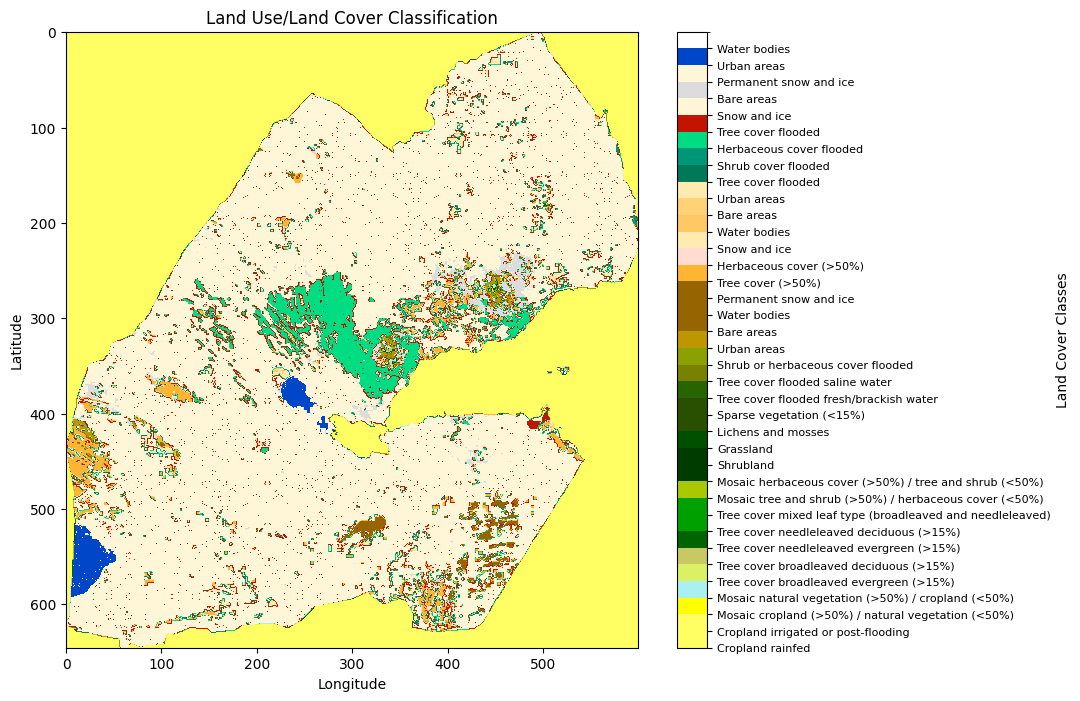

In [ ]:
# Define the color palette and class values
color_palette = [
    '#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

class_names = [
    "Cropland rainfed", "Cropland irrigated or post-flooding", "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)", "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)", "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)", "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)", "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland", "Grassland", "Lichens and mosses", "Sparse vegetation (<15%)", "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water", "Shrub or herbaceous cover flooded", "Urban areas", "Bare areas",
    "Water bodies", "Permanent snow and ice", "Tree cover (>50%)", "Herbaceous cover (>50%)", "Snow and ice",
    "Water bodies", "Bare areas", "Urban areas", "Tree cover flooded", "Shrub cover flooded",
    "Herbaceous cover flooded", "Tree cover flooded", "Snow and ice", "Bare areas", "Permanent snow and ice",
    "Urban areas", "Water bodies"
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

# Path to your TIFF file
tiff_file_path = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Djibouti_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path

# Open the TIFF file using rasterio
with rasterio.open(tiff_file_path) as src:
    # Read the entire dataset
    data = src.read(1)  # Reading only the first band, adjust if needed

    # Get the metadata
    profile = src.profile

    # Get the coordinates
    transform = src.transform
    x_coords = np.arange(profile['width']) * transform[0] + transform[2]
    y_coords = np.arange(profile['height']) * transform[4] + transform[5]

# Create a DataArray from the raster data
da = xr.DataArray(
    data,
    dims=("y", "x"),
    coords={
        "y": y_coords,
        "x": x_coords,
    },
    attrs=profile,
)

# Convert the DataArray to a Dataset
ds = xr.Dataset({"raster": da})

# Create a custom colormap
cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

# Plotting the raster data with the custom colormap
plt.figure(figsize=(10, 8))
im = plt.imshow(ds.raster, cmap=cmap, norm=norm)

# Create a colorbar with custom tick labels
cbar = plt.colorbar(im, boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
cbar.ax.set_yticklabels(class_names, fontsize=8)
cbar.ax.set_ylabel('Land Cover Classes')

plt.title('Land Use/Land Cover Classification')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

Copernicus Climate Change Service, Climate Data Store, (2019): Land cover classification gridded maps from 1992 to present derived from satellite observation. Copernicus Climate Change Service (C3S) Climate Data Store (CDS). DOI: 10.24381/cds.006f2c9a (Accessed on DD-MMM-YYYY)

In [ ]:
# Define the class names, color palette and class values
class_names = [
    "Nothing",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland rainfed",
    "Cropland irrigated or post-flooding",
    "Mosaic cropland (>50%) / natural vegetation (<50%)",
    "Mosaic natural vegetation (>50%) / cropland (<50%)",
    "Tree cover broadleaved evergreen (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover broadleaved deciduous (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved evergreen (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover needleleaved deciduous (>15%)",
    "Tree cover mixed leaf type (broadleaved and needleleaved)",
    "Mosaic tree and shrub (>50%) / herbaceous cover (<50%)",
    "Mosaic herbaceous cover (>50%) / tree and shrub (<50%)",
    "Shrubland",
    "Shrubland",
    "Shrubland",
    "Grassland",
    "Lichens and mosses",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Sparse vegetation (<15%)",
    "Tree cover flooded fresh/brackish water",
    "Tree cover flooded saline water",
    "Shrub or herbaceous cover flooded",
    "Urban areas",
    "Bare areas",
    "Bare areas",
    "Bare areas",
    "Water bodies",
    "Permanent snow and ice"
]

color_palette = [
    '#ffffff','#ffff64', '#ffff64', '#ffff00', '#aaf0f0', '#dcf064', '#c8c864', '#006400',
    '#00a000', '#00a000', '#aac800', '#003c00', '#003c00', '#005000', '#285000',
    '#285000', '#286400', '#788200', '#8ca000', '#be9600', '#966400', '#966400',
    '#966400', '#ffb432', '#ffdcd2', '#ffebaf', '#ffc864', '#ffd278', '#ffebaf',
    '#00785a', '#009678', '#00dc82', '#c31400', '#fff5d7', '#dcdcdc', '#fff5d7',
    '#0046c8', '#ffffff'
]

class_values = [
    0, 10, 11, 12, 20, 30, 40, 50, 60, 61, 62, 70, 71, 72, 80, 81, 82, 90,
    100, 110, 120, 121, 122, 130, 140, 150, 151, 152, 153, 160, 170, 180, 190,
    200, 201, 202, 210, 220
]

# Ensure the number of colors matches the number of class values
assert len(color_palette) == len(class_values), "The number of colors must match the number of class values"
assert len(class_names) == len(class_values), "The number of class names must match the number of class values"

# Paths to your TIFF files
tiff_file_path_before = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Nigeria_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path
tiff_file_path_after = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Nigeria_LULC_2002_lccs_class_the_year_after_disaster.tif'  # Replace with your actual path

In [ ]:
# Open the before disaster TIFF file using rasterio
with rasterio.open(tiff_file_path_before) as src_before:
    data_before = src_before.read(1)
    profile_before = src_before.profile
    transform_before = src_before.transform
    x_coords_before = np.arange(profile_before['width']) * transform_before[0] + transform_before[2]
    y_coords_before = np.arange(profile_before['height']) * transform_before[4] + transform_before[5]

# Open the after disaster TIFF file using rasterio
with rasterio.open(tiff_file_path_after) as src_after:
    data_after = src_after.read(1)
    profile_after = src_after.profile
    transform_after = src_after.transform
    x_coords_after = np.arange(profile_after['width']) * transform_after[0] + transform_after[2]
    y_coords_after = np.arange(profile_after['height']) * transform_after[4] + transform_after[5]

# Ensure that the datasets are aligned
assert data_before.shape == data_after.shape, "The dimensions of the two rasters do not match."

# Calculate change detection
change_detection = data_after - data_before

# Calculate change detection statistics for each class
change_stats = {}
for value in class_values:
    change_stats[value] = {
        "name": class_names[class_values.index(value)],
        "count_before": np.sum(data_before == value),
        "count_after": np.sum(data_after == value),
        "change": np.sum(change_detection == value)
    }

# Print change detection statistics
for value, stats in change_stats.items():
    print(f"Class {value} ({stats['name']}):")
    print(f"  Count Before: {stats['count_before']}")
    print(f"  Count After: {stats['count_after']}")
    print(f"  Change: {stats['change']}")
    print()

# Visualize change detection
plt.figure(figsize=(10, 8))

# custom colors
cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

# plot the image (the change)
im = plt.imshow(change_detection, cmap=cmap, norm=norm)
cbar = plt.colorbar(im, boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
cbar.ax.set_yticklabels(class_names, fontsize=8)
cbar.ax.set_ylabel('Land Cover Classes')
plt.title('Change Detection: Land Use/Land Cover')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [ ]:
def calculate_change_stats(data_before, data_after):
    """Calculate change detection statistics between two datasets."""
    change_stats = {}
    for value in class_values:
        count_before = np.sum(data_before == value)
        count_after = np.sum(data_after == value)
        change = count_after - count_before
        change_type = "increase" if change > 0 else "decrease" if change < 0 else "no change"
        change_stats[value] = {
            "name": class_names[class_values.index(value)],
            "count_before": count_before,
            "count_after": count_after,
            "change": change,
            "change_type": change_type
        }
    return change_stats

def process_raster_files(before_path, after_path):
    """Process raster files and return change statistics."""
    with rasterio.open(before_path) as src_before:
        data_before = src_before.read(1)

    with rasterio.open(after_path) as src_after:
        data_after = src_after.read(1)

    assert data_before.shape == data_after.shape, "The dimensions of the two rasters do not match."

    return calculate_change_stats(data_before, data_after)

# Directory containing subfolders named after years
root_directory = '/content/drive/MyDrive/Project files/clipped_rasters/'  # Replace with your actual path

# Initialize an empty DataFrame
df_columns = ["country", "year", "class_value", "class_name", "count_before", "count_after", "change", "change_type"]
df_list = []

# Loop over the directory structure from 2000 to 2018
for year in range(2000, 2019):
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        print(f"Processing year: {year}")
        for filename in os.listdir(year_path):
            if filename.endswith('_lccs_class_the_year_before_disaster.tif'):
                country = filename.split('_')[0]
                before_path = os.path.join(year_path, filename)

                # Extract the year from the filename and calculate the after year
                parts = filename.split('_')
                before_year = int(parts[2])
                after_year = before_year + 2
                parts[2] = str(after_year)
                after_filename = '_'.join(parts).replace('the_year_before', 'the_year_after')
                after_path = os.path.join(year_path, after_filename)

                print(f"Processing country: {country}")
                print(f"Before disaster file: {before_path}")
                print(f"After disaster file: {after_path}")

                if os.path.exists(before_path) and os.path.exists(after_path):
                    change_stats = process_raster_files(before_path, after_path)

                    for value, stats in change_stats.items():
                        df_list.append({
                            "country": country,
                            "year": year,
                            "class_value": value,
                            "class_name": stats["name"],
                            "count_before": stats["count_before"],
                            "count_after": stats["count_after"],
                            "change": stats["change"],
                            "change_type": stats["change_type"]
                        })
                    print(f"Processing for country: {country} in year: {year} is done.")
                else:
                    print(f"Missing file for country: {country} in year: {year}")

# Create a DataFrame from the list
df = pd.DataFrame(df_list)

# Display the DataFrame
print(df)

In [ ]:
df_urban = df[df["class_name"]== "Urban areas"]
df_urban

,country,year,class_value,class_name,count_before,count_after,change,change_type
31,Botswana,2000,190,Urban areas,2463,2606,143,increase
68,Madagascar,2000,190,Urban areas,3686,3942,256,increase
105,Morocco,2000,190,Urban areas,15306,16615,1309,increase
142,Mozambique,2000,190,Urban areas,4268,4733,465,increase
179,Niger,2000,190,Urban areas,1087,1113,26,increase
...,...,...,...,...,...,...,...,...
11168,Sudan,2018,190,Urban areas,17688,21457,3769,increase
11205,Nigeria,2018,190,Urban areas,76190,80907,4717,increase
11242,Rwanda,2018,190,Urban areas,1511,1530,19,increase
11279,Malawi,2018,190,Urban areas,4248,4509,261,increase


In [ ]:
def calculate_change_stats(data_before, data_after):
    """Calculate change detection statistics between two datasets."""
    change_stats = {}
    for value in class_values:
        count_before = np.sum(data_before == value)
        count_after = np.sum(data_after == value)
        change = count_after - count_before
        change_type = "increase" if change > 0 else "decrease" if change < 0 else "no change"
        change_stats[value] = {
            "name": class_names[class_values.index(value)],
            "count_before": count_before,
            "count_after": count_after,
            "change": change,
            "change_type": change_type
        }
    return change_stats

def process_raster_files(before_path, after_path):
    """Process raster files and return change statistics and difference raster."""
    with rasterio.open(before_path) as src_before:
        data_before = src_before.read(1)

    with rasterio.open(after_path) as src_after:
        data_after = src_after.read(1)

    assert data_before.shape == data_after.shape, "The dimensions of the two rasters do not match."

    change_stats = calculate_change_stats(data_before, data_after)
    difference_raster = data_after - data_before

    return change_stats, difference_raster

def plot_difference_raster(difference_raster, country, year, class_name=None):
    """Plot the difference raster to visualize changes."""
    plt.figure(figsize=(10, 8))

    if class_name:
        class_index = class_names.index(class_name)
        mask = (difference_raster == class_values[class_index])
        masked_diff = np.where(mask, difference_raster, np.nan)
        cmap = ListedColormap([color_palette[class_index]])
        norm = BoundaryNorm([class_values[class_index], class_values[class_index] + 1], cmap.N)
        plt.imshow(masked_diff, cmap=cmap, norm=norm)
    else:
        cmap = ListedColormap(color_palette)
        norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)
        plt.imshow(difference_raster, cmap=cmap, norm=norm)

    plt.colorbar(boundaries=class_values + [class_values[-1] + 1], ticks=class_values)
    title = f'Change Detection for {country} in {year}'
    if class_name:
        title += f' for {class_name}'
    plt.title(title)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

# Directory containing subfolders named after years
root_directory = '/content/drive/MyDrive/Project files/clipped_rasters/'  # Replace with your actual path

# Initialize an empty DataFrame
df_columns = ["country", "year", "class_value", "class_name", "count_before", "count_after", "change", "change_type"]
df_list = []

# Loop over the directory structure from 2000 to 2018
for year in range(2000, 2019):
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        print(f"Processing year: {year}")
        for filename in os.listdir(year_path):
            if filename.endswith('_lccs_class_the_year_before_disaster.tif'):
                country = filename.split('_')[0]
                before_path = os.path.join(year_path, filename)

                # Extract the year from the filename and calculate the after year
                parts = filename.split('_')
                before_year = int(parts[2])
                after_year = before_year + 2
                parts[2] = str(after_year)
                after_filename = '_'.join(parts).replace('the_year_before', 'the_year_after')
                after_path = os.path.join(year_path, after_filename)

                print(f"Processing country: {country}")
                print(f"Before disaster file: {before_path}")
                print(f"After disaster file: {after_path}")

                if os.path.exists(before_path) and os.path.exists(after_path):
                    change_stats, difference_raster = process_raster_files(before_path, after_path)

                    for value, stats in change_stats.items():
                        df_list.append({
                            "country": country,
                            "year": year,
                            "class_value": value,
                            "class_name": stats["name"],
                            "count_before": stats["count_before"],
                            "count_after": stats["count_after"],
                            "change": stats["change"],
                            "change_type": stats["change_type"]
                        })
                    print(f"Processing for country: {country} in year: {year} is done.")

                    # Plot the difference raster for visualizing changes
                    plot_difference_raster(difference_raster, country, year)
                else:
                    print(f"Missing file for country: {country} in year: {year}")

# Create a DataFrame from the list
df = pd.DataFrame(df_list)

# Display the DataFrame
print(df)

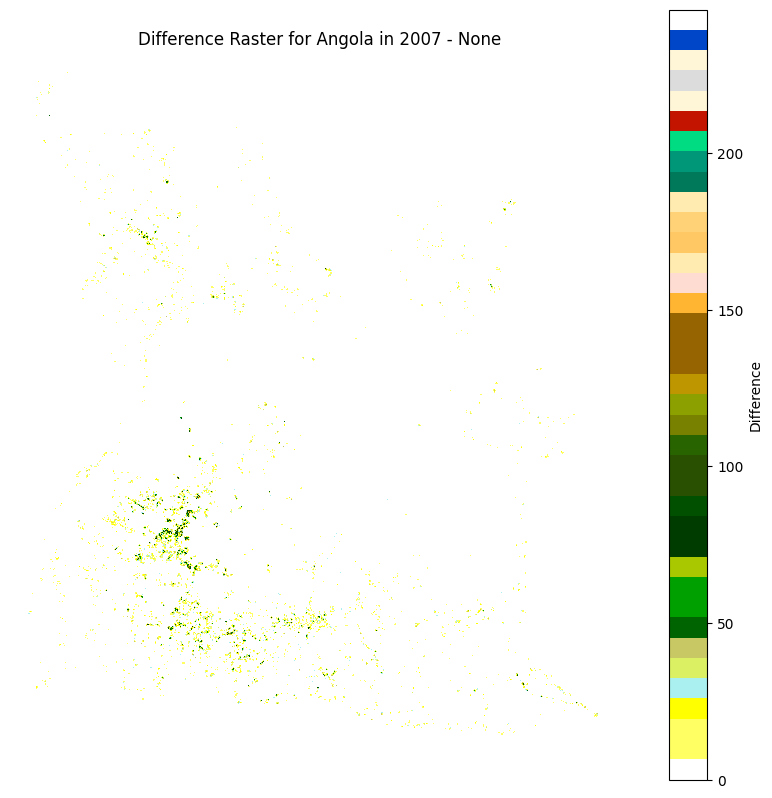

In [ ]:
def plot_class_difference(root_directory, country, year, class_name=None):
    """Plot the difference for a specified country, year, and class name."""
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        before_filename = f'{country}_LULC_{year -1}_lccs_class_the_year_before_disaster.tif'
        after_filename = f'{country}_LULC_{year + 1}_lccs_class_the_year_after_disaster.tif'
        before_path = os.path.join(year_path, before_filename)
        after_path = os.path.join(year_path, after_filename)

        if os.path.exists(before_path) and os.path.exists(after_path):
            _, difference_raster = process_raster_files(before_path, after_path)
            plot_difference_raster(difference_raster, country, year, class_name)
        else:
            print(f"Missing file for country: {country} in year: {year}")
    else:
        print(f"Year folder {year} does not exist.")

plot_class_difference('/content/drive/MyDrive/Project files/clipped_rasters/', 'Angola', 2007)

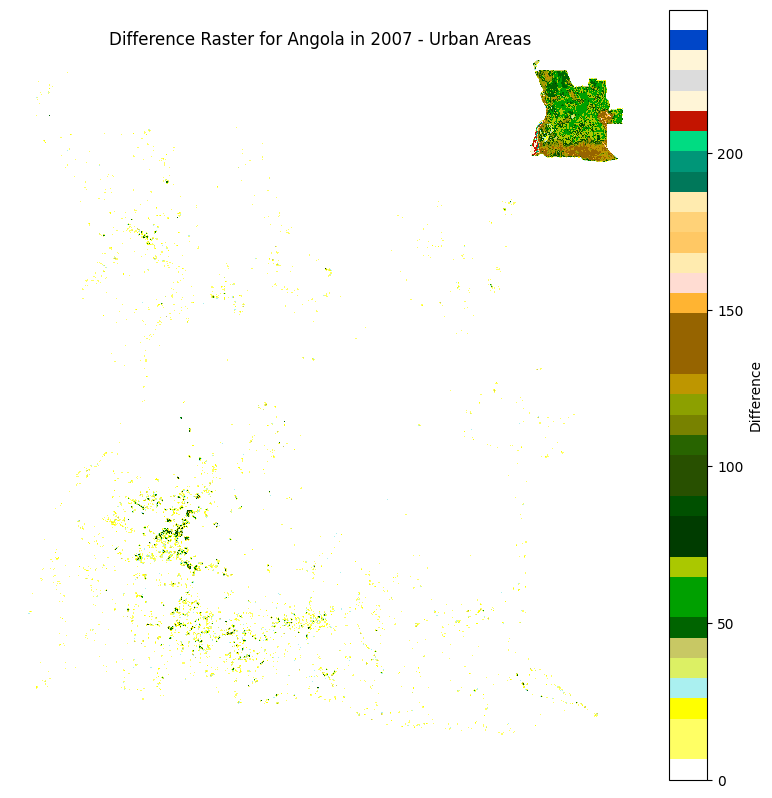

In [ ]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import rasterio

cmap = ListedColormap(color_palette)
norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)

def process_raster_files(before_path, after_path):
    """Process the raster files and compute the difference."""
    with rasterio.open(before_path) as src_before, rasterio.open(after_path) as src_after:
        before_data = src_before.read(1)
        after_data = src_after.read(1)
        difference_data = after_data - before_data
    return before_data, difference_data

def plot_difference_raster(difference_raster, country, year, class_name=None):
    """Plot the difference raster."""
    cmap = ListedColormap(color_palette)
    norm = BoundaryNorm(class_values + [class_values[-1] + 1], cmap.N)
    plt.figure(figsize=(10, 10))
    plt.imshow(difference_raster, cmap=cmap)
    plt.title(f'Difference Raster for {country} in {year} - {class_name}')
    plt.colorbar(label='Difference')
    plt.axis('off')

def plot_class_difference(root_directory, country, year, class_name=None, cmap=cmap, norm=norm):
    """Plot the difference for a specified country, year, and class name."""
    year_path = os.path.join(root_directory, str(year))
    if os.path.isdir(year_path):
        before_filename = f'{country}_LULC_{year - 1}_lccs_class_the_year_before_disaster.tif'
        after_filename = f'{country}_LULC_{year + 1}_lccs_class_the_year_after_disaster.tif'
        before_path = os.path.join(year_path, before_filename)
        after_path = os.path.join(year_path, after_filename)

        if os.path.exists(before_path) and os.path.exists(after_path):
            before_raster, difference_raster = process_raster_files(before_path, after_path)
            plot_difference_raster(difference_raster, country, year, class_name)

            # Add inset showing the area without change
            ax_inset = inset_axes(plt.gca(), width="15%", height="15%", loc="upper right")
            ax_inset.imshow(before_raster, cmap=cmap, norm=norm)
            ax_inset.axis('off')
            plt.show()
        else:
            print(f"Missing file for country: {country} in year: {year}")
    else:
        print(f"Year folder {year} does not exist.")

# Usage example
plot_class_difference('/content/drive/MyDrive/Project files/clipped_rasters/', 'Angola', 2007, 'Urban Areas')

In [ ]:
# Define the path to your TIFF file on Google Drive
tiff_drive_path = '/content/drive/MyDrive/Project files/clipped_rasters/2001/Djibouti_LULC_2000_lccs_class_the_year_before_disaster.tif'  # Replace with your actual path

image = ee.Image("projects/aims-ai2324-std-aness-9fl/assets/Djibouti_LULC_2000_lccs_class_the_year_before_disaster")

## Personal Code

In [ ]:
filename = 'data/external/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc'
# Create Xarray Dataset
ds = xr.open_dataset(filename)

In [ ]:
ds.dims

Frozen({'time': 1, 'lat': 64800, 'lon': 129600, 'bounds': 2})

In [ ]:
ds.data_vars

Data variables:
    lccs_class           (time, lat, lon) uint8 ...
    processed_flag       (time, lat, lon) float32 ...
    current_pixel_state  (time, lat, lon) float32 ...
    observation_count    (time, lat, lon) uint16 ...
    change_count         (time, lat, lon) uint8 ...
    crs                  int32 ...
    lat_bounds           (lat, bounds) float64 ...
    lon_bounds           (lon, bounds) float64 ...
    time_bounds          (time, bounds) datetime64[ns] ...

In [ ]:
da

<xarray.DataArray 'lccs_class' (time: 1, lat: 64800, lon: 129600)>
[8398080000 values with dtype=uint8]
Coordinates:
  * lat      (lat) float64 90.0 90.0 89.99 89.99 ... -89.99 -89.99 -90.0 -90.0
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * time     (time) datetime64[ns] 2000-01-01
Attributes:
    standard_name:        land_cover_lccs
    flag_colors:          #ffff64 #ffff64 #ffff00 #aaf0f0 #dcf064 #c8c864 #00...
    long_name:            Land cover class defined in LCCS
    valid_min:            1
    valid_max:            220
    ancillary_variables:  processed_flag current_pixel_state observation_coun...
    flag_meanings:        no_data cropland_rainfed cropland_rainfed_herbaceou...
    flag_values:          [  0  10  11  12  20  30  40  50  60  61  62  70  7...

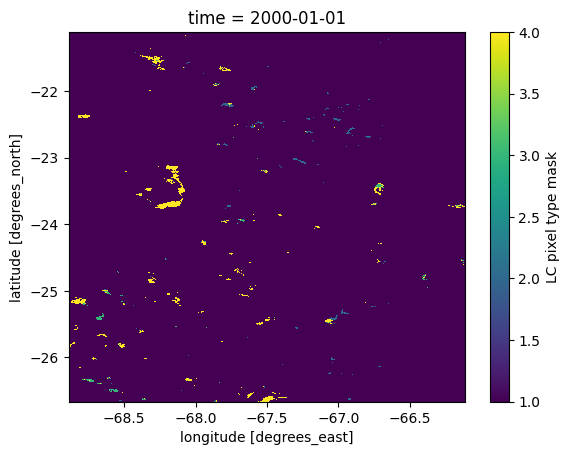

In [ ]:
ds['current_pixel_state'][0,40000:42000,40000:41000].plot()

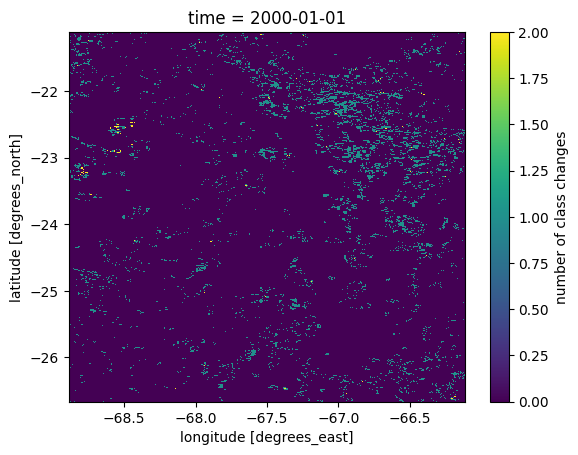

In [ ]:
ds['change_count'][0,40000:42000,40000:41000].plot()

**lccs_class (time, lat, lon) uint8:**

Description: Land Cover Classification System (LCCS) class codes. This variable contains the land cover classification for each pixel in the dataset.\
Use for Plotting: Yes, this is essential for plotting the land cover map.

**processed_flag (time, lat, lon) float32:**

Description: Flags indicating the processing status of each pixel. This could be used to mark pixels that have been processed in certain ways.\
Use for Plotting: Not typically used for basic land cover plotting but may be useful for quality control.

**current_pixel_state (time, lat, lon) float32:**

Description: Indicates the current state of each pixel, possibly related to vegetation, water, or other states.\
Use for Plotting: This might be useful depending on the specific analysis but is not necessary for a basic land cover map.

**observation_count (time, lat, lon) uint16:**

Description: The number of observations for each pixel. This could indicate the number of times the pixel has been observed or measured.\
Use for Plotting: Generally not needed for basic land cover plotting but could be useful for data quality analysis.

**change_count (time, lat, lon) uint8:**

Description: The number of changes detected for each pixel. This could indicate how often the land cover type has changed.\
Use for Plotting: Not needed for a static land cover map but could be useful for change detection analysis.

**crs () int32:**

Description: Coordinate Reference System information. This specifies the spatial reference system used in the dataset.\
Use for Plotting: Yes, this is necessary to correctly plot the map, as it defines how the coordinates should be interpreted.

**lat_bounds (lat, bounds) float64:**

Description: Latitude bounds for each latitude value. This provides the edges of each latitude cell.\
Use for Plotting: Not directly needed for plotting the map but could be useful for understanding the spatial resolution.

**lon_bounds (lon, bounds) float64:**

Description: Longitude bounds for each longitude value. This provides the edges of each longitude cell.\
Use for Plotting: Not directly needed for plotting the map but could be useful for understanding the spatial resolution.

**time_bounds (time, bounds) datetime64[ns]:**

Description: Time bounds for each time value. This provides the start and end times for the time periods covered.\
Use for Plotting: Not needed for a single time point map but useful for time series analysis.

**Variables Needed for Plotting the Map
To plot a basic land cover map, you will primarily need the following variables:**

**lccs_class (time, lat, lon) uint8:**

This variable provides the land cover classification for each pixel and is the main data you want to visualize on the map.

Coordinates:

**lat (lat) float64:** Latitude values.

**lon (lon) float64:** Longitude values.

**time (time) datetime64[ns]:** Time values (if you are dealing with a time series, though for a single map you might just pick one time point).

**crs () int32:** This variable is necessary to understand the spatial reference system and ensure that the map is plotted in the correct location and projection.

## Convert and assign crs to the file

In [ ]:
%%capture
!pip install dask cupy xarray rasterio tqdm Cartopy localtileserver

In [ ]:
%%capture
!apt-get install -y gdal-bin

In [ ]:
import os
import gc
import logging
import numpy as np
import subprocess
import rasterio
from rasterio.transform import from_bounds
from rasterio.crs import CRS
import xarray as xr
import dask.array as da
from tqdm.auto import tqdm
from dask.distributed import Client, progress

# Try to import CuPy for GPU processing, default to NumPy for CPU
try:
    import cupy as cp
    gpu_available = cp.cuda.runtime.getDeviceCount() > 0
except ImportError:
    gpu_available = False

In [ ]:
# Open the NetCDF file with Dask
filename = "/content/CERI/data/external/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc"
ds = xr.open_dataset(filename, chunks={'time': 1, 'lat': 10000, 'lon': 20000})
variables = ["lccs_class"]

In [ ]:
# Attempt to extract CRS information from dataset attributes
crs_attr = ds.attrs.get('crs') or ds.attrs.get('spatial_ref', 'EPSG:4326')
if isinstance(crs_attr, str) and crs_attr.startswith('EPSG:'):
    epsg_code = int(crs_attr.split(':')[1])
    crs = CRS.from_epsg(epsg_code)
else:
    crs = CRS.from_epsg(4326)  # Default to WGS84 if no valid CRS information is found

In [ ]:
# Print the current working directory and log file path
log_file_path = os.path.join(os.getcwd(), 'processing_log.log')
print(f"Log file will be stored at: {log_file_path}")

# Configure logging to file
logging.basicConfig(filename=log_file_path, level=logging.INFO, format='%(asctime)s %(message)s', filemode='w')
logging.info(f"GPU available: {gpu_available}")

Log file will be stored at: /content/CERI/processing_log.log


In [ ]:
def process_chunk(chunk, variable_name, chunk_index, crs):
    # Generate a temporary file name for the chunk
    tif = f"temp_{variable_name}_chunk_{chunk_index}.tif"
    tif_with_crs = f"temp_{variable_name}_chunk_{chunk_index}_crs.tif"

    # Process chunk on GPU if available
    if gpu_available:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on GPU...")
        chunk_array = cp.array(chunk)
        if chunk_array.ndim == 2:
            chunk_array = cp.expand_dims(chunk_array, axis=0)
        logging.info(f"Moving chunk {chunk_index} for variable {variable_name} back to CPU memory...")
        chunk_array_cpu = cp.asnumpy(chunk_array)
    else:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on CPU...")
        chunk_array_cpu = np.array(chunk)
        if chunk_array_cpu.ndim == 2:
            chunk_array_cpu = np.expand_dims(chunk_array_cpu, axis=0)

    # Determine the transform and metadata
    transform = from_bounds(-180, -90, 180, 90, chunk_array_cpu.shape[2], chunk_array_cpu.shape[1])
    metadata = {
        'driver': 'GTiff',
        'height': chunk_array_cpu.shape[1],
        'width': chunk_array_cpu.shape[2],
        'count': chunk_array_cpu.shape[0],
        'dtype': chunk_array_cpu.dtype,
        'transform': transform
    }

    # Write the chunk to a temporary TIFF file
    with rasterio.open(tif, 'w', **metadata) as dst:
        dst.write(chunk_array_cpu)

    # Assign CRS using gdal_translate
    subprocess.run(['gdal_translate', '-a_srs', str(crs), tif, tif_with_crs])

    # Remove the original temporary file
    os.remove(tif)

    # Clear memory
    del chunk_array_cpu
    gc.collect()

    return tif_with_crs

# Extract variable data and calculate the number of chunks
variable_data = {var: ds[var].data for var in variables}
num_chunks = variable_data[variables[0]].numblocks
total_chunks = num_chunks[0] * num_chunks[1] * num_chunks[2]

# Create an iterable of chunk indices
chunk_indices = [(t, lat, lon) for t in range(num_chunks[0]) for lat in range(num_chunks[1]) for lon in range(num_chunks[2])]

# Track temporary files for each chunk and variable
temp_files_dict = {var: [] for var in variables}

# Process each chunk of all variables
for chunk_index in tqdm(chunk_indices, desc="Processing all chunks", total=total_chunks):
    time_index, lat_index, lon_index = chunk_index
    for variable in variables:
        chunk = variable_data[variable].blocks[time_index, lat_index, lon_index].compute()  # Compute the chunk to get the actual data
        temp_tif_with_crs = process_chunk(chunk, variable, f"{time_index}_{lat_index}_{lon_index}", crs)
        temp_files_dict[variable].append(temp_tif_with_crs)

# Create a single multi-band TIFF file
output_tif = "year_2000_LULC_combined.tif"
with rasterio.open(temp_files_dict[variables[0]][0]) as src0:
    meta = src0.meta
    meta.update(count=len(variables))

with rasterio.open(output_tif, 'w', **meta) as dst:
    for band_index, variable in enumerate(variables, start=1):
        for temp_file in tqdm(temp_files_dict[variable], desc=f"Merging {variable} chunks", total=len(temp_files_dict[variable])):
            with rasterio.open(temp_file) as src:
                dst.write_band(band_index, src.read(1))

# Clear temporary files
for temp_files in temp_files_dict.values():
    for temp_file in temp_files:
        os.remove(temp_file)

# Clear memory after processing all variables
del variable_data
gc.collect()

Processing all chunks:   0%|          | 0/49 [00:00<?, ?it/s]

Merging lccs_class chunks:   0%|          | 0/49 [00:00<?, ?it/s]

40

In [ ]:
ds = xr.open_dataset('/content/CERI/year_2000_LULC_combined.tif')
ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 20000, y: 10000)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -180.0 -180.0 -179.9 ... 180.0 180.0 180.0
  * y            (y) float64 89.99 89.97 89.95 89.94 ... -89.95 -89.97 -89.99
    spatial_ref  int64 ...
Data variables:
    band_data    (band, y, x) float32 ...

### Failed experiment

In [ ]:
import os
import gc
import numpy as np
import cupy as cp
import logging
import rasterio
from rasterio.transform import from_bounds
from tqdm import tqdm
import dask.array as da

def process_chunk(chunk, variable_name, chunk_index, crs, shift_lon=False):
    # Generate a temporary file name for the chunk
    tif = f"temp_{variable_name}_chunk_{chunk_index}.tif"

    # Check if GPU is available
    if gpu_available:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on GPU...")
        chunk_array = cp.array(chunk)
        if chunk_array.ndim == 2:
            chunk_array = cp.expand_dims(chunk_array, axis=0)
        logging.info(f"Moving chunk {chunk_index} for variable {variable_name} back to CPU memory...")
        chunk_array_cpu = cp.asnumpy(chunk_array)
    else:
        logging.info(f"Processing chunk {chunk_index} for variable {variable_name} on CPU...")
        chunk_array_cpu = np.array(chunk)
        if chunk_array_cpu.ndim == 2:
            chunk_array_cpu = np.expand_dims(chunk_array_cpu, axis=0)

    # Determine the transform and metadata
    transform = from_bounds(-180, -90, 180, 90, chunk_array_cpu.shape[2], chunk_array_cpu.shape[1])
    metadata = {
        'driver': 'GTiff',
        'height': chunk_array_cpu.shape[1],
        'width': chunk_array_cpu.shape[2],
        'count': chunk_array_cpu.shape[0],
        'dtype': chunk_array_cpu.dtype,
        'transform': transform,
        'crs': crs
    }

    # Write the chunk to a temporary TIFF file
    with rasterio.open(tif, 'w', **metadata) as dst:
        dst.write(chunk_array_cpu)

    # Clear memory
    del chunk_array_cpu
    gc.collect()

    return tif

# Assume `ds` is the opened xarray dataset and `variables` is the list of variable names
variable_data = {var: ds[var].data for var in variables}
num_chunks = variable_data[variables[0]].numblocks
total_chunks = num_chunks[0] * num_chunks[1] * num_chunks[2]

# Create an iterable of chunk indices
chunk_indices = [(t, lat, lon) for t in range(num_chunks[0]) for lat in range(num_chunks[1]) for lon in range(num_chunks[2])]

# Track temporary files for each chunk and variable
temp_files_dict = {var: [] for var in variables}

# Process each chunk of all variables
for chunk_index in tqdm(chunk_indices, desc="Processing all chunks", total=total_chunks):
    time_index, lat_index, lon_index = chunk_index
    for variable in variables:
        chunk = variable_data[variable].blocks[time_index, lat_index, lon_index].compute()  # Compute the chunk to get the actual data
        temp_tif = process_chunk(chunk, variable, f"{time_index}_{lat_index}_{lon_index}", crs)
        temp_files_dict[variable].append(temp_tif)

# Create a single multi-band TIFF file
output_tif = "year_2000_LULC_combined.tif"
with rasterio.open(temp_files_dict[variables[0]][0]) as src0:
    meta = src0.meta
    meta.update(count=len(variables))

with rasterio.open(output_tif, 'w', **meta) as dst:
    for band_index, variable in enumerate(variables, start=1):
        for temp_file in tqdm(temp_files_dict[variable], desc=f"Merging {variable} chunks", total=len(temp_files_dict[variable])):
            with rasterio.open(temp_file) as src:
                dst.write_band(band_index, src.read(1))

# Clear temporary files
for temp_files in temp_files_dict.values():
    for temp_file in temp_files:
        os.remove(temp_file)

# Clear memory after processing all variables
del variable_data
gc.collect()

In [ ]:
m = geemap.Map(layer_ctrl=True)

m.add_raster('/content/year_2000_LULC_combined.tif', palette="coolwarm", layer_name="lccs_class")
m

## Xarray

In [ ]:
!pip install -U netCDF4
!pip install -q earthpy rioxarray cftime h5pyd Bottleneck # install in colab
!pip install rasterio # for read HDF files

import warnings

import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import earthpy as et
import random
import numpy as np
import pandas as pd

warnings.simplefilter('ignore')

In [ ]:
# Open the NetCDF file using netCDF4
file_path = '/content/CERI/data/external/ESACCI-LC-L4-LCCS-Map-300m-P1Y-2000-v2.0.7cds.nc'
ds = xr.open_dataset(file_path)

In [ ]:
variable_data = ds['lccs_class']
variable_data[:2]

# LandScan Africa

## Download the dataset


In [ ]:
# Download & unzip the necessary data
!python src/data/download_data.py --type processed

Downloading...
From (original): https://drive.google.com/uc?id=17GVeNmIU-TYyuN-MtDeci1V64KHul_KA
From (redirected): https://drive.google.com/uc?id=17GVeNmIU-TYyuN-MtDeci1V64KHul_KA&confirm=t&uuid=9cd10dbd-7dd7-4db4-8200-7e12f04bc3b1
To: /content/CERI/data/external/Landscan_data/processed/africa/Landscan_clipped_Africa.zip
100% 180M/180M [00:01<00:00, 120MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=17oOHb70IIS8vGXtyZLz50wnTp7FQA1lP
From (redirected): https://drive.google.com/uc?id=17oOHb70IIS8vGXtyZLz50wnTp7FQA1lP&confirm=t&uuid=eae0bd9c-30c4-4580-8230-d12723903608
To: /content/CERI/data/external/Landscan_data/processed/country_level/Landscan_clipped_country_level.zip
100% 115M/115M [00:01<00:00, 72.4MB/s]
Unzipping: 100% 20/20 [01:22<00:00,  4.11s/file]
Unzipping: 100% 570/570 [00:22<00:00, 25.02file/s]
All files have been downloaded, extracted, and zip files deleted successfully.


## Africa level: Change in population

In [ ]:
# @title Parameters
import os
import rasterio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Define the folder containing the TIFF files
tiff_folder = '/content/CERI/data/external/Landscan_data/processed/africa'
disasters_excel = '/content/CERI/data/processed/Disasters_in_africa_2000_2018_processed.xlsx'

# Get the list of TIFF files sorted by year
tiff_files = sorted([f for f in os.listdir(tiff_folder) if f.endswith('.tif')])

# Extract years from filenames and sort the files accordingly
years = sorted([int(f.split('-')[2]) for f in tiff_files])
tiff_files = [os.path.join(tiff_folder, f) for f in tiff_files]

# Function to calculate the population count from a TIFF file
def get_population_count(tiff_file):
    with rasterio.open(tiff_file) as src:
        data = src.read(1)
        return np.sum(data)

# Initialize an empty DataFrame to store population counts
population_df = pd.DataFrame(columns=['Year', 'Population'])

# Landscan Global using Google earth engine

## Continent level

In [31]:
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL").first()

# Define the SLD style for population count intervals
popcount_intervals = '''
<RasterSymbolizer>
  <ColorMap type="intervals" extended="false">
    <ColorMapEntry color="#CCCCCC" quantity="0" label="No Data"/>
    <ColorMapEntry color="#FFFFBE" quantity="5" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FEFF73" quantity="25" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FEFF2C" quantity="50" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FFAA27" quantity="100" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FF6625" quantity="500" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#FF0023" quantity="2500" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#CC001A" quantity="5000" label="Population Count (Estimate)"/>
    <ColorMapEntry color="#730009" quantity="185000" label="Population Count (Estimate)"/>
  </ColorMap>
</RasterSymbolizer>
'''

# Define the legend dictionary
legend_dict = {
    'No Data': '#CCCCCC',
    '0 - 5': '#FFFFBE',
    '6 - 25': '#FEFF73',
    '26 - 50': '#FEFF2C',
    '51 - 100': '#FFAA27',
    '101 - 500': '#FF6625',
    '501 - 2500': '#FF0023',
    '2501 - 5000': '#CC001A',
    '5001 - 185000': '#730009'
}

# Create a map
Map = geemap.Map(**africa_map_config)

# Add layers to the map
Map.add_layer(
    landscan_global.sldStyle(popcount_intervals), {}, 'Population Count Estimate 2000'
)

# Add the legend to the map
Map.add_legend(title='Population Count (Estimate)', legend_dict=legend_dict)

# Display the map
Map

Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

In [ ]:
# Compute mean, min, max, stdDev, and percentiles
mean_dict = image.reduceRegion(
    reducer=ee.Reducer.mean(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
min_max_dict = image.reduceRegion(
    reducer=ee.Reducer.minMax(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
std_dev_dict = image.reduceRegion(
    reducer=ee.Reducer.stdDev(),
    geometry=roi,
    scale=1000,
    bestEffort=True
)
percentiles_dict = image.reduceRegion(
    reducer=ee.Reducer.percentile([10, 25, 50, 75, 90]),
    geometry=roi,
    scale=1000,
    bestEffort=True
)

# sum_population = features.reduceColumns(
#     reducer=ee.Reducer.sum(),
#     selectors=['population']
# )
# mean_population = features.reduceColumns(
#     reducer=ee.Reducer.mean(),
#     selectors=['population']
# )
# min_max_population = features.reduceColumns(
#     reducer=ee.Reducer.minMax(),
#     selectors=['population']
# )
# std_dev_population = features.reduceColumns(
#     reducer=ee.Reducer.stdDev(),
#     selectors=['population']
# )

# Combine results into a summary dictionary
summary = {
    'Mean Elevation': mean_dict.getInfo(),
    'Min Elevation': min_max_dict.getInfo()['elevation_min'],
    'Max Elevation': min_max_dict.getInfo()['elevation_max'],
    'Standard Deviation of Elevation': std_dev_dict.getInfo(),
    'Elevation Percentiles': percentiles_dict.getInfo()
    # 'Total Population': sum_population.getInfo()['sum'],
    # 'Mean Population': mean_population.getInfo()['mean'],
    # 'Min Population': min_max_population.getInfo()['min'],
    # 'Max Population': min_max_population.getInfo()['max'],
    # 'Standard Deviation of Population': std_dev_population.getInfo()
}

# Print the summary
print('Statistical Summary:', summary)

In [34]:
# Get the first image from the collection for the year 2000
image_2000 = ee.Image("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000")
image_2000 = image_2000.toFloat() # Convert the image to a float type to ensure proper calculations

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)
roi = africa_shapefile.geometry().dissolve() # Define the region of interest (ROI) for Africa using the shapefile

# Define the intervals
intervals = [
    (0, 5), (5, 25), (25, 50), (50, 100),
    (100, 500), (500, 2500), (2500, 5000), (5000, 185000)
]

In [ ]:
# Create a function to split the region into smaller grids
def create_grid(geometry, rows, cols):
    bounds = geometry.bounds().coordinates().get(0).getInfo()
    lon_min, lat_min = bounds[0]
    lon_max, lat_max = bounds[2]

    lon_step = (lon_max - lon_min) / cols
    lat_step = (lat_max - lat_min) / rows

    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = ee.Geometry.Rectangle([
                [lon_min + i * lon_step, lat_min + j * lat_step],
                [lon_min + (i + 1) * lon_step, lat_min + (j + 1) * lat_step]
            ])
            grid_cells.append(cell)

    return grid_cells

# Split the region into smaller grids
grid_cells = create_grid(africa_roi, 10, 10)

# Function to calculate the total population for a given interval and grid cell
def calculate_population(image, min_value, max_value, region, scale):
    mask = image.gte(min_value).And(image.lt(max_value))
    masked_image = image.updateMask(mask)
    total_population = masked_image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Calculate population for each interval and store results
population_counts = {}
total_population_sum = 0
for min_val, max_val in intervals:
    interval_total = 0
    for cell in grid_cells:
        population = calculate_population(image_2000, min_val, max_val, cell, 1000)
        interval_total += population if population is not None else 0
    interval_label = f'{min_val}-{max_val}'
    population_counts[interval_label] = interval_total
    total_population_sum += interval_total

# Print the results
for interval, count in population_counts.items():
    print(f"Total population count for interval {interval}: {count:.2f}")

# Print the sum of the population counts
print(f"Sum of the population counts in all intervals in Africa: {total_population_sum:.2f}")

Total population count for interval 0-5: 25212476.64
Total population count for interval 5-25: 111782003.26
Total population count for interval 25-50: 74919056.01
Total population count for interval 50-100: 78546530.92
Total population count for interval 100-500: 145369558.06
Total population count for interval 500-2500: 127706405.79
Total population count for interval 2500-5000: 72047264.88
Total population count for interval 5000-185000: 224236779.76
Sum of the population counts in all intervals in Africa: 859820075.31


In [ ]:
# Function to create a grid of smaller regions
def create_grid(geometry, rows, cols):
    bounds = geometry.bounds().coordinates().get(0).getInfo()
    lon_min, lat_min = bounds[0]
    lon_max, lat_max = bounds[2]

    lon_step = (lon_max - lon_min) / cols
    lat_step = (lat_max - lat_min) / rows

    grid_cells = []
    for i in range(cols):
        for j in range(rows):
            cell = ee.Geometry.Rectangle([
                [lon_min + i * lon_step, lat_min + j * lat_step],
                [lon_min + (i + 1) * lon_step, lat_min + (j + 1) * lat_step]
            ])
            grid_cells.append(cell)

    return grid_cells

# Split the region into smaller grids
grid_cells = create_grid(africa_roi, 10, 10)  # Adjust the grid size as needed

# Function to calculate the total population for a given year and grid cell
def calculate_population(image, region, scale):
    total_population = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region,
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Initialize a DataFrame to store the results
years = list(range(2000, 2019))
population_data = []

# Calculate the population for each year and each grid cell, then aggregate the results
for year in years:
    image = landscan_global.filter(ee.Filter.eq('system:index', f'landscan-global-{year}')).first()
    if image is None:
        continue

    year_total_population = 0
    for cell in grid_cells:
        population = calculate_population(image, cell, 1000) # scale = 1000 to get more accurate results
        year_total_population += population if population is not None else 0

    population_data.append({
        'Year': year,
        'Population': year_total_population
    })

In [ ]:
# Convert the data into a pandas DataFrame
df_population = pd.DataFrame(population_data)

# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the DataFrame
print(df_population)

In [ ]:
# Check point (saved dataframe for population count over the years)
AFRICA_POP_PATH = "/content/CERI/data/processed/Africa_level_population_2000_2018.csv"

# Save the file
# df_population_africa.to_csv(AFRICA_POP_PATH, index=False)

# Load the file
df_population_africa = pd.read_csv(AFRICA_POP_PATH)
pd.options.display.float_format = '{:,.2f}'.format
df_population_africa

,Unnamed: 0,Year,Population
0,0,2000,"859,820,075.30"
1,1,2001,"878,720,050.80"
2,2,2002,"896,187,284.80"
3,3,2003,"916,226,740.10"
4,4,2004,"930,725,786.30"
5,5,2005,"952,241,238.50"
6,6,2006,"973,253,782.00"
7,7,2007,"994,688,717.90"
8,8,2008,"1,031,934,403.00"
9,9,2009,"1,051,343,733.00"


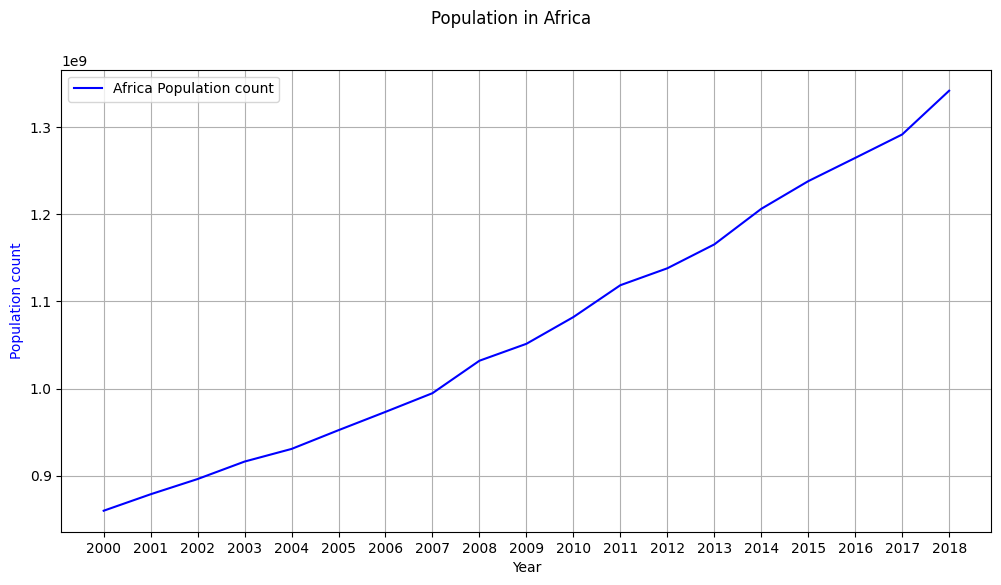

In [ ]:
# Plot the population changes and disaster counts for the specified country
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(df_population_africa['Year'].astype(str), df_population_africa['Population'], label=f"Africa Population count", color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population count', color='b')

# Title and legend
fig.suptitle(f'Population in Africa')
ax1.legend(loc='upper left')

# Grid and show
ax1.grid(True)
plt.show()

## Country level

In [ ]:
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Filter the Africa shapefile to include only the specified countries
filtered_countries = africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', countries))

In [ ]:
pop_2000 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000")
pop_2010 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2010")

# Create HTML for the legend
left_legend_html = '''
<div style="position: fixed; bottom: 50px; left: 10px; z-index: 1000; padding: 5px; border: 1px solid black;">
  <h3>Year 2000</h3>
</div>
'''

right_legend_html = '''
<div style="position: flex; bottom: 50px; right: 10px; z-index: 1000; padding: 5px; border: 1px solid black;">
  <h3>Year 2010</h3>
</div>
'''

In [ ]:
country_name = "Zimbabwe"
filtered_country = africa_shapefile.filter(ee.Filter.eq('ADM0_NAME', country_name))

# Create a map
Map = geemap.Map(height=800, width="70%")

clipped_image_2000 = pop_2000.clip(filtered_country) # Clip the landscan_global image with the country's boundary
clipped_image_2010 = pop_2010.clip(filtered_country)

left_layer = geemap.ee_tile_layer(clipped_image_2000.sldStyle(popcount_intervals), {}, "Pop count 2000")
right_layer = geemap.ee_tile_layer(clipped_image_2010.sldStyle(popcount_intervals), {}, "Pop count 2010")

# Map.add_layer(clipped_image.sldStyle(popcount_intervals), {}, 'Population Count Estimate 2000')
Map.add_layer(filtered_country.style(**{'color': 'red'}), {}, country_name)

# Add the legend to the map
Map.add_legend(title='Population Count Estimate', legend_dict=legend_dict)

# Center the map on the selected country
country_geom = filtered_country.geometry()
Map.centerObject(country_geom, zoom=7)

# Display the map
Map.split_map(left_layer, right_layer)
Map.add_html(left_legend_html)
Map.add_html(right_legend_html)
Map

Map(center=[-18.99298187251295, 29.868341570404244], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [ ]:
# Function to calculate the total population for a given year and region
def calculate_population(image, region, scale):
    total_population = image.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=region.geometry(),
        scale=scale,
        maxPixels=1e12
    ).get('b1').getInfo()
    return total_population

# Initialize a DataFrame to store the results
years = list(range(2000, 2019))
population_data = []

# Calculate the population for each country and each year, then store the results
for country in countries:
    country_feature = filtered_countries.filter(ee.Filter.eq('ADM0_NAME', country)).first()
    if country_feature is None:
        continue

    for year in years:
        image = landscan_global.filter(ee.Filter.eq('system:index', f'landscan-global-{year}')).first()
        if image is None:
            continue

        population = calculate_population(image, country_feature, 1000)
        population_data.append({
            'Country': country,
            'Year': year,
            'Population': population if population is not None else 0
        })

In [ ]:
# Convert the data into a pandas DataFrame
df_population_country_lvl = pd.DataFrame(population_data)

# Set the display format for floating-point numbers to avoid scientific notation
pd.options.display.float_format = '{:,.2f}'.format

# Print the DataFrame
print(df_population_country_lvl)

In [ ]:
# Check point
Country_LVL_POP_PATH = "/content/CERI/data/processed/Country_level_population_2000_2018.csv"

# Save the file
# df_population_country_lvl.to_csv(Country_LVL_POP_PATH, index=False)

# Load the file
df_population_country_lvl = pd.read_csv(Country_LVL_POP_PATH)
pd.options.display.float_format = '{:,.2f}'.format
df_population_country_lvl.head(3)

,Country,Year,Population
0,Zimbabwe,2000,"9,751,919.54"
1,Zimbabwe,2001,"9,707,988.09"
2,Zimbabwe,2002,"10,646,151.27"


In [ ]:
df_population_country_lvl['Country'].unique()

array(['Zimbabwe', 'Mozambique', 'Sudan', 'Malawi', 'Ethiopia',
       'Mauritania', 'Mali', 'Algeria', 'Uganda', 'Madagascar', 'Kenya',
       'Senegal', 'Angola', 'South Africa', 'Somalia', 'Comoros',
       'Burundi', 'Niger', 'Burkina Faso', 'Ghana', 'Rwanda',
       'South Sudan', 'Namibia', 'Chad', 'Zambia', 'Nigeria', 'Benin',
       'Egypt', 'Botswana'], dtype=object)

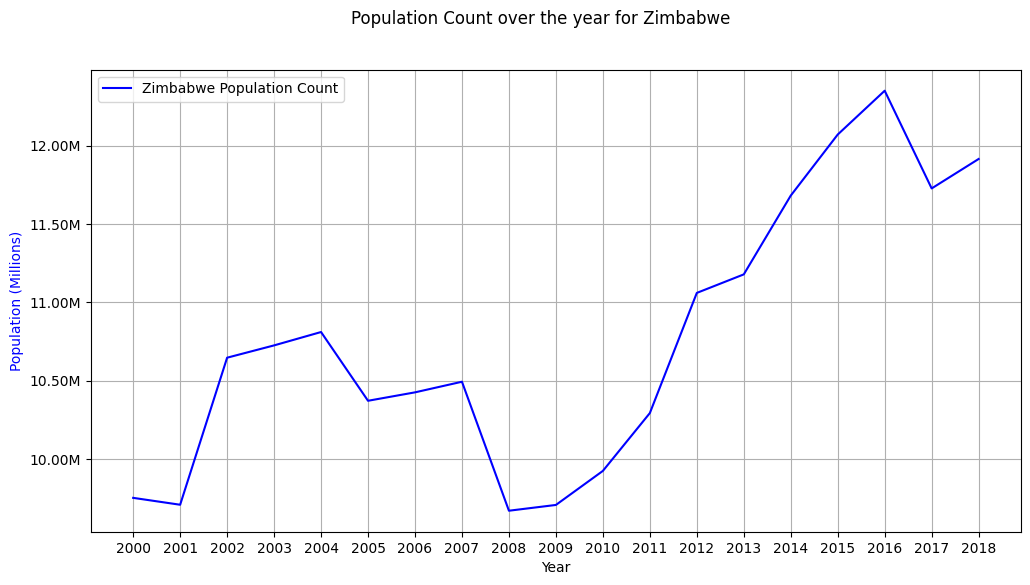

In [ ]:
from matplotlib.ticker import FuncFormatter

# Function to format the y-axis labels in millions
def millions_format(num, pos):
    return '{:,.2f}M'.format(num)

# filter the country
country = "Zimbabwe"
filtered_df_population_country_lvl = df_population_country_lvl[df_population_country_lvl['Country'] == country]

# Plot the population changes and disaster counts for the specified country
fig, ax1 = plt.subplots(figsize=(12, 6))

# Convert population to millions
population_in_millions = filtered_df_population_country_lvl['Population'] / 1e6

ax1.plot(filtered_df_population_country_lvl['Year'].astype(str), population_in_millions, label=f"{country} Population Count", color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population (Millions)', color='b')

# Formatter for y-axis
ax1.yaxis.set_major_formatter(FuncFormatter(millions_format))

# Title and legend
fig.suptitle(f'Population Count over the year for {country}')
ax1.legend(loc='upper left')

# Grid and show
ax1.grid(True)
plt.show()

## Change detection - Continent Level

## Change detection - Country Level

In [37]:
# Define the ImageCollection
landscan_global = ee.ImageCollection("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL")

# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Filter the Africa shapefile to include only the specified countries
filtered_countries = africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', countries))

# Define the intervals
intervals = [
    (0, 5), (5, 25), (25, 50), (50, 100),
    (100, 500), (500, 2500), (2500, 5000), (5000, 185000)
]

In [38]:
# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    # Calculate the total change in population
    scale = 1000  # Scale in meters
    total_change = pop_change_clipped.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=filtered_countries.geometry(),
        scale=scale,
        maxPixels=1e9
    )

    # Get the change value
    change_dict = total_change.getInfo()

    # Extract only the numeric values
    change_value = change_dict.get('b1', 0)

    return change_value

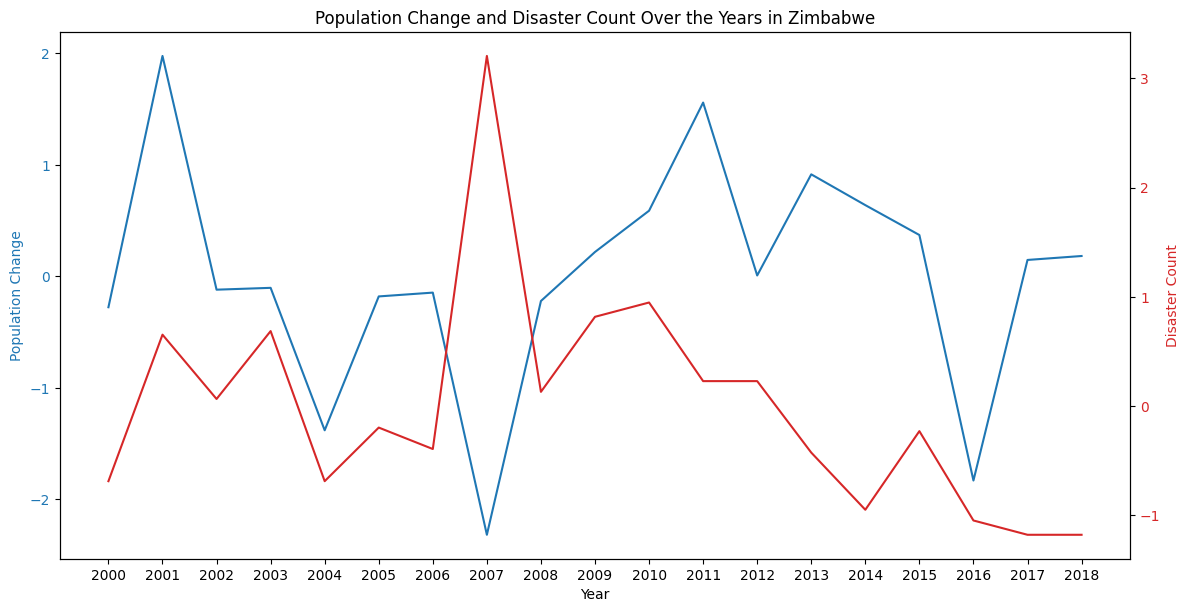

In [ ]:
# Plot the time series
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Year')
ax1.set_ylabel('Population Change', color=color)
ax1.plot(combined_df['Year'].astype(str), combined_df['Population Change'], color=color, label='Population Change')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Disaster Count', color=color)
ax2.plot(combined_df['Year'].astype(str), combined_df['Disaster Count'], color=color, label='Disaster Count')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title(f'Population Change and Disaster Count Over the Years in {country_name[0]}')
plt.show()

In [39]:
# @title Parameters
year1 = 2015
year2 = 2016

# Create a geemap map
single_country_map_config = {
    'height':800,
    'width':"70%",
    'center': [0, 20],
    'zoom': 3

}

# Add population change layer to the map
vis_params = {
    'min': -3,
    'max': 3,
    'palette': ['#eb389f', '#cccccc', '#018f1d']
}

# Add a legend to the map
legend_dict = {
    'Decline': 'red',
    'Uninhabited': 'white',
    'Growth': 'green'
}

In [46]:
single_country_name = ['Algeria']

pop_change_img = calculate_population_change(single_country_name, year1, year2) # Calculating the population change

Map = geemap.Map(**single_country_map_config)

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')
Map.addLayer(filter_countries(single_country_name), {}, 'Country Boundary')

# Center the map on the selected country
country_geom = filtered_country.geometry()
Map.centerObject(country_geom, zoom=7)

Map.addLayerControl()

# Display the map
Map

Map(center=[-18.99298187251295, 29.868341570404244], controls=(WidgetControl(options=['position', 'transparent…

### Analysis

In [ ]:
# @title Parameters
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
combined_df[['Population Change', 'Disaster Count']] = scaler.fit_transform(combined_df[['Population Change', 'Disaster Count']])

In [ ]:
# Perform correlation analysis for population count for mozambique
correlation, p_value = pearsonr(combined_df['Population Change'], combined_df['Disaster Count'])
print(f'Pearson correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: -0.18248826586104427
P-value: 0.4546053453798255


In [ ]:
# Calculate distance correlation
disaster_counts = combined_df['Disaster Count'].values
population_changes = combined_df['Population Change'].values
distance_corr = dcor.distance_correlation(disaster_counts, population_changes)

print(f"Distance correlation between disaster count and population change: {distance_corr}")

Distance correlation between disaster count and population change: 0.46683324887864663


In [ ]:
# @title parameters
!pip install dcor
import dcor

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

In [ ]:
# Calculate disaster count per year
disaster_count_per_year = disaster_df.groupby(['Country', 'Year']).size().unstack(fill_value=0)

# Initialize an empty list to store results
results = []

with tqdm(total=len(countries_list), desc="Processing Countries") as pbar:
    for country in countries_list:
        # Update the description to include the country name
        pbar.set_postfix(country=country)

        # Create an empty list to store population change results
        population_changes = []

        # Loop over the years and calculate population change for each year
        for year in range(start_year, end_year):
            change_result = calculate_population_change([country], year, year + 1)
            population_changes.append(change_result)

        # Convert the results to a DataFrame
        pop_change_df = pd.DataFrame({
            'Year': range(start_year, end_year),
            'Population Change': population_changes
        })

        # Get disaster counts for the country
        disaster_counts = disaster_count_per_year.loc[country].reindex(range(start_year, end_year), fill_value=0).values

        # Calculate distance correlation
        population_changes = pop_change_df['Population Change'].values
        distance_corr = dcor.distance_correlation(disaster_counts, population_changes)

        # Append the result
        results.append({
            'Country': country,
            'Change':population_changes,
            'Distance Correlation': distance_corr
        })

        # Update the progress bar
        pbar.update(1)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

print(results_df)

Processing Countries: 100%|██████████| 29/29 [16:03<00:00, 33.22s/it, country=Botswana]

         Country  Distance Correlation
0       Zimbabwe              0.403006
1     Mozambique              0.426763
2          Sudan              0.463636
3         Malawi              0.348610
4       Ethiopia              0.310997
5     Mauritania              0.250782
6           Mali              0.449705
7        Algeria              0.498673
8         Uganda              0.366234
9     Madagascar              0.354852
10         Kenya              0.350417
11       Senegal              0.700296
12        Angola              0.299742
13  South Africa              0.339220
14       Somalia              0.239483
15       Comoros              0.316037
16       Burundi              0.371131
17         Niger              0.282250
18  Burkina Faso              0.391266
19         Ghana              0.379538
20        Rwanda              0.316066
21   South Sudan              0.259575
22       Namibia              0.340114
23          Chad              0.276317
24        Zambia         

### Long-term and short-term population change

In [ ]:
# Initialize lists to store results
long_term_results_new = []
short_term_results_new = []

with tqdm(total=len(countries_list), desc="Processing countries") as pbar:
    for country in countries_list:
        # Create empty lists to store population change results
        long_term_population_changes_2 = []
        long_term_population_changes_5 = []
        long_term_population_changes_10 = []
        short_term_population_changes = []

        # Loop over the years and calculate long-term and short-term population changes
        for year in range(start_year, end_year):
            if year + 2 <= end_year:
                pbar.set_postfix(country=country, classification="long-term (2 years)")
                long_term_change_2 = calculate_population_change([country], year, year + 2)
                if long_term_change_2 is None:
                    long_term_change_2 = 0
                long_term_population_changes_2.append(long_term_change_2)
            else:
                long_term_population_changes_2.append(0)

            if year + 5 <= end_year:
                pbar.set_postfix(country=country, classification="long-term (5 years)")
                long_term_change_5 = calculate_population_change([country], year, year + 5)
                if long_term_change_5 is None:
                    long_term_change_5 = 0
                long_term_population_changes_5.append(long_term_change_5)
            else:
                long_term_population_changes_5.append(0)

            if year + 10 <= end_year:
                pbar.set_postfix(country=country, classification="long-term (10 years)")
                long_term_change_10 = calculate_population_change([country], year, year + 10)
                if long_term_change_10 is None:
                    long_term_change_10 = 0
                long_term_population_changes_10.append(long_term_change_10)
            else:
                long_term_population_changes_10.append(0)

            pbar.set_postfix(country=country, classification="short-term")
            short_term_change = calculate_population_change([country], year, year + 1)
            if short_term_change is None:
                short_term_change = 0
            short_term_population_changes.append(short_term_change)

        # Convert the results to DataFrames
        long_term_pop_change_df_2 = pd.DataFrame({
            'Year': range(start_year, end_year),
            'Population Change (2 years)': long_term_population_changes_2
        })

        long_term_pop_change_df_5 = pd.DataFrame({
            'Year': range(start_year, end_year),
            'Population Change (5 years)': long_term_population_changes_5
        })

        long_term_pop_change_df_10 = pd.DataFrame({
            'Year': range(start_year, end_year),
            'Population Change (10 years)': long_term_population_changes_10
        })

        short_term_pop_change_df = pd.DataFrame({
            'Year': range(start_year, end_year),
            'Population Change': short_term_population_changes
        })

        # Get disaster counts for the country
        if country in long_term_disaster_count.index:
            long_term_disaster_counts = long_term_disaster_count.loc[country].reindex(range(start_year, end_year), fill_value=0).values
        else:
            long_term_disaster_counts = [0] * (end_year - start_year)

        if country in short_term_disaster_count.index:
            short_term_disaster_counts = short_term_disaster_count.loc[country].reindex(range(start_year, end_year), fill_value=0).values
        else:
            short_term_disaster_counts = [0] * (end_year - start_year)

        # Convert lists to NumPy arrays
        long_term_disaster_counts = np.array(long_term_disaster_counts)
        short_term_disaster_counts = np.array(short_term_disaster_counts)
        long_term_population_changes_2 = np.array(long_term_population_changes_2)
        long_term_population_changes_5 = np.array(long_term_population_changes_5)
        long_term_population_changes_10 = np.array(long_term_population_changes_10)
        short_term_population_changes = np.array(short_term_population_changes)

        # Calculate distance correlation
        long_term_distance_corr_2 = dcor.distance_correlation(long_term_disaster_counts, long_term_population_changes_2)
        long_term_distance_corr_5 = dcor.distance_correlation(long_term_disaster_counts, long_term_population_changes_5)
        long_term_distance_corr_10 = dcor.distance_correlation(long_term_disaster_counts, long_term_population_changes_10)
        short_term_distance_corr = dcor.distance_correlation(short_term_disaster_counts, short_term_population_changes)

        # Append the results
        long_term_results_new.append({
            'Country': country,
            'Long-Term Distance Correlation (2 years)': long_term_distance_corr_2,
            'Long-Term Distance Correlation (5 years)': long_term_distance_corr_5,
            'Long-Term Distance Correlation (10 years)': long_term_distance_corr_10,
            'Year': list(range(start_year, end_year)),
            'Long-Term Population Change (2 years)': long_term_population_changes_2,
            'Long-Term Population Change (5 years)': long_term_population_changes_5,
            'Long-Term Population Change (10 years)':long_term_population_changes_10,
            'Long-Term Disaster Count': long_term_disaster_counts
            })
        short_term_results_new.append({
            'Country': country,
            'Short-Term Distance Correlation': short_term_distance_corr,
            'Year': list(range(start_year, end_year)),
            'Short-Term Population Change': short_term_population_changes,
            'Short-Term Disaster Count': short_term_disaster_counts
        })

        # Update the progress bar
        pbar.update(1)

# Convert results to DataFrames
long_term_results_df = pd.DataFrame(long_term_results_new)
short_term_results_df = pd.DataFrame(short_term_results_new)

Processing countries: 100%|██████████| 29/29 [57:04<00:00, 118.07s/it, classification=short-term, country=Botswana]


In [ ]:
# Check point
long_term_corr_path = "/content/CERI/data/processed/Country_level_long_term_correlation.csv"
short_term_corr_path = "/content/CERI/data/processed/Country_level_short_term_correlation.csv"

# Save the file
# long_term_results_df.to_csv(long_term_corr_path, index=False)
# short_term_results_df.to_csv(short_term_corr_path, index=False)

# Load the file
long_term_results_df = pd.read_csv(long_term_corr_path)
short_term_results_df = pd.read_csv(short_term_corr_path)

In [ ]:
# Drop rows where any of the specified columns are equal to zero
correlation_country_level = long_term_results_df[
    (long_term_results_df['Long-Term Distance Correlation (2 years)'] != 0) &
    (long_term_results_df['Long-Term Distance Correlation (5 years)'] != 0) &
    (long_term_results_df['Long-Term Distance Correlation (10 years)'] != 0)
][['Country', 'Long-Term Distance Correlation (2 years)', 'Long-Term Distance Correlation (5 years)', 'Long-Term Distance Correlation (10 years)']]

correlation_country_level

,Country,Long-Term Distance Correlation (2 years),Long-Term Distance Correlation (5 years),Long-Term Distance Correlation (10 years)
0,Zimbabwe,0.40,0.40,0.17
1,Mozambique,0.26,0.26,0.51
2,Sudan,0.21,0.21,0.14
3,Malawi,0.19,0.23,0.13
4,Ethiopia,0.31,0.18,0.08
5,Mauritania,0.20,0.13,0.17
6,Mali,0.35,0.32,0.11
7,Algeria,0.46,0.24,0.23
8,Uganda,0.22,0.24,0.25
9,Madagascar,0.24,0.09,0.09


## Visualization

In [45]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Example usage
single_country_name = ['Zimbabwe']
year1 = 2000
year2 = 2001
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(center=[0, 20], zoom=3)

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

### Adding the disaster dataset

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

In [ ]:
# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('disaster_type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Example usage
single_country_name = ['Zimbabwe']
year1 = 2000
year2 = 2001

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Create a geemap map
africa_map_config = {
    'center': [0, 20],
    'zoom': 3
}
Map_africa = geemap.Map(**africa_map_config)

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}
pop_change_img = calculate_population_change(single_country_name, year1, year2)
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map_africa.addLayer(filter_countries(single_country_name), {}, 'Country Boundary')

# Convert the CSV file (after preprocessing) into an Earth Engine FeatureCollection
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset.style({'color': color}), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add layer control to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

In [ ]:
# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('disaster_type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('style', {'color': color})

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Example usage
single_country_name = ['Zimbabwe']
year1 = 2000
year2 = 2001

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Create a geemap map
africa_map_config = {
    'center': [0, 20],
    'zoom': 3
}
Map_africa = geemap.Map(**africa_map_config)

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}
pop_change_img = calculate_population_change(single_country_name, year1, year2)
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map_africa.addLayer(filter_countries(single_country_name), {}, 'Country Boundary')

# Convert the CSV file (after preprocessing) into an Earth Engine FeatureCollection
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add layer control to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

CSV file converted successfully.


Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)

# List of countries to filter
countries_list = [
    "Zimbabwe", "Mozambique", "Sudan", "Malawi", "Ethiopia", "Mauritania",
    "Mali", "Algeria", "Uganda", "Madagascar", "Kenya", "Senegal", "Angola",
    "South Africa", "Somalia", "Comoros", "Burundi", "Niger", "Burkina Faso",
    "Ghana", "Rwanda", "South Sudan", "Namibia", "Chad", "Zambia", "Nigeria",
    "Benin", "Egypt", "Botswana"
]

# Function to filter countries
def filter_countries(country_names):
    return africa_shapefile.filter(ee.Filter.inList('ADM0_NAME', country_names))

# Function to calculate population change between two years for a given country or list of countries
def calculate_population_change(country_names, year1, year2):
    # Load population data for the specified years
    img1 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year1}")
    img2 = ee.Image(f"projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-{year2}")

    # Calculate the change
    pop_change = img2.subtract(img1)

    # Filter countries based on input
    filtered_countries = filter_countries(country_names)

    # Clip the change image to the country region
    pop_change_clipped = pop_change.clip(filtered_countries)

    return pop_change_clipped

# Function to set color for each feature based on disaster type
def set_color(feature):
    key = feature.get('disaster_type')
    color = disaster_colors.get(key, "black")  # default to black if type not found
    return feature.set('color', color)

# Define color for each disaster type
disaster_colors = {
    "Flood": "#80B1D3",
    "Storm": "#BEBADA",
    "Drought": "#FFFFB3",
    "Earthquake": "#8DD3C7",
    "Volcanic activity": "#FB8072",
}

# Parameters for legend
legend_keys = list(disaster_colors.keys())
legend_colors = list(disaster_colors.values())

# Example usage
single_country_name = ['Burundi']
year1 = 2006
year2 = 2007

# Create a geemap map
africa_map_config = {
    'center': [0, 20],
    'zoom': 3
}
Map_africa = geemap.Map(**africa_map_config)

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}
pop_change_img = calculate_population_change(single_country_name, year1, year2)
Map_africa.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map_africa.addLayer(filter_countries(single_country_name), {}, 'Country Boundary')

# Convert the CSV file (after preprocessing) into an Earth Engine FeatureCollection
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Filter disasters by country and date range
disasters_filtered = collections_colored.filter(
    ee.Filter.And(
        ee.Filter.eq('country', single_country_name[0]),
        ee.Filter.inList('date', date_list)
    )
)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = disasters_filtered.filter(ee.Filter.eq('disaster_type', disaster_type))
    count = disaster_subset.size().getInfo()
    print(f'Disaster type: {disaster_type}, Count: {count}')
    Map_africa.addLayer(disaster_subset.style(color), {}, disaster_type)

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add layer control to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

In [ ]:
from datetime import datetime, timedelta

# Function to generate a list of dates
def generate_date_list(start_date, end_date):
    date_list = []
    current_date = start_date
    while current_date <= end_date:
        date_list.append(current_date.strftime('%Y-%m-%d'))
        current_date += timedelta(days=1)
    return date_list

# Generate a list of dates for the year 2000
date_list = generate_date_list(datetime(year1, 1, 1), datetime(year1, 12, 31))

In [ ]:
single_country_name = ['Zimbabwe']
year1 = 2000
year2 = 2001
pop_change_img = calculate_population_change(single_country_name, year1, year2)

# Create a geemap map
Map = geemap.Map(center=[0, 20], zoom=3)

# Add population change layer to the map
vis_params = {
    'min': -1,
    'max': 1,
    'palette': ['red', 'white', 'green']
}

Map.addLayer(pop_change_img, vis_params, f'Population change from {year1} to {year2}')

# Add country boundaries
Map.addLayer(filter_countries(single_country_name), {}, 'Country Boundary')

# Display the map
Map

Map(center=[0, 20], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…

In [ ]:
# Load the shapefile as a FeatureCollection
africa_shapefile = ee.FeatureCollection(asset_PATH)
africa_geometry = africa_shapefile.geometry()

# Filter for the years 2000 and 2001
pop_2000 = ee.Image("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2000").clip(africa_geometry)
pop_2001 = ee.Image("projects/sat-io/open-datasets/ORNL/LANDSCAN_GLOBAL/landscan-global-2001").clip(africa_geometry)

# Perform change detection
pop_change = pop_2001.subtract(pop_2000)

# Create images for reduced change (decrease) and increased change (increase)
reduced_change = pop_change.where(pop_change.gt(0), 0)  # Set positive values to 0
increased_change = pop_change.where(pop_change.lt(0), 0).abs()  # Set negative values to 0 and take absolute value

# Function to create a grid of tiles over the region
def create_grid(geometry, scale):
    coords = geometry.bounds().coordinates().getInfo()[0]
    lon_start, lat_start = coords[0]
    lon_end, lat_end = coords[2]

    lon_steps = int((lon_end - lon_start) / scale)
    lat_steps = int((lat_end - lat_start) / scale)

    tiles = []
    for i in range(lon_steps):
        for j in range(lat_steps):
            lon1 = lon_start + i * scale
            lat1 = lat_start + j * scale
            lon2 = lon1 + scale
            lat2 = lat1 + scale
            tile = ee.Geometry.Rectangle([lon1, lat1, lon2, lat2])
            tiles.append(tile)

    return ee.FeatureCollection(tiles)

# Create a grid of tiles over the Africa geometry
tiles = create_grid(africa_geometry, 1)  # Each tile covers 1 degree by 1 degree

# Function to calculate statistics for a given tile
def calculate_tile_stats(tile):
    reduced_stats = reduced_change.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=tile.geometry(),
        scale=1000,
        bestEffort=True,
        maxPixels=1e9
    )

    increased_stats = increased_change.reduceRegion(
        reducer=ee.Reducer.sum(),
        geometry=tile.geometry(),
        scale=1000,
        bestEffort=True,
        maxPixels=1e9
    )

    return ee.Feature(None, {
        'reduced': reduced_stats.get('b1'),
        'increased': increased_stats.get('b1')
    })

# Calculate changes for each tile
tile_stats = tiles.map(calculate_tile_stats)

# Aggregate the results
total_stats = tile_stats.reduceColumns(
    reducer=ee.Reducer.sum().repeat(2),
    selectors=['reduced', 'increased']
)

total_reduced_change = total_stats.get('sum_0').getInfo()
total_increased_change = total_stats.get('sum_1').getInfo()

print(f"Total reduced population change (decrease) between 2000 and 2001: {total_reduced_change}")
print(f"Total increased population change (increase) between 2000 and 2001: {total_increased_change}")

# END

In [ ]:
# Loop through the TIFF files and calculate population counts
for i in range(len(years)):
    population_count = get_population_count(tiff_files[i])
    population_df = pd.concat([population_df, pd.DataFrame({'Year': [years[i]], 'Population': [population_count]})], ignore_index=True)

# Aggregate the number of disasters per year
disasters_df = pd.read_excel(disasters_excel)
disasters_per_year = disasters_df.groupby('Year').size().reset_index(name='Disaster_Count')

# Merge the population and disasters dataframes on the 'Year' column
merged_df = pd.merge(population_df, disasters_per_year, on='Year', how='left')

# Fill NaN values in 'Disaster_Count' with 0
merged_df['Disaster_Count'].fillna(0, inplace=True)
merged_df['Year'] = merged_df['Year'].astype(int) # Date to int

# Calculate the population change for year t as the difference between population at year (t+1) and population at year t
merged_df['Population_Change'] = merged_df['Population'].shift(-1) - merged_df['Population']
merged_df = merged_df[:-1] # Remove the last year (2019)

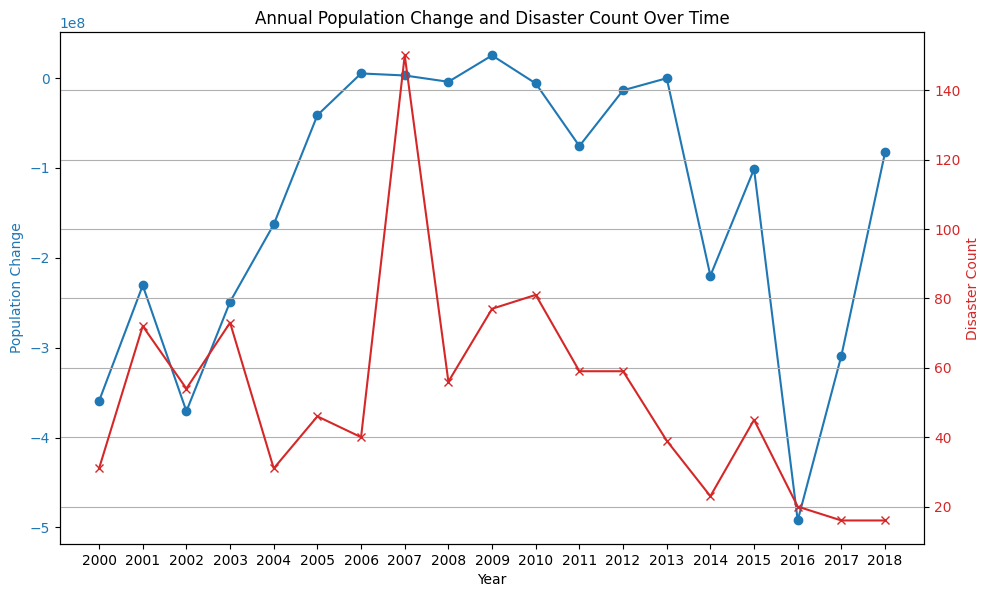

In [ ]:
# Plot the annual change in population and disaster counts over time
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Year')
ax1.set_ylabel('Population Change', color='tab:blue')
ax1.plot(merged_df['Year'].astype(str), merged_df['Population_Change'], marker='o', color='tab:blue', label='Population Change')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Disaster Count', color='tab:red')
ax2.plot(merged_df['Year'].astype(str), merged_df['Disaster_Count'], marker='x', color='tab:red', label='Disaster Count')
ax2.tick_params(axis='y', labelcolor='tab:red')

fig.tight_layout()
plt.title('Annual Population Change and Disaster Count Over Time')
plt.grid(True)
plt.show()

### Analysis

In [ ]:
# @title Parameters
import statsmodels.api as sm
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
merged_df[['Population_Change', 'Disaster_Count']] = scaler.fit_transform(merged_df[['Population_Change', 'Disaster_Count']])

#### Correlation Analysis

In [ ]:
# Perform correlation analysis for population count
correlation, p_value = pearsonr(merged_df['Population'], merged_df['Disaster_Count'])
print(f'Pearson correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: 0.26990035789638933
P-value: 0.26378165112592616


In [ ]:
# Perform pearsonr correlation analysis for pop change
correlation, p_value = pearsonr(merged_df['Population_Change'], merged_df['Disaster_Count'])
print(f'Pearson correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: 0.42520145785734237
P-value: 0.06954904573059048


#### Regression Analysis

In [ ]:
# Perform regression analysis
X = merged_df['Disaster_Count']
y = merged_df['Population_Change']

X = sm.add_constant(X)  # Adding a constant for the intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Population_Change   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     3.752
Date:                Fri, 31 May 2024   Prob (F-statistic):             0.0695
Time:                        07:15:49   Log-Likelihood:                -25.065
No. Observations:                  19   AIC:                             54.13
Df Residuals:                      17   BIC:                             56.02
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -1.11e-16      0.220  -5.06e

#### Summary of OLS Regression Results:

1. **Model Overview:**
   - **Dependent Variable:** Population_Change (normalized)
   - **Independent Variable:** Disaster_Count (normalized)

2. **Key Statistics:**
   - **R-squared:** 0.181
   - **Adjusted R-squared:** 0.133
   - **F-statistic:** 3.752
   - **Prob (F-statistic):** 0.0695

3. **Model Coefficients:**
   - **Constant (const):** -1.11e-16 (essentially zero, with no significant effect)
   - **Disaster_Count Coefficient:** 0.4252

4. **Coefficient Significance:**
   - **P-value for Disaster_Count:** 0.070
   - **95% Confidence Interval for Disaster_Count:** [-0.038, 0.888]

### Interpretation:

1. **R-squared (0.181):**
   - This indicates that approximately 18.1% of the variability in population change can be explained by the disaster count. While this is a modest percentage, it does suggest some level of explanatory power.

2. **Adjusted R-squared (0.133):**
   - The adjusted R-squared accounts for the number of predictors in the model relative to the number of data points. At 13.3%, it confirms the modest explanatory power of the disaster count.

3. **F-statistic (3.752) and Prob (F-statistic) (0.0695):**
   - The F-statistic tests whether at least one predictor variable has a non-zero coefficient. A p-value of 0.0695 is slightly above the typical 0.05 threshold for statistical significance, suggesting a weakly significant overall model.

4. **Coefficient for Disaster_Count (0.4252):**
   - The positive coefficient suggests that an increase in disaster count is associated with an increase in population change. Specifically, for a one standard deviation increase in disaster count, the population change increases by 0.4252 standard deviations.

5. **P-value for Disaster_Count (0.070):**
   - The p-value of 0.070 indicates that the relationship between disaster count and population change is not statistically significant at the 0.05 level, but it is close. This suggests that there is a weak association between the two variables.

6. **Confidence Interval for Disaster_Count [-0.038, 0.888]:**
   - The 95% confidence interval includes zero, which further indicates that the relationship between disaster count and population change is not statistically significant.

### Additional Considerations:

- **Model Fit:** The R-squared and adjusted R-squared values indicate that the model explains a modest portion of the variance in population change. This suggests that other factors not included in the model may also influence population change.

- **Significance:** While the relationship is not statistically significant at the 0.05 level, the p-value of 0.070 suggests a trend that might be worth exploring further with additional data or more sophisticated models.

- **Residual Analysis:** The Durbin-Watson statistic (1.121) suggests potential positive autocorrelation in the residuals. This indicates that the residuals may not be independent, which could impact the validity of the regression results.

### Conclusion:

The OLS regression analysis indicates a weak positive relationship between disaster count and population change, but this relationship is not statistically significant at the conventional 0.05 level. The modest R-squared value suggests that other factors beyond disaster counts are likely influencing population changes. Further investigation with additional variables or different modeling techniques may provide more insights into the relationship between disasters and population dynamics.

## Country level: Change in population

In [ ]:
# @title Parameters
import os
import rasterio
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Define the base folder containing the year subfolders
base_folder = '/content/CERI/data/external/Landscan_data/processed/country_level'
disasters_excel = '/content/CERI/data/processed/Disasters_in_africa_2000_2018_processed.xlsx' # Disaster excel file

# Initialize a DataFrame to store the change counts
changes_df = pd.DataFrame(columns=['Year', 'Country', 'Population_Curr_Year', 'Population_Next_Year', 'Change'])

# Function to calculate the population count from a TIFF file
def get_population_count(tiff_file):
    with rasterio.open(tiff_file) as src:
        data = src.read(1).astype(np.float64)  # Ensure data is in float64 to prevent overflow
        return np.sum(data)

In [ ]:
# Loop through each year's folder
years = sorted(os.listdir(base_folder))
for i in range(len(years) - 1):
    year_curr = years[i]
    year_next = years[i + 1]

    # Get the list of countries for the current year
    countries = os.listdir(os.path.join(base_folder, year_curr))

    for country_file in countries:
        # Extract the country name from the file name
        country_name = country_file.split('_')[0]

        # Define paths to the raster files for the current and next year
        raster_path_curr = os.path.join(base_folder, year_curr, country_file)
        raster_path_next = os.path.join(base_folder, year_next, country_file.replace(year_curr, year_next))

        # Ensure both raster files exist before processing
        if not os.path.exists(raster_path_curr) or not os.path.exists(raster_path_next):
            continue

        # Calculate the population counts
        population_curr_year = get_population_count(raster_path_curr)
        population_next_year = get_population_count(raster_path_next)

        # Calculate the change
        change = population_next_year - population_curr_year

        # Store the change in the DataFrame using pd.concat
        change_data = pd.DataFrame({
            'Year': [year_curr],
            'Country': [country_name],
            'Population_Curr_Year': [population_curr_year],
            'Population_Next_Year': [population_next_year],
            'Change': [change]
        })
        changes_df = pd.concat([changes_df, change_data], ignore_index=True)

In [ ]:
changes_df.head(5)

,Year,Country,Population_Curr_Year,Population_Next_Year,Change
0,2000,Benin,34765093.0,34758155.0,-6938.0
1,2000,Somalia,187227555.0,168169082.0,-19058473.0
2,2000,Namibia,133397540.0,125052194.0,-8345346.0
3,2000,Uganda,60902695.0,60635698.0,-266997.0
4,2000,Malawi,29002048.0,28994298.0,-7750.0


In [ ]:
# Load the disasters dataset
disasters_df = pd.read_excel(disasters_excel)

# Ensure the 'Year' column in is of type int
disasters_df['Year'] = disasters_df['Year'].astype(int)
changes_df['Year'] = changes_df['Year'].astype(int)

# Merge the population change data with the disaster data
merged_df = pd.merge(changes_df, disasters_df, on=['Year', 'Country'], how='left')

In [ ]:
countries = changes_df['Country'].unique()
countries

array(['Benin', 'Somalia', 'Namibia', 'Uganda', 'Malawi', 'Senegal',
       'Algeria', 'Ghana', 'Sudan', 'South Africa', 'Niger', 'Comoros',
       'Angola', 'Rwanda', 'Madagascar', 'South Sudan', 'Burundi',
       'Zimbabwe', 'Ethiopia', 'Botswana', 'Nigeria', 'Kenya', 'Mali',
       'Zambia', 'Mauritania', 'Chad', 'Mozambique', 'Burkina Faso',
       'Egypt'], dtype=object)

In [ ]:
# Filter the DataFrame for the specified country
country_name = "Ghana"
filtered_df = merged_df[merged_df['Country'] == country_name]
filtered_df = filtered_df.sort_values(by=['Country', 'Year'])

# Calculate the number of disasters per year
disaster_count_per_year = filtered_df.groupby('Year')['Disaster type'].count().reset_index(name='Disaster_Count')

# Merge disaster count with population change data
final_df = pd.merge(filtered_df, disaster_count_per_year, on='Year')

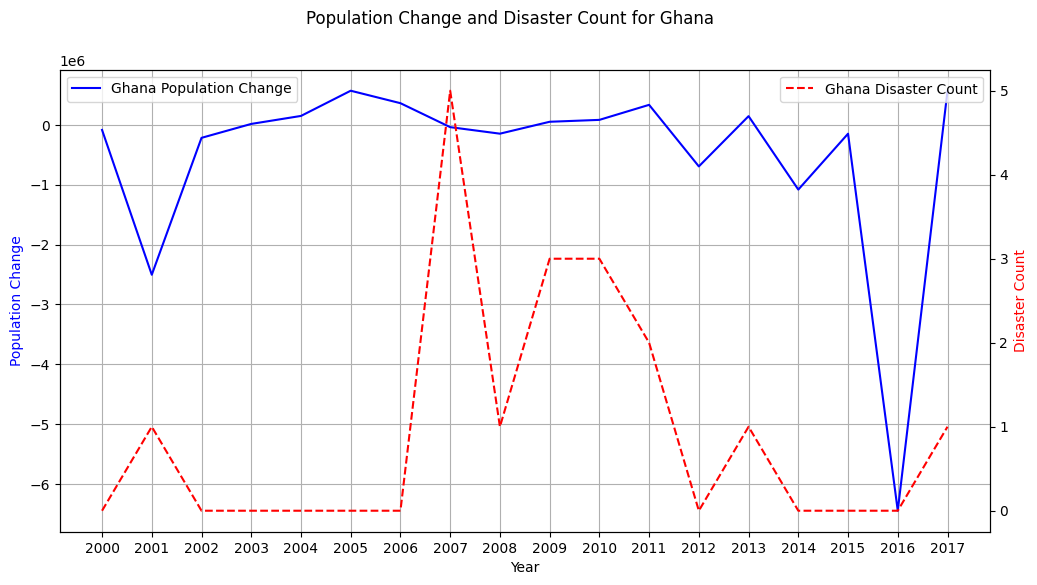

In [ ]:
# Plot the population changes and disaster counts for the specified country
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(final_df['Year'].astype(str), final_df['Change'], label=f"{country_name} Population Change", color='b')
ax1.set_xlabel('Year')
ax1.set_ylabel('Population Change', color='b')

# Create a secondary y-axis for the disaster count
ax2 = ax1.twinx()
ax2.plot(disaster_count_per_year['Year'].astype(str), disaster_count_per_year['Disaster_Count'], label=f"{country_name} Disaster Count", color='r', linestyle='--')
ax2.set_ylabel('Disaster Count', color='r')

# Title and legend
fig.suptitle(f'Population Change and Disaster Count for {country_name}')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Grid and show
ax1.grid(True)
plt.show()

### **Analysis for one country**

In [ ]:
# @title Parameters

# Normalize the values
scaler = MinMaxScaler()
final_df[['Change', 'Disaster_Count']] = scaler.fit_transform(final_df[['Change', 'Disaster_Count']])

#### **Correlation Analysis**

In [ ]:
# Perform correlation analysis
correlation, p_value = pearsonr(final_df['Change'], final_df['Disaster_Count'])
print(f'Pearson correlation coefficient: {correlation}')
print(f'P-value: {p_value}')

Pearson correlation coefficient: 0.23703052127686958
P-value: 0.23387978842439194


#### **Regression Analysis**

In [ ]:
# Perform regression analysis
X = final_df['Disaster_Count']
y = final_df['Change']

X = sm.add_constant(X)  # Adding a constant for the intercept

model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 Change   R-squared:                       0.056
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.488
Date:                Fri, 31 May 2024   Prob (F-statistic):              0.234
Time:                        07:16:32   Log-Likelihood:                 7.3344
No. Observations:                  27   AIC:                            -10.67
Df Residuals:                      25   BIC:                            -8.077
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8278      0.052     15.

### **Analysis For every Country**

In [ ]:
# @title Parameters
# Initialize a DataFrame to store the correlation results and the regression results
correlation_results = pd.DataFrame(columns=['Country', 'Pearson_Correlation', 'P_value'])
regression_results = pd.DataFrame(columns=['Country', 'Coefficient', 'Intercept', 'R_squared', 'P_value'])

# Get the list of unique countries
countries = merged_df['Country'].unique()

#### Correlation Analysis

In [ ]:
# Merge disaster count with population change data
merged_df = pd.merge(merged_df, disaster_count_per_year, on='Year')

In [ ]:
# Calculate the Pearson correlation for each country
for country in countries:
    country_data = merged_df[merged_df['Country'] == country]

    if len(country_data) < 2:  # Need at least 2 data points to calculate correlation
        continue

    # Normalize the values
    scaler = MinMaxScaler()
    country_data[['Change', 'Disaster_Count']] = scaler.fit_transform(country_data[['Change', 'Disaster_Count']])

    # Perform correlation analysis
    correlation, p_value = pearsonr(country_data['Change'], country_data['Disaster_Count'])

    # Store the results
    correlation_results = pd.concat([correlation_results, pd.DataFrame({
        'Country': [country],
        'Pearson_Correlation': [correlation],
        'P_value': [p_value]
    })], ignore_index=True)

# Display the correlation results
print(correlation_results)

         Country  Pearson_Correlation       P_value
0          Benin             0.222895  3.739857e-01
1        Somalia             0.240120  2.817624e-01
2        Namibia             0.124746  5.270769e-01
3         Uganda            -0.261742  3.238843e-02
4         Malawi             0.247875  5.837303e-02
5        Senegal             0.065810  7.204534e-01
6        Algeria             0.361036  3.251495e-04
7          Ghana             0.237031  2.338798e-01
8          Sudan             0.316427  5.638593e-02
9   South Africa             0.363480  7.409636e-02
10         Niger             0.157475  3.132089e-01
11       Comoros             0.171125  4.836323e-01
12        Angola             0.197017  1.455605e-01
13        Rwanda            -0.292975  1.974417e-01
14    Madagascar             0.348779  6.783580e-03
15   South Sudan            -0.067034  7.728071e-01
16       Burundi             0.222180  2.139728e-01
17      Zimbabwe             0.228000  3.074856e-01
18      Ethi

#### Regression Analysis

In [ ]:
# Calculate the regression for each country
for country in countries:
    country_data = merged_df[merged_df['Country'] == country]

    if len(country_data) < 2 or country_data['Change'].nunique() <= 1 or country_data['Disaster_Count'].nunique() <= 1:
        regression_results = pd.concat([regression_results, pd.DataFrame({
            'Country': [country],
            'Coefficient': [np.nan],
            'Intercept': [np.nan],
            'R_squared': [np.nan],
            'P_value': [np.nan]
        })], ignore_index=True)
        continue

    # Normalize the values
    scaler = MinMaxScaler()
    country_data[['Change', 'Disaster_Count']] = scaler.fit_transform(country_data[['Change', 'Disaster_Count']])

    # Prepare the data for regression
    X = country_data[['Disaster_Count']]
    y = country_data['Change']

    # Add a constant to the independent variables matrix
    X = sm.add_constant(X)

    # Perform regression analysis using statsmodels
    model = sm.OLS(y, X).fit()

    # Extract regression results
    coefficient = model.params['Disaster_Count']
    intercept = model.params['const']
    r_squared = model.rsquared
    p_value = model.pvalues['Disaster_Count']

    # Store the results
    regression_results = pd.concat([regression_results, pd.DataFrame({
        'Country': [country],
        'Coefficient': [coefficient],
        'Intercept': [intercept],
        'R_squared': [r_squared],
        'P_value': [p_value]
    })], ignore_index=True)

# Display the regression results
print(regression_results)

         Country  Coefficient  Intercept  R_squared       P_value
0          Benin     0.199687   0.775696   0.049682  3.739857e-01
1        Somalia     0.257516   0.754646   0.057658  2.817624e-01
2        Namibia     0.087800   0.719900   0.015561  5.270769e-01
3         Uganda    -0.080690   0.904378   0.068509  3.238843e-02
4         Malawi     0.270660   0.693704   0.061442  5.837303e-02
5        Senegal     0.040778   0.728865   0.004331  7.204534e-01
6        Algeria     0.345734   0.517240   0.130347  3.251495e-04
7          Ghana     0.120144   0.827777   0.056183  2.338798e-01
8          Sudan     0.204175   0.745612   0.100126  5.638593e-02
9   South Africa     0.245267   0.806484   0.132118  7.409636e-02
10         Niger     0.073047   0.721590   0.024798  3.132089e-01
11       Comoros     0.130891   0.840774   0.029284  4.836323e-01
12        Angola     0.117340   0.253873   0.038816  1.455605e-01
13        Rwanda    -0.173111   0.786046   0.085834  1.974417e-01
14    Mada

## Country level: Change in pixels

In [ ]:
# @title Helper Functions
from collections import defaultdict

def calculate_changes(raster1_path, raster2_path):
    with rasterio.open(raster1_path) as src1, rasterio.open(raster2_path) as src2:
        raster1 = src1.read(1)
        raster2 = src2.read(1)

        assert raster1.shape == raster2.shape, "The rasters have different dimensions"

        changes = np.where(raster1 != raster2, 1, 0)

        return changes.sum()

def calculate_all_changes(base_path):
    changes_per_country_per_year = defaultdict(dict)
    raster_files = get_raster_files(base_path)

    for country, year_files in raster_files.items():
        years = sorted(year_files.keys())
        for i in range(len(years) - 1):
            year1, year2 = years[i], years[i + 1]
            raster1_path = year_files[year1]
            raster2_path = year_files[year2]
            changes = calculate_changes(raster1_path, raster2_path)
            changes_per_country_per_year[country][year2] = changes

    return changes_per_country_per_year

def get_raster_files(base_path):
    raster_files = defaultdict(dict)
    for year_folder in os.listdir(base_path):
        year_path = os.path.join(base_path, year_folder)
        if os.path.isdir(year_path):
            for file_name in os.listdir(year_path):
                if file_name.endswith('.tif'):
                    country = file_name.split('_')[0]
                    raster_files[country][year_folder] = os.path.join(year_path, file_name)
    return raster_files

def load_disaster_data(disasters_excel):
    disasters_df = pd.read_excel(disasters_excel)
    disaster_counts = defaultdict(lambda: defaultdict(int))

    # Populate disaster counts from the excel file
    for _, row in disasters_df.iterrows():
        country = row['Country']
        year = str(row['Year'])
        disaster_counts[country][year] += 1

    # Ensure all years from 2000 to 2018 are included for each country
    for country in disaster_counts.keys():
        for year in range(2000, 2019):
            if str(year) not in disaster_counts[country]:
                disaster_counts[country][str(year)] = 0

    return disaster_counts

def plot_time_series(changes_per_country_per_year, disaster_counts, country):
    all_years = [str(year) for year in range(2000, 2019)]
    changes = [changes_per_country_per_year[country].get(year, 0) for year in all_years]
    disaster_counts_list = [disaster_counts[country].get(year, 0) for year in all_years]

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Changes', color='tab:blue')
    ax1.plot(all_years, changes, marker='o', color='tab:blue', label='Changes')
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Disaster Counts', color='tab:red')
    ax2.plot(all_years, disaster_counts_list, marker='x', color='tab:red', label='Disaster Counts')
    ax2.tick_params(axis='y', labelcolor='tab:red')

    fig.tight_layout()
    plt.title(f'Change Detection and Disaster Counts Over Time for {country}')
    plt.grid(True)
    plt.show()

rastes_path = '/content/CERI/data/external/Landscan_data/processed/country_level'
disasters_excel = '/content/CERI/data/processed/Disasters_in_africa_2000_2018_processed.xlsx'

In [ ]:
# Calculate the change in pixels
changes_per_country_per_year = calculate_all_changes(rastes_path)
disaster_counts = load_disaster_data(disasters_excel)

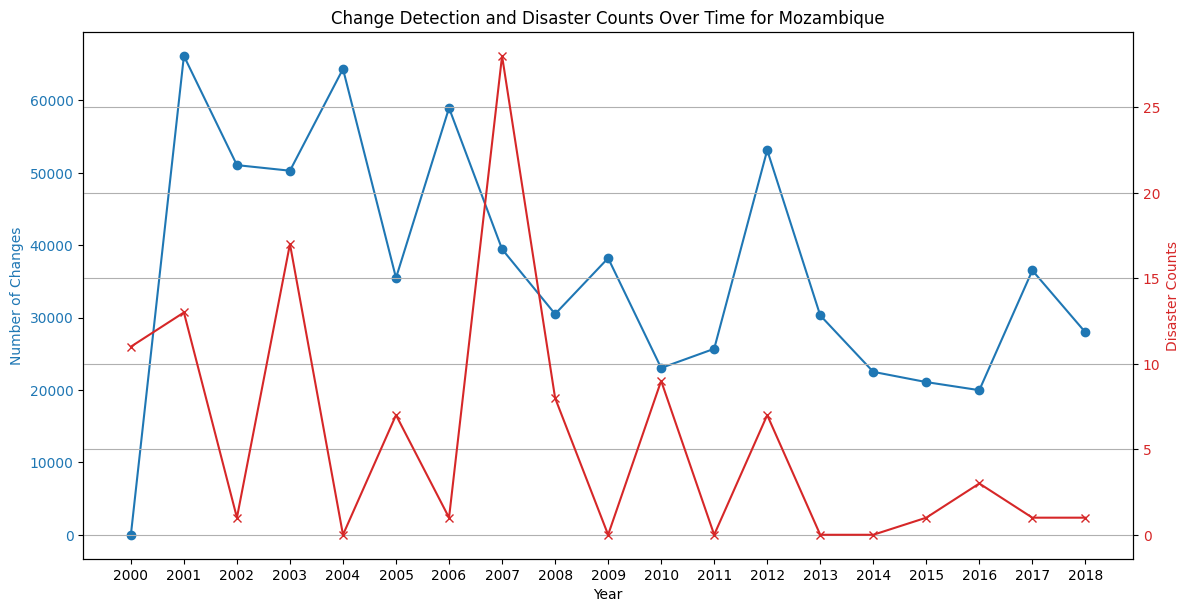

In [ ]:
# Plot the time series for a specific country
plot_time_series(changes_per_country_per_year, disaster_counts, 'Mozambique')

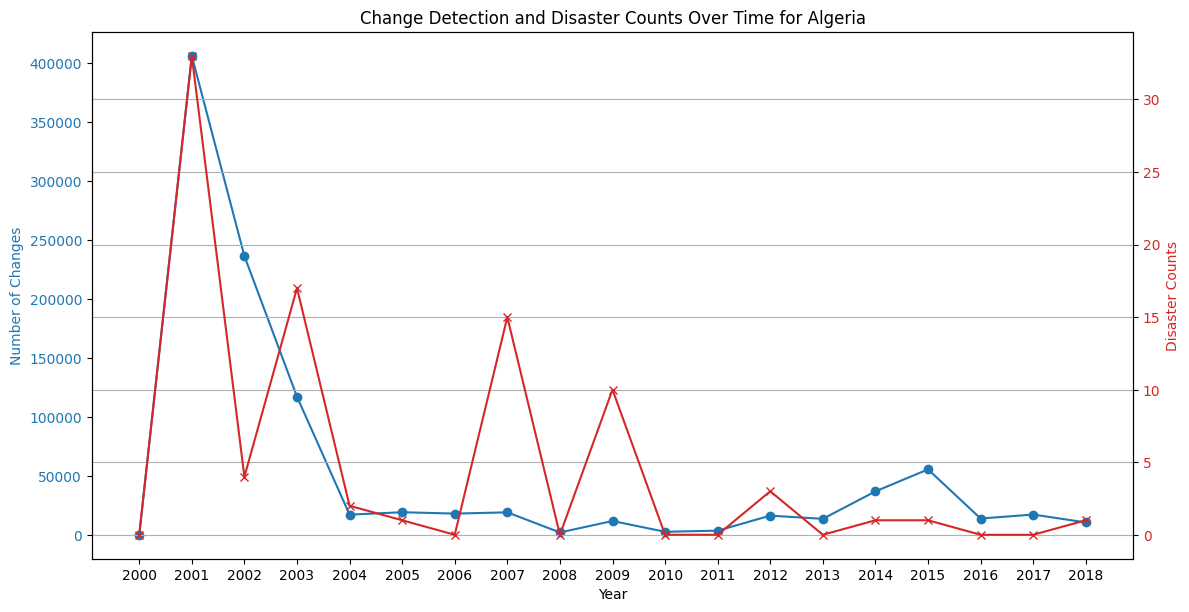

In [ ]:
plot_time_series(changes_per_country_per_year, disaster_counts, 'Algeria')

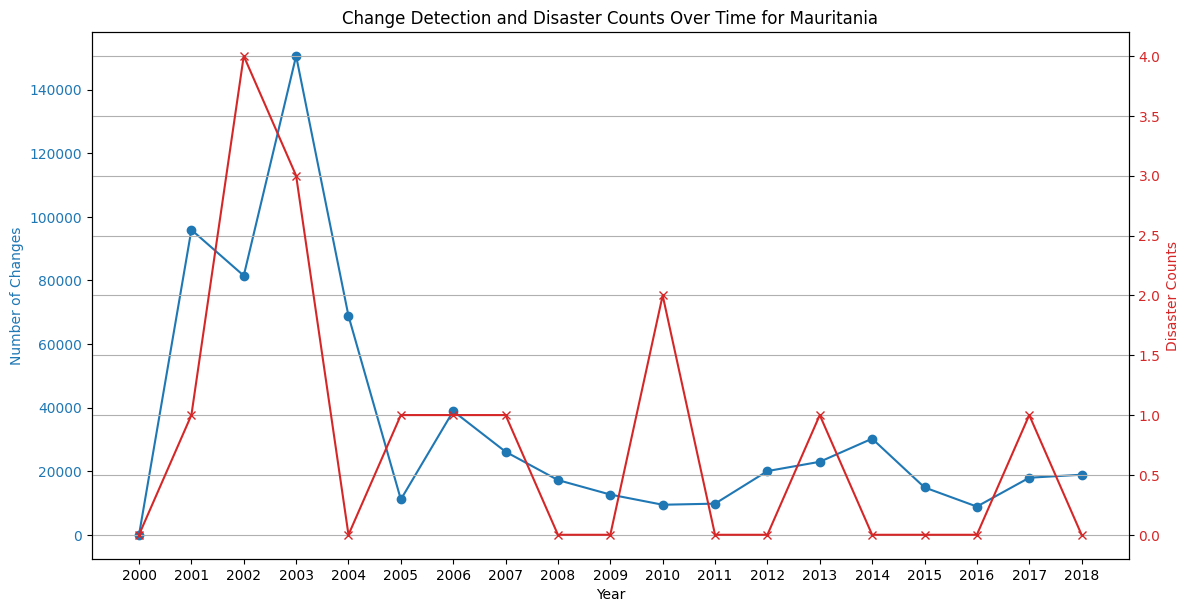

In [ ]:
plot_time_series(changes_per_country_per_year, disaster_counts, 'Mauritania')

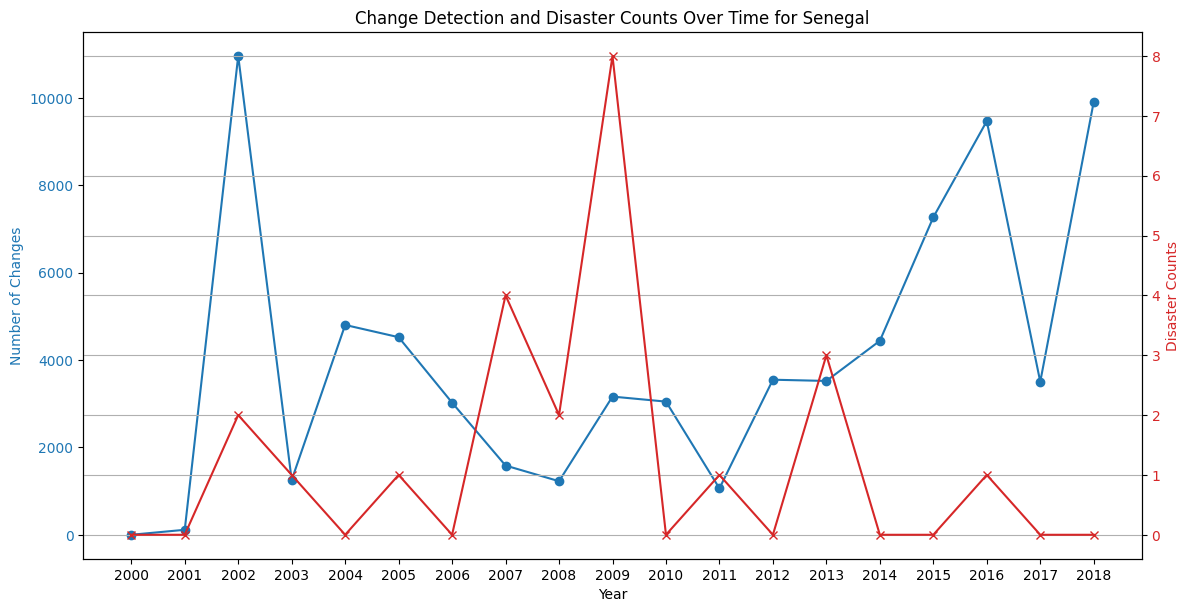

In [ ]:
plot_time_series(changes_per_country_per_year, disaster_counts, 'Senegal')

### Analysis

#### **Correlation Analysis**

In [ ]:
# @title Helper Functions
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

def perform_correlation_analysis(changes_per_country_per_year, disaster_counts):
    correlation_results = {}

    for country in changes_per_country_per_year:
        if country in disaster_counts:
            years = sorted(changes_per_country_per_year[country].keys())
            changes = [changes_per_country_per_year[country][year] for year in years]
            disasters = [disaster_counts[country].get(year, 0) for year in years]

            if len(changes) > 1 and len(disasters) > 1:
                corr, _ = pearsonr(changes, disasters)
                correlation_results[country] = corr

    return correlation_results

def perform_regression_analysis(changes_per_country_per_year, disaster_counts):
    regression_results = {}

    for country in changes_per_country_per_year:
        if country in disaster_counts:
            years = sorted(changes_per_country_per_year[country].keys())
            changes = [changes_per_country_per_year[country][year] for year in years]
            disasters = [disaster_counts[country].get(year, 0) for year in years]

            if len(changes) > 1 and len(disasters) > 1:
                X = np.array(disasters).reshape(-1, 1)
                y = np.array(changes)

                # Using statsmodels for detailed regression results
                X_with_const = sm.add_constant(X)  # Adds a constant term to the predictor
                model = sm.OLS(y, X_with_const).fit()
                regression_results[country] = model

    return regression_results

In [ ]:
correlation_results = perform_correlation_analysis(changes_per_country_per_year, disaster_counts)

print("Correlation Results:")
for country, corr in correlation_results.items():
    print(f"{country}: {corr:.2f}")

Correlation Results:
Benin: -0.14
Somalia: -0.28
Namibia: -0.21
Uganda: -0.11
Malawi: 0.04
Senegal: -0.13
Algeria: 0.77
Ghana: -0.24
Sudan: -0.25
South Africa: -0.21
Niger: -0.35
Comoros: -0.02
Angola: -0.27
Rwanda: -0.23
Madagascar: -0.23
South Sudan: -0.20
Burundi: -0.29
Zimbabwe: -0.13
Ethiopia: -0.25
Botswana: -0.11
Nigeria: -0.27
Kenya: -0.24
Mali: 0.02
Zambia: -0.19
Mauritania: 0.62
Chad: -0.05
Mozambique: 0.21
Burkina Faso: -0.04
Egypt: -0.27


#### Regression Analysis

In [ ]:
regression_results = perform_regression_analysis(changes_per_country_per_year, disaster_counts)

print("Regression Results:")
for country, model in regression_results.items():
    print(f"{country}:")
    print(f"  Coefficient = {model.params[1]:.2f}")
    print(f"  Intercept = {model.params[0]:.2f}")
    print(f"  R-squared = {model.rsquared:.2f}")
    print(f"  p-value = {model.pvalues[1]:.4f}")
    print()

Regression Results:
Benin:
  Coefficient = -525.47
  Intercept = 1126.13
  R-squared = 0.02
  p-value = 0.5743

Somalia:
  Coefficient = -10497.86
  Intercept = 27978.69
  R-squared = 0.08
  p-value = 0.2663

Namibia:
  Coefficient = -9819.17
  Intercept = 63597.85
  R-squared = 0.05
  p-value = 0.3934

Uganda:
  Coefficient = -104.97
  Intercept = 4696.63
  R-squared = 0.01
  p-value = 0.6672

Malawi:
  Coefficient = 20.44
  Intercept = 1461.79
  R-squared = 0.00
  p-value = 0.8792

Senegal:
  Coefficient = -206.04
  Intercept = 4507.28
  R-squared = 0.02
  p-value = 0.5988

Algeria:
  Coefficient = 9172.39
  Intercept = 11594.58
  R-squared = 0.60
  p-value = 0.0002

Ghana:
  Coefficient = -1099.25
  Intercept = 7436.46
  R-squared = 0.06
  p-value = 0.3305

Sudan:
  Coefficient = -17007.65
  Intercept = 139295.80
  R-squared = 0.06
  p-value = 0.3259

South Africa:
  Coefficient = -11804.26
  Intercept = 82196.24
  R-squared = 0.04
  p-value = 0.4120

Niger:
  Coefficient = -4424.83

In [ ]:
country = 'Senegal'
if country in regression_results:
    model = regression_results[country]
    X = np.array([disaster_counts[country][str(year)] for year in range(2001, 2019)]).reshape(-1, 1)
    y = np.array([changes_per_country_per_year[country][str(year)] for year in range(2001, 2019)])
    X_with_const = sm.add_constant(X)
    y_pred = model.predict(X_with_const)

    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, color='blue', label='Actual Data')
    plt.plot(X, y_pred, color='red', linewidth=2, label='Regression Line')
    plt.xlabel('Disaster Counts')
    plt.ylabel('Number of Changes')
    plt.title(f'Regression Analysis for {country} (R^2: {model.rsquared:.2f})')
    plt.legend()
    plt.grid(True)
    plt.show()

General Observations:\
**Low R-squared Values:** Most countries have low R-squared values, indicating that the disaster counts do not explain much of the variance in the number of changes. This suggests that other factors might be more influential in determining the number of changes.\
**High p-values:** Many p-values are above 0.05, indicating that the relationship between disaster counts and changes is not statistically significant for most countries.

Notable Results:\
**Sudan:**

Coefficient: -17007.65\
Intercept: 139295.80\
R-squared: 0.06\
p-value: 0.3259\
Interpretation: There is a slight negative relationship between disaster counts and the number of changes, but it is not statistically significant (p > 0.05).

**Mauritania:**

Coefficient: 20577.89\
Intercept: 19288.59\
R-squared: 0.38\
p-value: 0.0065\
Interpretation: There is a statistically significant positive relationship between disaster counts and the number of changes, with disaster counts explaining 38% of the variance in changes.

**Algeria:**

Coefficient: 9172.39\
Intercept: 11594.58\
R-squared: 0.60\
p-value: 0.0002\
Interpretation: There is a statistically significant positive relationship between disaster counts and the number of changes, with disaster counts explaining 60% of the variance in changes. This is the strongest relationship observed in the data.

**Chad:**

Coefficient: -1616.29\
Intercept: 70689.84\
R-squared: 0.00\
p-value: 0.8464\
Interpretation: There is almost no relationship between disaster counts and the number of changes, and it is not statistically significant.

**Mozambique:**

Coefficient: 412.98\
Intercept: 36371.47\
R-squared: 0.04\
p-value: 0.4122\
Interpretation: There is a very weak positive relationship between disaster counts and the number of changes, but it is not statistically significant.

**Conclusion:**\
**Overall Weak Relationships:** Most countries show weak and statistically insignificant relationships between disaster counts and the number of changes.

**Few Exceptions:** Mauritania and Algeria show significant positive relationships, indicating that in these countries, an increase in disaster counts is associated with an increase in the number of changes.

**Further Analysis Needed:** To understand the number of changes better, other factors should be considered as disaster counts alone do not provide a strong explanatory power for most countries.

# Statistics

In [ ]:
# Initialize the map
Map_africa = geemap.Map(**africa_map_config)

# Calculate the mean center (centroid) of the points as an Earth Engine Geometry object.
mean_center = collections.geometry().centroid()

# Print the coordinates of the centroid by fetching its info
print("Mean Center Coordinates:", mean_center.getInfo())

# Convert the csv file (After preprocessing) into an earth engine feature
collections = feature2ee(Disasters_in_africa_2000_2018_processed_PATH)

# Apply the color setting function to the feature collection
collections_colored = collections.map(set_color)

# Add layers for each disaster type
for disaster_type, color in disaster_colors.items():
    disaster_subset = collections_colored.filter(ee.Filter.eq('Disaster_type', disaster_type))
    Map_africa.addLayer(disaster_subset, {'color': color}, disaster_type)
Map_africa.addLayer(mean_center, {'color': 'red'}, "Mean Center")

# Add legend to the map
Map_africa.add_legend(title="Disaster Types", labels=legend_keys, colors=legend_colors, position='bottomleft')

# Add scale to the map
Map_africa.addLayerControl()

# Display the map
Map_africa

Mean Center Coordinates: {'type': 'Point', 'coordinates': [22.466558649693052, 2.4611966842863064]}
CSV file converted successfully.


Map(center=[0, 17], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

# Land cover classification

In [ ]:
!wget 'http://madm.dfki.de/files/sentinel/EuroSATallBands.zip'

--2024-05-19 12:25:52--  http://madm.dfki.de/files/sentinel/EuroSATallBands.zip
Resolving madm.dfki.de (madm.dfki.de)... 131.246.195.183
Connecting to madm.dfki.de (madm.dfki.de)|131.246.195.183|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2067725275 (1.9G) [application/zip]
Saving to: ‘EuroSATallBands.zip’

EuroSATallBands.zip 100%[===================>]   1.92G  20.9MB/s    in 93s     

2024-05-19 12:27:25 (21.2 MB/s) - ‘EuroSATallBands.zip’ saved [2067725275/2067725275]



In [ ]:
!unzip 'EuroSATallBands.zip'

In [ ]:
REMOTE_SENSING_DATA_PATH = 'ds/images/remote_sensing/otherDatasets/sentinel_2/tif'

In [ ]:
!pip install -U torchsat

In [ ]:
import os
import tifffile as tiff
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, Dataset
import torch
from PIL import Image

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self._load_data()

    def _load_data(self):
        for label in os.listdir(self.data_dir):
            class_dir = os.path.join(self.data_dir, label)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    self.image_paths.append(os.path.join(class_dir, img_file))
                    self.labels.append(label)
        # Print the number of images and labels loaded
        print(f"Loaded {len(self.image_paths)} images with {len(self.labels)} labels.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = tiff.imread(img_path)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        # Print the image path and label for the current index
        print(f"Loading image: {img_path}, Label: {label}")
        return image, label

# Usage
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_dir = '/content/ds/images/remote_sensing/otherDatasets/sentinel_2/tif'  # Replace with your actual data path
dataset = CustomDataset(data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Loaded 27000 images with 27000 labels.


In [ ]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import rasterio

class RemoteSensingDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.image_paths = []
        self.labels = []

        for label, class_dir in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_dir)
            for img_name in os.listdir(class_path):
                if img_name.endswith('.tiff') or img_name.endswith('.tif'):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        # Open the image using rasterio
        with rasterio.open(img_path) as src:
            img = src.read()

        # Convert the image to a PIL image
        img = Image.fromarray(img.transpose(1, 2, 0))  # rasterio reads as (channels, height, width)

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
dataset = RemoteSensingDataset(root_dir=data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
len(dataloader)

844

In [ ]:
img, label = next(iter(dataloader))

In [ ]:
import torch.nn as nn
import torch.optim as optim

# Define a simple model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 128 * 128, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

num_classes = len(os.listdir(data_dir))
model = SimpleCNN(num_classes=num_classes)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    for images, labels in dataloader:
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3080, in fromarray
    mode, rawmode = _fromarray_typemap[typekey]
KeyError: ((1, 1, 13), '<u2')

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 308, in _worker_loop
    data = fetcher.fetch(index)
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 51, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-26-8bbaee0a31d9>", line 34, in __getitem__
    img = Image.fromarray(img.transpose(1, 2, 0))  # rasterio reads as (channels, height, width)
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3083, in fromarray
    raise TypeError(msg) from e
TypeError: Cannot handle this data type: (1, 1, 13), <u2
